In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date, timedelta
#import enefit
from sklearn.metrics import mean_absolute_error
from lightgbm import LGBMRegressor
import warnings
import os
warnings.filterwarnings('ignore')


In [3]:
pip install lightgbm

   ---------------------------------------- 1.3/1.3 MB 4.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
os.chdir('C:\\Users\\caneu\\Downloads')

In [3]:
train= pd.read_csv('predict-energy-behavior-of-prosumers/train.csv')
gas_df= pd.read_csv('predict-energy-behavior-of-prosumers/gas_prices.csv')
electricity_df= pd.read_csv('predict-energy-behavior-of-prosumers/electricity_prices.csv')
client_df= pd.read_csv('predict-energy-behavior-of-prosumers/client.csv')
fw_df= pd.read_csv('predict-energy-behavior-of-prosumers/forecast_weather.csv')
hw_df= pd.read_csv('predict-energy-behavior-of-prosumers/historical_weather.csv')


In [9]:
# data courtesy of https://www.kaggle.com/datasets/michaelo/fabiendaniels-mapping-locations-and-county-codes/data
locations = (pd.read_csv("county_lon_lats.csv").drop(columns = ["Unnamed: 0"]))

In [27]:
pd.set_option('display.max_columns', None)  # Set to None for unlimited columns, or set to a specific number

In [28]:
train.head()

,index,county,is_business,product_type,target,is_consumption,datetime,prediction_unit_id,month,day,hour,dayofweek,dayofyear,eic_count,installed_capacity,lowest_price_per_mwh,highest_price_per_mwh,euros_per_mwh,temperature_fcast_mean,dewpoint_fcast_mean,cloudcover_high_fcast_mean,cloudcover_low_fcast_mean,cloudcover_mid_fcast_mean,cloudcover_total_fcast_mean,10_metre_u_wind_component_fcast_mean,10_metre_v_wind_component_fcast_mean,direct_solar_radiation_fcast_mean,surface_solar_radiation_downwards_fcast_mean,snowfall_fcast_mean,total_precipitation_fcast_mean,temperature_fcast_mean_by_county,dewpoint_fcast_mean_by_county,cloudcover_high_fcast_mean_by_county,cloudcover_low_fcast_mean_by_county,cloudcover_mid_fcast_mean_by_county,cloudcover_total_fcast_mean_by_county,10_metre_u_wind_component_fcast_mean_by_county,10_metre_v_wind_component_fcast_mean_by_county,direct_solar_radiation_fcast_mean_by_county,surface_solar_radiation_downwards_fcast_mean_by_county,snowfall_fcast_mean_by_county,total_precipitation_fcast_mean_by_county,temperature_hist_mean,dewpoint_hist_mean,rain_hist_mean,snowfall_hist_mean,surface_pressure_hist_mean,cloudcover_total_hist_mean,cloudcover_low_hist_mean,cloudcover_mid_hist_mean,cloudcover_high_hist_mean,windspeed_10m_hist_mean,winddirection_10m_hist_mean,shortwave_radiation_hist_mean,direct_solar_radiation_hist_mean,diffuse_radiation_hist_mean,temperature_hist_mean_by_county,dewpoint_hist_mean_by_county,rain_hist_mean_by_county,snowfall_hist_mean_by_county,surface_pressure_hist_mean_by_county,cloudcover_total_hist_mean_by_county,cloudcover_low_hist_mean_by_county,cloudcover_mid_hist_mean_by_county,cloudcover_high_hist_mean_by_county,windspeed_10m_hist_mean_by_county,winddirection_10m_hist_mean_by_county,shortwave_radiation_hist_mean_by_county,direct_solar_radiation_hist_mean_by_county,diffuse_radiation_hist_mean_by_county,target_2_days_ago,target_3_days_ago,target_4_days_ago,target_5_days_ago,target_6_days_ago,target_7_days_ago,sin_hour,cos_hour,sin_dayofyear,cos_dayofyear,target_mean,target_std,target_var
0,0,0,0,1,0.713,0,1630454400000000000,0,9,1,0,2,244,108.0,952.89,50.15,69.99,71.36,9.322674,5.718511,0.205072,0.601042,0.811219,0.906914,-2.055299,4.877141,0.0,0.0,0.0,0.000069,9.205896,4.282617,0.132951,0.503769,0.87493,0.965574,-3.168878,4.505805,0.0,0.0,0.0,0.000004,8.982667,6.233333,0.0,0.0,1026.648,85.293333,82.56,20.013333,1.413333,4.854074,145.973333,3.786667,1.186667,2.6,8.84,6.71,0.0,0.0,1028.51,93.3,87.6,24.2,0.0,4.169444,143.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.261799,-0.014842,0.008628,NaN,NaN,NaN
1,1,0,0,1,96.590,1,1630454400000000000,0,9,1,0,2,244,108.0,952.89,50.15,69.99,71.36,9.322674,5.718511,0.205072,0.601042,0.811219,0.906914,-2.055299,4.877141,0.0,0.0,0.0,0.000069,9.205896,4.282617,0.132951,0.503769,0.87493,0.965574,-3.168878,4.505805,0.0,0.0,0.0,0.000004,8.982667,6.233333,0.0,0.0,1026.648,85.293333,82.56,20.013333,1.413333,4.854074,145.973333,3.786667,1.186667,2.6,8.84,6.71,0.0,0.0,1028.51,93.3,87.6,24.2,0.0,4.169444,143.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.261799,-0.014842,0.008628,NaN,NaN,NaN
2,2,0,0,2,0.000,0,1630454400000000000,1,9,1,0,2,244,17.0,166.40,50.15,69.99,71.36,9.322674,5.718511,0.205072,0.601042,0.811219,0.906914,-2.055299,4.877141,0.0,0.0,0.0,0.000069,9.205896,4.282617,0.132951,0.503769,0.87493,0.965574,-3.168878,4.505805,0.0,0.0,0.0,0.000004,8.982667,6.233333,0.0,0.0,1026.648,85.293333,82.56,20.013333,1.413333,4.854074,145.973333,3.786667,1.186667,2.6,8.84,6.71,0.0,0.0,1028.51,93.3,87.6,24.2,0.0,4.169444,143.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.261799,-0.014842,0.008628,NaN,NaN,NaN
3,3,0,0,2,17.314,1,1630454400000000000,1,9,1,0,2,244,17.0,166.40,50.15,69.99,71.36,9.322674,5.718511,0.205072,0.601042,0.811219,0.906914,-2.055299,4.877141,0.0,0.0,0.0,0.000069,9.205896,4.282617,0.132951,0.503769,0.87493,0.965574,-3.168878,4.505805,0.0,0.0,0.0,0.000004,8.982667,6.233333,0.0,0.0,1026.648,85.293333,82.56,20.013333,1.413333,4.854074,145.973333,3.786667,1.1

In [29]:
train.describe()

,index,county,is_business,product_type,target,is_consumption,datetime,prediction_unit_id,month,day,hour,dayofweek,dayofyear,eic_count,installed_capacity,lowest_price_per_mwh,highest_price_per_mwh,euros_per_mwh,temperature_fcast_mean,dewpoint_fcast_mean,cloudcover_high_fcast_mean,cloudcover_low_fcast_mean,cloudcover_mid_fcast_mean,cloudcover_total_fcast_mean,10_metre_u_wind_component_fcast_mean,10_metre_v_wind_component_fcast_mean,direct_solar_radiation_fcast_mean,surface_solar_radiation_downwards_fcast_mean,snowfall_fcast_mean,total_precipitation_fcast_mean,temperature_fcast_mean_by_county,dewpoint_fcast_mean_by_county,cloudcover_high_fcast_mean_by_county,cloudcover_low_fcast_mean_by_county,cloudcover_mid_fcast_mean_by_county,cloudcover_total_fcast_mean_by_county,10_metre_u_wind_component_fcast_mean_by_county,10_metre_v_wind_component_fcast_mean_by_county,direct_solar_radiation_fcast_mean_by_county,surface_solar_radiation_downwards_fcast_mean_by_county,snowfall_fcast_mean_by_county,total_precipitation_fcast_mean_by_county,temperature_hist_mean,dewpoint_hist_mean,rain_hist_mean,snowfall_hist_mean,surface_pressure_hist_mean,cloudcover_total_hist_mean,cloudcover_low_hist_mean,cloudcover_mid_hist_mean,cloudcover_high_hist_mean,windspeed_10m_hist_mean,winddirection_10m_hist_mean,shortwave_radiation_hist_mean,direct_solar_radiation_hist_mean,diffuse_radiation_hist_mean,temperature_hist_mean_by_county,dewpoint_hist_mean_by_county,rain_hist_mean_by_county,snowfall_hist_mean_by_county,surface_pressure_hist_mean_by_county,cloudcover_total_hist_mean_by_county,cloudcover_low_hist_mean_by_county,cloudcover_mid_hist_mean_by_county,cloudcover_high_hist_mean_by_county,windspeed_10m_hist_mean_by_county,winddirection_10m_hist_mean_by_county,shortwave_radiation_hist_mean_by_county,direct_solar_radiation_hist_mean_by_county,diffuse_radiation_hist_mean_by_county,target_2_days_ago,target_3_days_ago,target_4_days_ago,target_5_days_ago,target_6_days_ago,target_7_days_ago,sin_hour,cos_hour,sin_dayofyear,cos_dayofyear,target_mean,target_std,target_var
count,2.017824e+06,2.017824e+06,2.017824e+06,2.017824e+06,2.017824e+06,2017824.0,2.017824e+06,2.017824e+06,2.017824e+06,2.017824e+06,2.017824e+06,2.017824e+06,2.017824e+06,2.017824e+06,2.017824e+06,2.017824e+06,2.017824e+06,2.017824e+06,2.017824e+06,2.017824e+06,2.017824e+06,2.017824e+06,2.017824e+06,2.017824e+06,2.017824e+06,2.017824e+06,2.017824e+06,2.017824e+06,2.017824e+06,2.017824e+06,2.017824e+06,2.017824e+06,2.017824e+06,2.017824e+06,2.017824e+06,2.017824e+06,2.017824e+06,2.017824e+06,2.017824e+06,2.017824e+06,2.017824e+06,2.017824e+06,2.017824e+06,2.017824e+06,2.017824e+06,2.017824e+06,2.017824e+06,2.017824e+06,2.017824e+06,2.017824e+06,2.017824e+06,2.017824e+06,2.017824e+06,2.017824e+06,2.017824e+06,2.017824e+06,2.017824e+06,2.017824e+06,2.017824e+06,2.017824e+06,2.017824e+06,2.017824e+06,2.017824e+06,2.017824e+06,2.017824e+06,2.017824e+06,2.017824e+06,2.017824e+06,2.017824e+06,2.017824e+06,2.008656e+06,2.004480e+06,2.000306e+06,1.996228e+06,1.992292e+06,1.988308e+06,2.017824e+06,2.017824e+06,2.017824e+06,2.017824e+06,2.009520e+06,2.005200e+06,2.005200e+06
mean,1.008912e+06,7.297039e+00,5.368268e-01,1.898927e+00,2.748556e+02,0.5,1.658306e+18,3.304540e+01,6.430605e+00,1.569822e+01,1.150222e+01,2.997336e+00,1.801250e+02,7.341586e+01,1.459330e+03,9.540307e+01,1.082554e+02,1.573814e+02,5.735050e+00,2.376243e+00,3.952759e-01,4.353548e-01,3.589884e-01,6.822194e-01,1.241886e+00,7.371176e-01,1.512794e+02,1.111536e+02,2.534413e-05,7.748077e-05,5.455770e+00,2.017692e+00,3.962897e-01,4.481953e-01,3.675096e-01,6.920036e-01,1.140379e+00,7.360167e-01,1.464922e+02,1.096633e+02,2.622079e-05,7.805279e-05,5.728574e+00,2.188823e+00,4.787883e-02,1.589021e-02,1.009033e+03,6.106484e+01,4.686013e+01,3.440036e+01,3.601816e+01,4.706160e+00,1.980195e+02,1.065268e+02,6.431278e+01,4.221403e+01,5.428823e+00,1.870741e+00,4.705011e-02,1.664991e-02,1.007669e+03,6.228138e+01,4.824880e+01,3.515415e+01,3.601794e+01,4.366689e+00,1.

In [32]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2017824 entries, 0 to 2017823
Data columns (total 83 columns):
 #   Column                                                  Dtype  
---  ------                                                  -----  
 0   index                                                   int64  
 1   county                                                  int64  
 2   is_business                                             int64  
 3   product_type                                            int64  
 4   target                                                  float64
 5   is_consumption                                          int64  
 6   datetime                                                int64  
 7   prediction_unit_id                                      int64  
 8   month                                                   int64  
 9   day                                                     int64  
 10  hour                                                  

In [21]:
gas_df.head()

,forecast_date,lowest_price_per_mwh,highest_price_per_mwh,origin_date,data_block_id
0,2021-09-01,45.23,46.32,2021-08-31,1
1,2021-09-02,45.62,46.29,2021-09-01,2
2,2021-09-03,45.85,46.40,2021-09-02,3
3,2021-09-04,46.30,46.80,2021-09-03,4
4,2021-09-05,46.30,46.58,2021-09-04,5


In [33]:
gas_df.describe()

,lowest_price_per_mwh,highest_price_per_mwh,data_block_id
count,637.000000,637.000000,637.000000
mean,95.036750,107.754631,319.000000
std,47.552295,54.743666,184.030342
min,28.100000,34.000000,1.000000
25%,60.000000,67.530000,160.000000
50%,85.210000,93.470000,319.000000
75%,109.000000,130.740000,478.000000
max,250.000000,305.000000,637.000000


In [34]:
gas_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 637 entries, 0 to 636
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   forecast_date          637 non-null    object 
 1   lowest_price_per_mwh   637 non-null    float64
 2   highest_price_per_mwh  637 non-null    float64
 3   origin_date            637 non-null    object 
 4   data_block_id          637 non-null    int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 25.0+ KB


In [22]:
electricity_df.head()

,forecast_date,euros_per_mwh,origin_date,data_block_id
0,2021-09-01 00:00:00,92.51,2021-08-31 00:00:00,1
1,2021-09-01 01:00:00,88.90,2021-08-31 01:00:00,1
2,2021-09-01 02:00:00,87.35,2021-08-31 02:00:00,1
3,2021-09-01 03:00:00,86.88,2021-08-31 03:00:00,1
4,2021-09-01 04:00:00,88.43,2021-08-31 04:00:00,1


In [35]:
electricity_df.describe()

,euros_per_mwh,data_block_id
count,15286.000000,15286.000000
mean,157.064176,318.990710
std,121.148625,183.890301
min,-10.060000,1.000000
25%,85.290000,160.000000
50%,128.280000,319.000000
75%,199.797500,478.000000
max,4000.000000,637.000000


In [36]:
electricity_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15286 entries, 0 to 15285
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   forecast_date  15286 non-null  object 
 1   euros_per_mwh  15286 non-null  float64
 2   origin_date    15286 non-null  object 
 3   data_block_id  15286 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 477.8+ KB


In [23]:
client_df.head()

,product_type,county,eic_count,installed_capacity,is_business,date,data_block_id
0,1,0,108,952.89,0,2021-09-01,-4
1,2,0,17,166.40,0,2021-09-01,-4
2,3,0,688,7207.88,0,2021-09-01,-4
3,0,0,5,400.00,1,2021-09-01,-4
4,1,0,43,1411.00,1,2021-09-01,-4


In [37]:
client_df.describe()

,product_type,county,eic_count,installed_capacity,is_business,data_block_id
count,41919.000000,41919.000000,41919.000000,41919.000000,41919.000000,41919.000000
mean,1.898996,7.297097,73.345118,1450.771451,0.536773,316.898876
std,1.081713,4.780750,144.064389,2422.233120,0.498652,182.075724
min,0.000000,0.000000,5.000000,5.500000,0.000000,-4.000000
25%,1.000000,3.000000,13.000000,321.900000,0.000000,161.000000
50%,2.000000,7.000000,32.000000,645.200000,1.000000,318.000000
75%,3.000000,11.000000,70.000000,1567.150000,1.000000,474.000000
max,3.000000,15.000000,1517.000000,19314.310000,1.000000,631.000000


In [38]:
client_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41919 entries, 0 to 41918
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   product_type        41919 non-null  int64  
 1   county              41919 non-null  int64  
 2   eic_count           41919 non-null  int64  
 3   installed_capacity  41919 non-null  float64
 4   is_business         41919 non-null  int64  
 5   date                41919 non-null  object 
 6   data_block_id       41919 non-null  int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 2.2+ MB


In [24]:
fw_df.head()

,latitude,longitude,origin_datetime,hours_ahead,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,data_block_id,forecast_datetime,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation
0,57.6,21.7,2021-09-01 02:00:00,1,15.655786,11.553613,0.904816,0.019714,0.000000,0.905899,-0.411328,-9.106137,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0
1,57.6,22.2,2021-09-01 02:00:00,1,13.003931,10.689844,0.886322,0.004456,0.000000,0.886658,0.206347,-5.355405,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0
2,57.6,22.7,2021-09-01 02:00:00,1,14.206567,11.671777,0.729034,0.005615,0.000000,0.730499,1.451587,-7.417905,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0
3,57.6,23.2,2021-09-01 02:00:00,1,14.844507,12.264917,0.336304,0.074341,0.000626,0.385468,1.090869,-9.163999,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0
4,57.6,23.7,2021-09-01 02:00:00,1,15.293848,12.458887,0.102875,0.088074,0.000015,0.176590,1.268481,-8.975766,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0


In [39]:
fw_df.describe()

,latitude,longitude,hours_ahead,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,data_block_id,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation
count,3.424512e+06,3.424512e+06,3.424512e+06,3.424512e+06,3.424512e+06,3.424512e+06,3.424512e+06,3.424512e+06,3.424512e+06,3.424512e+06,3.424512e+06,3.424512e+06,3.424512e+06,3.424510e+06,3.424512e+06,3.424512e+06
mean,5.865000e+01,2.495000e+01,2.450000e+01,5.743913e+00,2.411946e+00,3.946654e-01,4.346453e-01,3.590693e-01,6.819927e-01,1.255446e+00,7.250110e-01,3.190000e+02,1.511882e+02,1.107642e+02,2.533923e-05,7.863859e-05
std,6.873865e-01,2.015565e+00,1.385340e+01,7.844206e+00,7.121432e+00,4.440425e-01,4.386346e-01,4.201556e-01,4.009629e-01,3.995300e+00,4.223752e+00,1.838859e+02,2.565069e+02,1.874444e+02,1.222840e-04,2.780880e-04
min,5.760000e+01,2.170000e+01,1.000000e+00,-2.749940e+01,-2.968357e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.757718e+01,-2.211612e+01,1.000000e+00,-7.733333e-01,-3.258333e-01,-3.814697e-06,-1.529098e-05
25%,5.812500e+01,2.320000e+01,1.275000e+01,2.606445e-01,-2.364355e+00,0.000000e+00,3.356934e-04,0.000000e+00,2.648926e-01,-1.466691e+00,-1.978108e+00,1.600000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,5.865000e+01,2.495000e+01,2.450000e+01,4.872705e+00,1.835596e+00,8.866882e-02,2.305453e-01,1.011963e-01,9.772670e-01,1.468681e+00,9.433203e-01,3.190000e+02,0.000000e+00,6.044444e-01,0.000000e+00,0.000000e+00
75%,5.917500e+01,2.670000e+01,3.625000e+01,1.114639e+01,7.302026e+00,9.784851e-01,9.994587e-01,9.000854e-01,1.000000e+00,3.813533e+00,3.507629e+00,4.780000e+02,2.128447e+02,1.441723e+02,0.000000e+00,2.765656e-05
max,5.970000e+01,2.820000e+01,4.800000e+01,3.181069e+01,2.368057e+01,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,2.257320e+01,1.931437e+01,6.370000e+02,9.544222e+02,8.487144e+02,4.832983e-03,1.651621e-02


In [40]:
fw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3424512 entries, 0 to 3424511
Data columns (total 18 columns):
 #   Column                             Dtype  
---  ------                             -----  
 0   latitude                           float64
 1   longitude                          float64
 2   origin_datetime                    object 
 3   hours_ahead                        int64  
 4   temperature                        float64
 5   dewpoint                           float64
 6   cloudcover_high                    float64
 7   cloudcover_low                     float64
 8   cloudcover_mid                     float64
 9   cloudcover_total                   float64
 10  10_metre_u_wind_component          float64
 11  10_metre_v_wind_component          float64
 12  data_block_id                      int64  
 13  forecast_datetime                  object 
 14  direct_solar_radiation             float64
 15  surface_solar_radiation_downwards  float64
 16  snowfall          

In [25]:
hw_df.head()

,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,data_block_id
0,2021-09-01 00:00:00,14.2,11.6,0.0,0.0,1015.9,31,31,0,11,7.083333,8,0.0,0.0,0.0,57.6,21.7,1.0
1,2021-09-01 00:00:00,13.9,11.5,0.0,0.0,1010.7,33,37,0,0,5.111111,359,0.0,0.0,0.0,57.6,22.2,1.0
2,2021-09-01 00:00:00,14.0,12.5,0.0,0.0,1015.0,31,34,0,0,6.333333,355,0.0,0.0,0.0,57.6,22.7,1.0
3,2021-09-01 00:00:00,14.6,11.5,0.0,0.0,1017.3,0,0,0,0,8.083333,297,358.0,277.0,81.0,57.6,23.2,1.0
4,2021-09-01 00:00:00,15.7,12.9,0.0,0.0,1014.0,22,25,0,0,8.416667,5,0.0,0.0,0.0,57.6,23.7,1.0


In [41]:
hw_df.describe()

,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,data_block_id
count,1.710802e+06,1.710802e+06,1.710802e+06,1.710802e+06,1.710802e+06,1.710802e+06,1.710802e+06,1.710802e+06,1.710802e+06,1.710802e+06,1.710802e+06,1.710802e+06,1.710802e+06,1.710802e+06,1.710802e+06,1.710802e+06,1.710802e+06
mean,5.740968e+00,2.240312e+00,4.962012e-02,1.604896e-02,1.009282e+03,6.091270e+01,4.668593e+01,3.440698e+01,3.605141e+01,4.849871e+00,1.978694e+02,1.064905e+02,6.445292e+01,4.203759e+01,5.865000e+01,2.495000e+01,3.192708e+02
std,8.025647e+00,7.224357e+00,2.079113e-01,7.462936e-02,1.308891e+01,3.776905e+01,4.074760e+01,3.832769e+01,4.135852e+01,2.475450e+00,8.993798e+01,1.799449e+02,1.334100e+02,6.195225e+01,6.873871e-01,2.015564e+00,1.837298e+02
min,-2.370000e+01,-2.590000e+01,0.000000e+00,0.000000e+00,9.429000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.760000e+01,2.170000e+01,1.000000e+00
25%,0.000000e+00,-2.600000e+00,0.000000e+00,0.000000e+00,1.001500e+03,2.500000e+01,3.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,1.390000e+02,0.000000e+00,0.000000e+00,0.000000e+00,5.790000e+01,2.320000e+01,1.600000e+02
50%,5.100000e+00,1.700000e+00,0.000000e+00,0.000000e+00,1.010400e+03,7.200000e+01,3.900000e+01,1.600000e+01,1.000000e+01,4.500000e+00,2.080000e+02,1.000000e+00,0.000000e+00,1.000000e+00,5.850000e+01,2.470000e+01,3.190000e+02
75%,1.120000e+01,7.200000e+00,0.000000e+00,0.000000e+00,1.018000e+03,1.000000e+02,9.400000e+01,7.200000e+01,8.500000e+01,6.277778e+00,2.630000e+02,1.400000e+02,4.700000e+01,7.400000e+01,5.910000e+01,2.670000e+01,4.780000e+02
max,3.260000e+01,2.380000e+01,1.680000e+01,2.660000e+00,1.049300e+03,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,2.175000e+01,3.600000e+02,8.490000e+02,7.540000e+02,3.880000e+02,5.970000e+01,2.820000e+01,6.370000e+02


In [42]:
hw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1710802 entries, 0 to 1710801
Data columns (total 18 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   datetime                object 
 1   temperature             float64
 2   dewpoint                float64
 3   rain                    float64
 4   snowfall                float64
 5   surface_pressure        float64
 6   cloudcover_total        int64  
 7   cloudcover_low          int64  
 8   cloudcover_mid          int64  
 9   cloudcover_high         int64  
 10  windspeed_10m           float64
 11  winddirection_10m       int64  
 12  shortwave_radiation     float64
 13  direct_solar_radiation  float64
 14  diffuse_radiation       float64
 15  latitude                float64
 16  longitude               float64
 17  data_block_id           float64
dtypes: float64(12), int64(5), object(1)
memory usage: 234.9+ MB


In [26]:
locations.head()

,county,longitude,latitude
0,0,24.2,59.1
1,0,25.2,59.1
2,0,23.7,59.4
3,0,24.2,59.4
4,0,24.7,59.4


In [43]:
locations.describe()

,county,longitude,latitude
count,75.000000,75.000000,75.000000
mean,6.466667,24.833333,58.688000
std,4.627571,1.767448,0.578899
min,0.000000,21.700000,57.600000
25%,2.000000,23.200000,58.200000
50%,7.000000,24.700000,58.800000
75%,10.000000,26.200000,59.100000
max,15.000000,27.700000,59.700000


In [44]:
locations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   county     75 non-null     int64  
 1   longitude  75 non-null     float64
 2   latitude   75 non-null     float64
dtypes: float64(2), int64(1)
memory usage: 1.9 KB


In [16]:
def preTrain(data, client, hist_weather,
               forecast_weather, electricity, gas, locations):
    
    #Dropping (target) nan values
    data= data[data['target'].notnull()] 
    
    #Converting (datetime) column to datetime
    data['datetime'] = pd.to_datetime(data['datetime'], utc=True)
    
    #Renaming (forecast_date) to (datetime) for merging with the train data later
    electricity = electricity.rename(columns= {'forecast_date' : 'datetime'})
    
    #Converting (datetime) column to datetime
    electricity['datetime'] = pd.to_datetime(electricity['datetime'], utc= True)
    
    #Decreasing (data_block_id) in client data because it's 2 steps ahead from train's data (data_block_id)
    client['data_block_id'] -= 2
    
        
    #Rounding the (latitude) and (longitude) for 1 decimal fraction
    forecast_weather[['latitude', 'longitude']] = forecast_weather[['latitude',
                                                                    'longitude']].astype(float).round(1)
        
    #Merging counties in locations data with the coordinations in the forecast_weather data
    forecast_weather= forecast_weather.merge(locations, how='left',
                                             on=['longitude','latitude'])
        
    #dropping nan values
    forecast_weather.dropna(axis= 0, inplace= True)    
    
    #Converting (county) column to integer
    forecast_weather['county'] = forecast_weather['county'].astype('int64')
    
    #Dropping the columns we won't need | We will use the (forecast_datetime) column instead of the (origin_datetime)
    forecast_weather.drop(['origin_datetime', 'latitude',
                           'longitude', 'hours_ahead', 'data_block_id'], axis=1, inplace= True)
    
    #Renaming (forecast_datetime) to (datetime) for merging with the train data later
    forecast_weather.rename(columns={'forecast_datetime': 'datetime'}, inplace= True)
    
    #Converting (datetime) column to datetime
    forecast_weather['datetime']= pd.to_datetime(forecast_weather['datetime'], utc= True)
    
    """Grouping all forecast_weather columns mean values by hour, So each hour
    will have the mean values of the forecast_weather columns""" 
    forecast_weather_datetime= forecast_weather.groupby([forecast_weather['datetime'].
                                            dt.to_period('h')])[list(forecast_weather.drop(['county',
                                                                                            'datetime'], axis= 1)
                                                                     .columns)].mean().reset_index()
    
    #After converting the (datetime) column to hour period for the groupby we convert it back to datetime
    forecast_weather_datetime['datetime']= pd.to_datetime(
        forecast_weather_datetime['datetime'].dt.to_timestamp(), utc=True)
    
    """Grouping all forecast_weather columns mean values by hour and county, So each hour and county
    will have the mean values of the forecast_weather columns for each county""" 
    forecast_weather_datetime_county= forecast_weather.groupby(['county',forecast_weather['datetime'].
                              dt.to_period('h')])[list(forecast_weather.drop(['county',
                                                                              'datetime'], axis= 1)
                                                       .columns)].mean().reset_index()
    
    #After converting the (datetime) column to hour period for the groupby we convert it back to datetime
    forecast_weather_datetime_county['datetime']= pd.to_datetime(
        forecast_weather_datetime_county['datetime'].dt.to_timestamp(), utc=True)

    #Rounding the (latitude) and (longitude) for 1 decimal fraction           
    hist_weather[['latitude', 'longitude']] = hist_weather[['latitude', 'longitude']].astype(float).round(1)

    #Merging counties in locations data with the coordinations in the historical_weather data
    hist_weather= hist_weather.merge(locations, how='left', on=['longitude','latitude'])    
    
    #Dropping nan values
    hist_weather.dropna(axis= 0, inplace= True)
    
    #Dropping the columns we won't need
    hist_weather.drop(['latitude', 'longitude'], axis=1, inplace= True)
    
    #Converting (county) to integer
    hist_weather['county'] = hist_weather['county'].astype('int64')
    
    #Converting (datetime) column to datetime
    hist_weather['datetime']= pd.to_datetime(hist_weather['datetime'], utc= True)
    
    """Grouping all historical_weather columns mean values by hour, So each hour
    will have the mean values of the historical_weather columns"""     
    hist_weather_datetime= hist_weather.groupby([hist_weather['datetime'].
                                            dt.to_period('h')])[list(hist_weather.drop(['county',
                                                                                            'datetime',
                                                                                        'data_block_id'], axis= 1)
                                                                     .columns)].mean().reset_index()    
    
    #After converting the (datetime) column to hour period for the groupby we convert it back to datetime
    hist_weather_datetime['datetime']= pd.to_datetime(
        hist_weather_datetime['datetime'].dt.to_timestamp(), utc=True)
    
    #Merging (data_block_id) back after dropping it in the last step | (data_block_id will be used to merge with train data)
    hist_weather_datetime= hist_weather_datetime.merge(
        hist_weather[['datetime', 'data_block_id']], how='left', on='datetime')
    
    """Grouping all historical_weather columns mean values by hour and county, So each hour
    will have the mean values of the historical_weather columns for each county"""   
    hist_weather_datetime_county= hist_weather.groupby(['county',hist_weather['datetime'].
                              dt.to_period('h')])[list(hist_weather.drop(['county',
                                                                              'datetime', 'data_block_id'], axis= 1)
                                                       .columns)].mean().reset_index() 
    
    #After converting the (datetime) column to hour period for the groupby we convert it back to datetime
    hist_weather_datetime_county['datetime']= pd.to_datetime(
        hist_weather_datetime_county['datetime'].dt.to_timestamp(), utc=True)
    
    #Merging (data_block_id) back after dropping it in the last step
    hist_weather_datetime_county= hist_weather_datetime_county.merge(
        hist_weather[['datetime', 'data_block_id']], how='left', on='datetime')
    
    #Adding year column in train data
    data['year'] = data['datetime'].dt.year
    
    #Adding month column in train data
    data['month'] = data['datetime'].dt.month
    
    #Adding day column in train data
    data['day'] = data['datetime'].dt.day
    
    #Adding hour column in train data
    data['hour'] = data['datetime'].dt.hour
    
    #Adding dayofweek column in train data
    data['dayofweek'] = data['datetime'].dt.dayofweek
    
    #Adding dayofyear column in train data
    data['dayofyear']= data['datetime'].dt.dayofyear
    
    #Adding hour column to electricity used to merge with the train data
    electricity['hour'] = electricity['datetime'].dt.hour

    #Merging train data with client data
    data= data.merge(client.drop(columns = ['date']), how='left', on=['data_block_id', 'county', 'is_business', 'product_type'])
    
    #Merging train data with gas data
    data= data.merge(gas[['data_block_id', 'lowest_price_per_mwh', 'highest_price_per_mwh']], how='left', on='data_block_id')
    
    #Merging train data with electricity data    
    data= data.merge(electricity[['euros_per_mwh', 'hour', 'data_block_id']], how='left', on=['hour', 'data_block_id'])
    
    #Merging train data with forecast_weather_datetime data    
    data= data.merge(forecast_weather_datetime, how='left', on=['datetime'])
    
    #Merging train data with forecast_weather_datetime_county data    
    data= data.merge(forecast_weather_datetime_county, how='left', on=['datetime', 'county'],
                     suffixes= ('_fcast_mean','_fcast_mean_by_county'))
    
    #Creating hour columns in both historical_weather data | used to merge both data with the train data
    hist_weather_datetime['hour']= hist_weather_datetime['datetime'].dt.hour
    hist_weather_datetime_county['hour']= hist_weather_datetime_county['datetime'].dt.hour

    #Dropping duplicates and (datetime) column
    hist_weather_datetime.drop_duplicates(inplace=True)
    hist_weather_datetime_county.drop_duplicates(inplace=True)
    hist_weather_datetime.drop('datetime', axis= 1, inplace= True)
    hist_weather_datetime_county.drop('datetime', axis= 1, inplace= True)

    #Merging hist_weather_datetime with train data
    data= data.merge(hist_weather_datetime, how='left', on=['data_block_id', 'hour'])


    #Merging hist_weather_datetime_county with train data
    data= data.merge(hist_weather_datetime_county, how='left', on=['data_block_id', 'county', 'hour'],
                     suffixes= ('_hist_mean','_hist_mean_by_county'))

    #Filling nan values with hourly mean values for each column | Helps for the county missing value 
    data= data.groupby(['year', 'day', 'hour'], as_index=False).apply(lambda x: x.ffill().bfill()).reset_index()
    
    #Dropping uneeded data
    print(data.head())
    data.drop([ 'row_id', 'data_block_id', 'year'], axis= 1, inplace= True)
    return data

In [17]:
def create_revealed_targets_train(data, N_day_lags):
    '''Creating lagged target values | A target value depends on what was a target value n days ago'''
    
    #Storing datetime in a variable
    original_datetime = data['datetime']
    
    #Taking a subset of the following columns from the train data and storing it in a variable
    revealed_targets = data[['datetime', 'prediction_unit_id', 'is_consumption', 'target']].copy()
    
    #Create revealed targets for n days lags
    for day_lag in range(2, N_day_lags+1):
        revealed_targets['datetime'] = original_datetime + pd.DateOffset(day_lag)
        data = data.merge(revealed_targets, 
                          how='left', 
                          on = ['datetime', 'prediction_unit_id', 'is_consumption'],
                          suffixes = ('', f'_{day_lag}_days_ago')
                         )
    return data

In [18]:
#Applying the Train function and storing our train data in the (train) variable
train= preTrain(train, client_df, hw_df, fw_df, electricity_df, gas_df, locations)

#Specify how many days to lag and applying the function
N_day_lags = 7
train = create_revealed_targets_train(train, N_day_lags = N_day_lags)

#Converting the datetime to integer
train['datetime'] = train['datetime'].astype('int64')



   index  county  is_business  product_type  target  is_consumption  \
0      0       0            0             1   0.713               0   
1      1       0            0             1  96.590               1   
2      2       0            0             2   0.000               0   
3      3       0            0             2  17.314               1   
4      4       0            0             3   2.904               0   

                   datetime  data_block_id  row_id  prediction_unit_id  ...  \
0 2021-09-01 00:00:00+00:00              0       0                   0  ...   
1 2021-09-01 00:00:00+00:00              0       1                   0  ...   
2 2021-09-01 00:00:00+00:00              0       2                   1  ...   
3 2021-09-01 00:00:00+00:00              0       3                   1  ...   
4 2021-09-01 00:00:00+00:00              0       4                   2  ...   

   surface_pressure_hist_mean_by_county  cloudcover_total_hist_mean_by_county  \
0                

## Data transformation

In [45]:
#Data transformation
train['sin_hour']= (np.pi * np.sin(train['hour']) / 12)
train['cos_hour']= (np.pi * np.cos(train['hour']) / 12)
train['sin_dayofyear']= (np.pi * np.sin(train['dayofyear']) / 183)
train['cos_dayofyear']= (np.pi * np.cos(train['dayofyear']) / 183)
train['target_mean']= train[[f'target_{i}_days_ago' for i in range(2, N_day_lags+1)]].mean(1)
train['target_std']= train[[f'target_{i}_days_ago' for i in range(2, N_day_lags+1)]].std(1)
train['target_var']= train[[f'target_{i}_days_ago' for i in range(2, N_day_lags+1)]].var(1)

In [46]:
#Log columns with outliers
to_log= ['installed_capacity', 'euros_per_mwh', 'temperature_fcast_mean', 'dewpoint_fcast_mean',
        'cloudcover_high_fcast_mean', 'cloudcover_low_fcast_mean', 'cloudcover_mid_fcast_mean', 'cloudcover_total_fcast_mean',
        '10_metre_u_wind_component_fcast_mean', '10_metre_v_wind_component_fcast_mean', 'direct_solar_radiation_fcast_mean',
        'snowfall_fcast_mean', 'total_precipitation_fcast_mean', 'temperature_fcast_mean_by_county', 'dewpoint_fcast_mean_by_county',
        'cloudcover_high_fcast_mean_by_county', 'cloudcover_low_fcast_mean_by_county', 'cloudcover_mid_fcast_mean_by_county',
        'cloudcover_total_fcast_mean_by_county', '10_metre_u_wind_component_fcast_mean_by_county', '10_metre_v_wind_component_fcast_mean_by_county',
        'surface_solar_radiation_downwards_fcast_mean_by_county', 'snowfall_fcast_mean_by_county', 'total_precipitation_fcast_mean_by_county',
        'rain_hist_mean', 'snowfall_hist_mean', 'windspeed_10m_hist_mean_by_county', 'target_2_days_ago', 'target_3_days_ago',
        'target_4_days_ago', 'target_5_days_ago', 'target_6_days_ago', 'target_7_days_ago', 'target_mean', 'target_std']
for i in to_log:
    train[f"log_{i}"]= np.where((train[i])!= 0, np.log(train[i]),0)

## Training columns

In [50]:
train.tail()

,index,county,is_business,product_type,target,is_consumption,datetime,prediction_unit_id,month,day,hour,dayofweek,dayofyear,eic_count,installed_capacity,lowest_price_per_mwh,highest_price_per_mwh,euros_per_mwh,temperature_fcast_mean,dewpoint_fcast_mean,cloudcover_high_fcast_mean,cloudcover_low_fcast_mean,cloudcover_mid_fcast_mean,cloudcover_total_fcast_mean,10_metre_u_wind_component_fcast_mean,10_metre_v_wind_component_fcast_mean,direct_solar_radiation_fcast_mean,surface_solar_radiation_downwards_fcast_mean,snowfall_fcast_mean,total_precipitation_fcast_mean,temperature_fcast_mean_by_county,dewpoint_fcast_mean_by_county,cloudcover_high_fcast_mean_by_county,cloudcover_low_fcast_mean_by_county,cloudcover_mid_fcast_mean_by_county,cloudcover_total_fcast_mean_by_county,10_metre_u_wind_component_fcast_mean_by_county,10_metre_v_wind_component_fcast_mean_by_county,direct_solar_radiation_fcast_mean_by_county,surface_solar_radiation_downwards_fcast_mean_by_county,snowfall_fcast_mean_by_county,total_precipitation_fcast_mean_by_county,temperature_hist_mean,dewpoint_hist_mean,rain_hist_mean,snowfall_hist_mean,surface_pressure_hist_mean,cloudcover_total_hist_mean,cloudcover_low_hist_mean,cloudcover_mid_hist_mean,cloudcover_high_hist_mean,windspeed_10m_hist_mean,winddirection_10m_hist_mean,shortwave_radiation_hist_mean,direct_solar_radiation_hist_mean,diffuse_radiation_hist_mean,temperature_hist_mean_by_county,dewpoint_hist_mean_by_county,rain_hist_mean_by_county,snowfall_hist_mean_by_county,surface_pressure_hist_mean_by_county,cloudcover_total_hist_mean_by_county,cloudcover_low_hist_mean_by_county,cloudcover_mid_hist_mean_by_county,cloudcover_high_hist_mean_by_county,windspeed_10m_hist_mean_by_county,winddirection_10m_hist_mean_by_county,shortwave_radiation_hist_mean_by_county,direct_solar_radiation_hist_mean_by_county,diffuse_radiation_hist_mean_by_county,target_2_days_ago,target_3_days_ago,target_4_days_ago,target_5_days_ago,target_6_days_ago,target_7_days_ago,sin_hour,cos_hour,sin_dayofyear,cos_dayofyear,target_mean,target_std,target_var,log_installed_capacity,log_euros_per_mwh,log_temperature_fcast_mean,log_dewpoint_fcast_mean,log_cloudcover_high_fcast_mean,log_cloudcover_low_fcast_mean,log_cloudcover_mid_fcast_mean,log_cloudcover_total_fcast_mean,log_10_metre_u_wind_component_fcast_mean,log_10_metre_v_wind_component_fcast_mean,log_direct_solar_radiation_fcast_mean,log_snowfall_fcast_mean,log_total_precipitation_fcast_mean,log_temperature_fcast_mean_by_county,log_dewpoint_fcast_mean_by_county,log_cloudcover_high_fcast_mean_by_county,log_cloudcover_low_fcast_mean_by_county,log_cloudcover_mid_fcast_mean_by_county,log_cloudcover_total_fcast_mean_by_county,log_10_metre_u_wind_component_fcast_mean_by_county,log_10_metre_v_wind_component_fcast_mean_by_county,log_surface_solar_radiation_downwards_fcast_mean_by_county,log_snowfall_fcast_mean_by_county,log_total_precipitation_fcast_mean_by_county,log_rain_hist_mean,log_snowfall_hist_mean,log_windspeed_10m_hist_mean_by_county,log_target_2_days_ago,log_target_3_days_ago,log_target_4_days_ago,log_target_5_days_ago,log_target_6_days_ago,log_target_7_days_ago,log_target_mean,log_target_std
2017819,2017819,15,1,0,197.233,1,1685574000000000000,64,5,31,23,2,151,48.0,1861.7,29.0,34.0,-1.29,10.924277,5.390602,0.558053,0.007049,0.005629,0.560608,4.428828,-2.315419,-0.012741,0.0,0.0,0.0,11.484033,6.748584,0.453412,0.045816,0.017661,0.488751,3.560166,-0.286433,-0.335111,0.0,0.0,0.0,9.729333,2.834667,0.0,0.0,1013.714667,52.853333,0.453333,59.693333,55.386667,2.38963,238.093333,0.0,0.0,0.0,11.18,6.98,0.0,0.0,1003.74,21.2,2.8,16.4,29.8,1.772222,170.0,0.0,0.0,0.0,188.167,173.048,184.072,188.122,356.783,415.530,-0.22154,-0.139495,0.00347,0.016813,250.953667,106.506011,11343.530274,7.529245,NaN,2.390988,1.684657,-0.583301,-4.954877,-5.179775,-0.578734,1.488135,NaN,NaN,0.0,0.0,2.440958,1.909333,-0.790954,-3.083121,-4.036423,-0.715902,1.269807,NaN,0.0,0.0,0.0,0.0,0.0,0.572234,5.237330,5.153569,5.215327,5.237091,5.877

In [47]:
train.info(verbose= True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2017824 entries, 0 to 2017823
Data columns (total 118 columns):
 #    Column                                                      Dtype  
---   ------                                                      -----  
 0    index                                                       int64  
 1    county                                                      int64  
 2    is_business                                                 int64  
 3    product_type                                                int64  
 4    target                                                      float64
 5    is_consumption                                              int64  
 6    datetime                                                    int64  
 7    prediction_unit_id                                          int64  
 8    month                                                       int64  
 9    day                                                         int64 

In [53]:
#Storing training features into numpy arrays
X= train.drop('target', axis= 1).values
y= train['target'].values

train_ratio = 0.8  
split_index = int(len(X) * train_ratio)

# Split the DataFrame into training and test sets
X_train, y_train = X[:split_index], y[:split_index]
X_test, y_test = X[split_index:], y[split_index:]

## Training models

#### So the (***tweedie***) objective in the lgbm is better for the tweedie distributed data

##### This is a photo of a tweedie distributed data
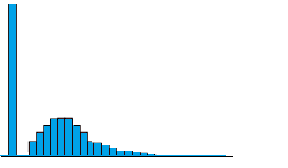

##### This is a photo of our target distribution
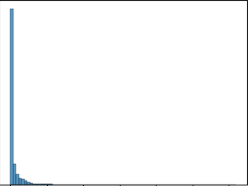

# Using Optuna for getting the best parameters in the model

In [55]:
pip install optuna

Note: you may need to restart the kernel to use updated packages.
   ---------------------------------------- 413.4/413.4 kB 2.6 MB/s eta 0:00:00
   ---------------------------------------- 233.4/233.4 kB 7.2 MB/s eta 0:00:00
   ---------------------------------------- 78.6/78.6 kB 4.3 MB/s eta 0:00:00


In [90]:
import optuna
from sklearn.metrics import mean_squared_error

# 1. Define an objective function to be maximized.
def objective(trial):

    # 2. Suggest values of the hyperparameters using a trial object.
    params = {
    'objective': 'tweedie',
    'metric': 'tweedie',
    'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
    'num_leaves': trial.suggest_int('num_leaves', 10, 200),
    'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
    'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
    'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
    'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
    'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
    'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
    'min_split_gain': trial.suggest_loguniform('min_split_gain', 1e-4, 1e-1),
    'tweedie_variance_power': trial.suggest_uniform('tweedie_variance_power', 1.0, 2.0),
    'max_depth': trial.suggest_int('max_depth', -1, 15),
    'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-5, 1e2),
    'subsample': trial.suggest_uniform('subsample', 0.1, 1.0),
    'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 1.0),
    # Add more hyperparameters to optimize
    }
        
    lgb_model = LGBMRegressor(**params)
    lgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)])

    # Get Tweedie deviance on the test set
    print(lgb_model.evals_result_['valid_0']['tweedie'])
    tweedie_deviance_test = lgb_model.evals_result_['valid_0']['tweedie'][-1]

    return tweedie_deviance_test

In [91]:
study = optuna.create_study(direction='minimize')  # 'minimize' for MSE
study.optimize(objective, n_trials=100)


[I 2024-01-02 19:51:21,280] A new study created in memory with name: no-name-2b8ac147-8c4d-4b23-859d-395b0ecbc4f6


[LightGBM] [Warning] feature_fraction is set=0.8871429640752264, colsample_bytree=0.8971371523189723 will be ignored. Current value: feature_fraction=0.8871429640752264
[LightGBM] [Warning] lambda_l1 is set=1.0818562543926618, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0818562543926618
[LightGBM] [Warning] lambda_l2 is set=0.0008584758960830739, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0008584758960830739
[LightGBM] [Warning] bagging_fraction is set=0.9414904014735905, subsample=0.4443401262943979 will be ignored. Current value: bagging_fraction=0.9414904014735905
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8871429640752264, colsample_bytree=0.8971371523189723 will be ignored. Current value: feature_fraction=0.8871429640752264
[LightGBM] [Warning] lambda_l1 is set=1.0818562543926618, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.081

[I 2024-01-02 19:52:10,074] Trial 0 finished with value: 34.495781384200896 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 18, 'learning_rate': 0.005775592400018323, 'feature_fraction': 0.8871429640752264, 'bagging_fraction': 0.9414904014735905, 'bagging_freq': 2, 'min_child_samples': 37, 'lambda_l1': 1.0818562543926618, 'lambda_l2': 0.0008584758960830739, 'min_split_gain': 0.0028590882607550765, 'tweedie_variance_power': 1.599000611457135, 'max_depth': 9, 'min_child_weight': 8.810078430978859, 'subsample': 0.4443401262943979, 'colsample_bytree': 0.8971371523189723}. Best is trial 0 with value: 34.495781384200896.


[LightGBM] [Warning] feature_fraction is set=0.6808161984596555, colsample_bytree=0.11381759547182145 will be ignored. Current value: feature_fraction=0.6808161984596555
[LightGBM] [Warning] lambda_l1 is set=5.565729997011221e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.565729997011221e-07
[LightGBM] [Warning] lambda_l2 is set=6.044613543713281, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.044613543713281
[LightGBM] [Warning] bagging_fraction is set=0.9913758127363397, subsample=0.9792692026417331 will be ignored. Current value: bagging_fraction=0.9913758127363397
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.6808161984596555, colsample_bytree=0.11381759547182145 will be ignored. Current value: feature_fraction=0.6808161984596555
[LightGBM] [Warning] lambda_l1 is set=5.565729997011221e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.

[I 2024-01-02 19:53:37,196] Trial 1 finished with value: 40.63276145927256 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 164, 'learning_rate': 0.003292718553191007, 'feature_fraction': 0.6808161984596555, 'bagging_fraction': 0.9913758127363397, 'bagging_freq': 9, 'min_child_samples': 87, 'lambda_l1': 5.565729997011221e-07, 'lambda_l2': 6.044613543713281, 'min_split_gain': 0.011882407657458448, 'tweedie_variance_power': 1.583075357581576, 'max_depth': 14, 'min_child_weight': 1.9395747353656663, 'subsample': 0.9792692026417331, 'colsample_bytree': 0.11381759547182145}. Best is trial 0 with value: 34.495781384200896.


[LightGBM] [Warning] feature_fraction is set=0.8014562655608144, colsample_bytree=0.12936516455230251 will be ignored. Current value: feature_fraction=0.8014562655608144
[LightGBM] [Warning] lambda_l1 is set=5.402712777102745e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.402712777102745e-07
[LightGBM] [Warning] lambda_l2 is set=0.0031527711395900816, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0031527711395900816
[LightGBM] [Warning] bagging_fraction is set=0.6242519836515766, subsample=0.5562103411368461 will be ignored. Current value: bagging_fraction=0.6242519836515766
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8014562655608144, colsample_bytree=0.12936516455230251 will be ignored. Current value: feature_fraction=0.8014562655608144
[LightGBM] [Warning] lambda_l1 is set=5.402712777102745e-07, reg_alpha=0.0 will be ignored. Current value: lamb

[I 2024-01-02 19:54:24,064] Trial 2 finished with value: 18.540209624108506 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 26, 'learning_rate': 0.0015219153300733163, 'feature_fraction': 0.8014562655608144, 'bagging_fraction': 0.6242519836515766, 'bagging_freq': 3, 'min_child_samples': 86, 'lambda_l1': 5.402712777102745e-07, 'lambda_l2': 0.0031527711395900816, 'min_split_gain': 0.02835840686078494, 'tweedie_variance_power': 1.893655609433036, 'max_depth': 14, 'min_child_weight': 0.0001282062456961443, 'subsample': 0.5562103411368461, 'colsample_bytree': 0.12936516455230251}. Best is trial 2 with value: 18.540209624108506.


[LightGBM] [Warning] feature_fraction is set=0.18860995712072376, colsample_bytree=0.18928016140310394 will be ignored. Current value: feature_fraction=0.18860995712072376
[LightGBM] [Warning] lambda_l1 is set=1.2556476629430482e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2556476629430482e-07
[LightGBM] [Warning] lambda_l2 is set=0.0002574892696046424, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002574892696046424
[LightGBM] [Warning] bagging_fraction is set=0.6678858837827855, subsample=0.7240943224587985 will be ignored. Current value: bagging_fraction=0.6678858837827855
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.18860995712072376, colsample_bytree=0.18928016140310394 will be ignored. Current value: feature_fraction=0.18860995712072376
[LightGBM] [Warning] lambda_l1 is set=1.2556476629430482e-07, reg_alpha=0.0 will be ignored. Current valu

[I 2024-01-02 19:55:13,656] Trial 3 finished with value: 294.58090433451054 and parameters: {'boosting_type': 'dart', 'num_leaves': 194, 'learning_rate': 0.004895442737964485, 'feature_fraction': 0.18860995712072376, 'bagging_fraction': 0.6678858837827855, 'bagging_freq': 2, 'min_child_samples': 44, 'lambda_l1': 1.2556476629430482e-07, 'lambda_l2': 0.0002574892696046424, 'min_split_gain': 0.0007999314618354123, 'tweedie_variance_power': 1.3524901621143939, 'max_depth': 9, 'min_child_weight': 9.644150682152836e-05, 'subsample': 0.7240943224587985, 'colsample_bytree': 0.18928016140310394}. Best is trial 2 with value: 18.540209624108506.


[LightGBM] [Warning] feature_fraction is set=0.9452815155139747, colsample_bytree=0.45816148770804965 will be ignored. Current value: feature_fraction=0.9452815155139747
[LightGBM] [Warning] lambda_l1 is set=0.0001696386847720041, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001696386847720041
[LightGBM] [Warning] lambda_l2 is set=2.9434586060675344e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9434586060675344e-05
[LightGBM] [Warning] bagging_fraction is set=0.2212087081500695, subsample=0.3141059906185252 will be ignored. Current value: bagging_fraction=0.2212087081500695
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9452815155139747, colsample_bytree=0.45816148770804965 will be ignored. Current value: feature_fraction=0.9452815155139747
[LightGBM] [Warning] lambda_l1 is set=0.0001696386847720041, reg_alpha=0.0 will be ignored. Current value: 

[I 2024-01-02 19:56:14,676] Trial 4 finished with value: 76.00057450781006 and parameters: {'boosting_type': 'dart', 'num_leaves': 183, 'learning_rate': 0.047121134074466206, 'feature_fraction': 0.9452815155139747, 'bagging_fraction': 0.2212087081500695, 'bagging_freq': 10, 'min_child_samples': 12, 'lambda_l1': 0.0001696386847720041, 'lambda_l2': 2.9434586060675344e-05, 'min_split_gain': 0.0005952717904368294, 'tweedie_variance_power': 1.465470573457234, 'max_depth': 0, 'min_child_weight': 0.00014036105974150545, 'subsample': 0.3141059906185252, 'colsample_bytree': 0.45816148770804965}. Best is trial 2 with value: 18.540209624108506.


[LightGBM] [Warning] feature_fraction is set=0.5009237303112316, colsample_bytree=0.776897417025611 will be ignored. Current value: feature_fraction=0.5009237303112316
[LightGBM] [Warning] lambda_l1 is set=8.65877427379669e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.65877427379669e-06
[LightGBM] [Warning] lambda_l2 is set=0.0041541943410326595, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0041541943410326595
[LightGBM] [Warning] bagging_fraction is set=0.3928908559696215, subsample=0.8027313495506561 will be ignored. Current value: bagging_fraction=0.3928908559696215
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5009237303112316, colsample_bytree=0.776897417025611 will be ignored. Current value: feature_fraction=0.5009237303112316
[LightGBM] [Warning] lambda_l1 is set=8.65877427379669e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8

[I 2024-01-02 19:56:39,561] Trial 5 finished with value: 181.87929926886662 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 62, 'learning_rate': 0.027489588639388926, 'feature_fraction': 0.5009237303112316, 'bagging_fraction': 0.3928908559696215, 'bagging_freq': 1, 'min_child_samples': 44, 'lambda_l1': 8.65877427379669e-06, 'lambda_l2': 0.0041541943410326595, 'min_split_gain': 0.01799564250854695, 'tweedie_variance_power': 1.3155777132827526, 'max_depth': 1, 'min_child_weight': 0.005186499191420181, 'subsample': 0.8027313495506561, 'colsample_bytree': 0.776897417025611}. Best is trial 2 with value: 18.540209624108506.


[LightGBM] [Warning] feature_fraction is set=0.7199391136458841, colsample_bytree=0.7746708036507614 will be ignored. Current value: feature_fraction=0.7199391136458841
[LightGBM] [Warning] lambda_l1 is set=0.4875092977009604, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4875092977009604
[LightGBM] [Warning] lambda_l2 is set=0.3985364281180262, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3985364281180262
[LightGBM] [Warning] bagging_fraction is set=0.8600788194895077, subsample=0.19337619159628755 will be ignored. Current value: bagging_fraction=0.8600788194895077
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.7199391136458841, colsample_bytree=0.7746708036507614 will be ignored. Current value: feature_fraction=0.7199391136458841
[LightGBM] [Warning] lambda_l1 is set=0.4875092977009604, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.48750929

[I 2024-01-02 19:57:22,255] Trial 6 finished with value: 93.96386110188692 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 15, 'learning_rate': 0.05606183906129467, 'feature_fraction': 0.7199391136458841, 'bagging_fraction': 0.8600788194895077, 'bagging_freq': 3, 'min_child_samples': 71, 'lambda_l1': 0.4875092977009604, 'lambda_l2': 0.3985364281180262, 'min_split_gain': 0.0003484346327201651, 'tweedie_variance_power': 1.3953257040070621, 'max_depth': 5, 'min_child_weight': 2.399632743872252e-05, 'subsample': 0.19337619159628755, 'colsample_bytree': 0.7746708036507614}. Best is trial 2 with value: 18.540209624108506.


[LightGBM] [Warning] feature_fraction is set=0.5187055054131903, colsample_bytree=0.3053641695550918 will be ignored. Current value: feature_fraction=0.5187055054131903
[LightGBM] [Warning] lambda_l1 is set=7.834562895569095e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.834562895569095e-05
[LightGBM] [Warning] lambda_l2 is set=0.00582336281681696, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00582336281681696
[LightGBM] [Warning] bagging_fraction is set=0.7225331050772077, subsample=0.5188038192154764 will be ignored. Current value: bagging_fraction=0.7225331050772077
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5187055054131903, colsample_bytree=0.3053641695550918 will be ignored. Current value: feature_fraction=0.5187055054131903
[LightGBM] [Warning] lambda_l1 is set=7.834562895569095e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=

[I 2024-01-02 19:58:07,752] Trial 7 finished with value: 21.544322638390675 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'learning_rate': 0.01884007211968036, 'feature_fraction': 0.5187055054131903, 'bagging_fraction': 0.7225331050772077, 'bagging_freq': 2, 'min_child_samples': 81, 'lambda_l1': 7.834562895569095e-05, 'lambda_l2': 0.00582336281681696, 'min_split_gain': 0.004722450211873414, 'tweedie_variance_power': 1.9263047134035371, 'max_depth': 14, 'min_child_weight': 42.71757711717317, 'subsample': 0.5188038192154764, 'colsample_bytree': 0.3053641695550918}. Best is trial 2 with value: 18.540209624108506.


[LightGBM] [Warning] feature_fraction is set=0.7256678785587178, colsample_bytree=0.42452669472673177 will be ignored. Current value: feature_fraction=0.7256678785587178
[LightGBM] [Warning] lambda_l1 is set=1.7725102907147643, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7725102907147643
[LightGBM] [Warning] lambda_l2 is set=3.5273770514294946e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5273770514294946e-06
[LightGBM] [Warning] bagging_fraction is set=0.54329112334736, subsample=0.30491119494982266 will be ignored. Current value: bagging_fraction=0.54329112334736
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.7256678785587178, colsample_bytree=0.42452669472673177 will be ignored. Current value: feature_fraction=0.7256678785587178
[LightGBM] [Warning] lambda_l1 is set=1.7725102907147643, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.

[I 2024-01-02 19:58:59,444] Trial 8 finished with value: 5353.014286442259 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 99, 'learning_rate': 0.052242133003727584, 'feature_fraction': 0.7256678785587178, 'bagging_fraction': 0.54329112334736, 'bagging_freq': 10, 'min_child_samples': 13, 'lambda_l1': 1.7725102907147643, 'lambda_l2': 3.5273770514294946e-06, 'min_split_gain': 0.0052450773875364455, 'tweedie_variance_power': 1.0471541651217096, 'max_depth': 8, 'min_child_weight': 0.2230999224646346, 'subsample': 0.30491119494982266, 'colsample_bytree': 0.42452669472673177}. Best is trial 2 with value: 18.540209624108506.


[LightGBM] [Warning] feature_fraction is set=0.39193769221211794, colsample_bytree=0.5590380976108309 will be ignored. Current value: feature_fraction=0.39193769221211794
[LightGBM] [Warning] lambda_l1 is set=3.1929332748465194e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1929332748465194e-06
[LightGBM] [Warning] lambda_l2 is set=1.053293090267401, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.053293090267401
[LightGBM] [Warning] bagging_fraction is set=0.7803632657391611, subsample=0.8110432429677019 will be ignored. Current value: bagging_fraction=0.7803632657391611
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.39193769221211794, colsample_bytree=0.5590380976108309 will be ignored. Current value: feature_fraction=0.39193769221211794
[LightGBM] [Warning] lambda_l1 is set=3.1929332748465194e-06, reg_alpha=0.0 will be ignored. Current value: lambda_

[I 2024-01-02 19:59:43,319] Trial 9 finished with value: 170.74848998281482 and parameters: {'boosting_type': 'dart', 'num_leaves': 27, 'learning_rate': 0.02166715136822557, 'feature_fraction': 0.39193769221211794, 'bagging_fraction': 0.7803632657391611, 'bagging_freq': 6, 'min_child_samples': 66, 'lambda_l1': 3.1929332748465194e-06, 'lambda_l2': 1.053293090267401, 'min_split_gain': 0.00028392843009726756, 'tweedie_variance_power': 1.382803183467597, 'max_depth': 4, 'min_child_weight': 0.8787073820994429, 'subsample': 0.8110432429677019, 'colsample_bytree': 0.5590380976108309}. Best is trial 2 with value: 18.540209624108506.


[LightGBM] [Warning] feature_fraction is set=0.9918955003335714, colsample_bytree=0.6595052073698793 will be ignored. Current value: feature_fraction=0.9918955003335714
[LightGBM] [Warning] lambda_l1 is set=1.0646827093285681e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0646827093285681e-08
[LightGBM] [Warning] lambda_l2 is set=1.5374926587812678e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5374926587812678e-08
[LightGBM] [Warning] bagging_fraction is set=0.49690376511114476, subsample=0.5597166873167849 will be ignored. Current value: bagging_fraction=0.49690376511114476
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9918955003335714, colsample_bytree=0.6595052073698793 will be ignored. Current value: feature_fraction=0.9918955003335714
[LightGBM] [Warning] lambda_l1 is set=1.0646827093285681e-08, reg_alpha=0.0 will be ignored. Current value:

[I 2024-01-02 20:01:04,250] Trial 10 finished with value: 69.26184109072322 and parameters: {'boosting_type': 'dart', 'num_leaves': 137, 'learning_rate': 0.0010538657510242946, 'feature_fraction': 0.9918955003335714, 'bagging_fraction': 0.49690376511114476, 'bagging_freq': 5, 'min_child_samples': 98, 'lambda_l1': 1.0646827093285681e-08, 'lambda_l2': 1.5374926587812678e-08, 'min_split_gain': 0.06972410340763656, 'tweedie_variance_power': 1.9799668568864432, 'max_depth': 12, 'min_child_weight': 0.0015814474211054935, 'subsample': 0.5597166873167849, 'colsample_bytree': 0.6595052073698793}. Best is trial 2 with value: 18.540209624108506.


[LightGBM] [Warning] feature_fraction is set=0.3839080247412504, colsample_bytree=0.26849101883056087 will be ignored. Current value: feature_fraction=0.3839080247412504
[LightGBM] [Warning] lambda_l1 is set=0.0050437876485488154, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0050437876485488154
[LightGBM] [Warning] lambda_l2 is set=0.14398568568274614, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.14398568568274614
[LightGBM] [Warning] bagging_fraction is set=0.720353310421318, subsample=0.5632245790886973 will be ignored. Current value: bagging_fraction=0.720353310421318
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.3839080247412504, colsample_bytree=0.26849101883056087 will be ignored. Current value: feature_fraction=0.3839080247412504
[LightGBM] [Warning] lambda_l1 is set=0.0050437876485488154, reg_alpha=0.0 will be ignored. Current value: lambda_l1=

[I 2024-01-02 20:01:44,421] Trial 11 finished with value: 33.63537353427881 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 66, 'learning_rate': 0.012554781680013056, 'feature_fraction': 0.3839080247412504, 'bagging_fraction': 0.720353310421318, 'bagging_freq': 4, 'min_child_samples': 79, 'lambda_l1': 0.0050437876485488154, 'lambda_l2': 0.14398568568274614, 'min_split_gain': 0.0807002898574654, 'tweedie_variance_power': 1.9541021060808563, 'max_depth': 15, 'min_child_weight': 45.00860796785739, 'subsample': 0.5632245790886973, 'colsample_bytree': 0.26849101883056087}. Best is trial 2 with value: 18.540209624108506.


[LightGBM] [Warning] feature_fraction is set=0.5775855689279925, colsample_bytree=0.28518521346351927 will be ignored. Current value: feature_fraction=0.5775855689279925
[LightGBM] [Warning] lambda_l1 is set=0.00018475199961121507, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00018475199961121507
[LightGBM] [Warning] lambda_l2 is set=0.0156856134961234, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0156856134961234
[LightGBM] [Warning] bagging_fraction is set=0.6294560969774884, subsample=0.4694801531015947 will be ignored. Current value: bagging_fraction=0.6294560969774884
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5775855689279925, colsample_bytree=0.28518521346351927 will be ignored. Current value: feature_fraction=0.5775855689279925
[LightGBM] [Warning] lambda_l1 is set=0.00018475199961121507, reg_alpha=0.0 will be ignored. Current value: lambda_

[I 2024-01-02 20:02:35,371] Trial 12 finished with value: 19.41870175301435 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 61, 'learning_rate': 0.001721476453798205, 'feature_fraction': 0.5775855689279925, 'bagging_fraction': 0.6294560969774884, 'bagging_freq': 7, 'min_child_samples': 98, 'lambda_l1': 0.00018475199961121507, 'lambda_l2': 0.0156856134961234, 'min_split_gain': 0.022997523771963655, 'tweedie_variance_power': 1.7838607333898704, 'max_depth': 12, 'min_child_weight': 0.032486521336180886, 'subsample': 0.4694801531015947, 'colsample_bytree': 0.28518521346351927}. Best is trial 2 with value: 18.540209624108506.


[LightGBM] [Warning] feature_fraction is set=0.8080506554539417, colsample_bytree=0.3309108534755151 will be ignored. Current value: feature_fraction=0.8080506554539417
[LightGBM] [Warning] lambda_l1 is set=0.00876328071637872, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00876328071637872
[LightGBM] [Warning] lambda_l2 is set=0.032354800085877745, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.032354800085877745
[LightGBM] [Warning] bagging_fraction is set=0.3494493175473783, subsample=0.678897676158187 will be ignored. Current value: bagging_fraction=0.3494493175473783
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.8080506554539417, colsample_bytree=0.3309108534755151 will be ignored. Current value: feature_fraction=0.8080506554539417
[LightGBM] [Warning] lambda_l1 is set=0.00876328071637872, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.008

[I 2024-01-02 20:03:16,815] Trial 13 finished with value: 23.633526826334187 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 46, 'learning_rate': 0.0013645549407867595, 'feature_fraction': 0.8080506554539417, 'bagging_fraction': 0.3494493175473783, 'bagging_freq': 7, 'min_child_samples': 97, 'lambda_l1': 0.00876328071637872, 'lambda_l2': 0.032354800085877745, 'min_split_gain': 0.029002103294553078, 'tweedie_variance_power': 1.7240790491183633, 'max_depth': 11, 'min_child_weight': 0.035439466725078646, 'subsample': 0.678897676158187, 'colsample_bytree': 0.3309108534755151}. Best is trial 2 with value: 18.540209624108506.


[LightGBM] [Warning] feature_fraction is set=0.6711097957300465, colsample_bytree=0.1304511102817151 will be ignored. Current value: feature_fraction=0.6711097957300465
[LightGBM] [Warning] lambda_l1 is set=0.014233679503565595, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.014233679503565595
[LightGBM] [Warning] lambda_l2 is set=7.734594446970498e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.734594446970498e-06
[LightGBM] [Warning] bagging_fraction is set=0.603644271556369, subsample=0.3969240236892431 will be ignored. Current value: bagging_fraction=0.603644271556369
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.6711097957300465, colsample_bytree=0.1304511102817151 will be ignored. Current value: feature_fraction=0.6711097957300465
[LightGBM] [Warning] lambda_l1 is set=0.014233679503565595, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0

[I 2024-01-02 20:04:19,125] Trial 14 finished with value: 18.874236042693095 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 97, 'learning_rate': 0.0020708205726226304, 'feature_fraction': 0.6711097957300465, 'bagging_fraction': 0.603644271556369, 'bagging_freq': 8, 'min_child_samples': 60, 'lambda_l1': 0.014233679503565595, 'lambda_l2': 7.734594446970498e-06, 'min_split_gain': 0.03361633258428424, 'tweedie_variance_power': 1.7900533602456392, 'max_depth': 12, 'min_child_weight': 0.0030475973007679335, 'subsample': 0.3969240236892431, 'colsample_bytree': 0.1304511102817151}. Best is trial 2 with value: 18.540209624108506.


[LightGBM] [Warning] feature_fraction is set=0.8221699150871291, colsample_bytree=0.13892386338966697 will be ignored. Current value: feature_fraction=0.8221699150871291
[LightGBM] [Warning] lambda_l1 is set=0.01627362487225919, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01627362487225919
[LightGBM] [Warning] lambda_l2 is set=6.45641085615167e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.45641085615167e-07
[LightGBM] [Warning] bagging_fraction is set=0.43808615426499686, subsample=0.1187871021210164 will be ignored. Current value: bagging_fraction=0.43808615426499686
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.8221699150871291, colsample_bytree=0.13892386338966697 will be ignored. Current value: feature_fraction=0.8221699150871291
[LightGBM] [Warning] lambda_l1 is set=0.01627362487225919, reg_alpha=0.0 will be ignored. Current value: lambda_l1=

[I 2024-01-02 20:05:15,619] Trial 15 finished with value: 18.719127137359777 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 106, 'learning_rate': 0.0024265402300900443, 'feature_fraction': 0.8221699150871291, 'bagging_fraction': 0.43808615426499686, 'bagging_freq': 8, 'min_child_samples': 59, 'lambda_l1': 0.01627362487225919, 'lambda_l2': 6.45641085615167e-07, 'min_split_gain': 0.00011365405757322274, 'tweedie_variance_power': 1.787648371630929, 'max_depth': 11, 'min_child_weight': 0.001231097603701026, 'subsample': 0.1187871021210164, 'colsample_bytree': 0.13892386338966697}. Best is trial 2 with value: 18.540209624108506.


[LightGBM] [Warning] feature_fraction is set=0.912738766249817, colsample_bytree=0.41901289444462614 will be ignored. Current value: feature_fraction=0.912738766249817
[LightGBM] [Warning] lambda_l1 is set=0.10579960286185171, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.10579960286185171
[LightGBM] [Warning] lambda_l2 is set=3.403029942690584e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.403029942690584e-07
[LightGBM] [Warning] bagging_fraction is set=0.14377897783204857, subsample=0.12866810178574056 will be ignored. Current value: bagging_fraction=0.14377897783204857
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.912738766249817, colsample_bytree=0.41901289444462614 will be ignored. Current value: feature_fraction=0.912738766249817
[LightGBM] [Warning] lambda_l1 is set=0.10579960286185171, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0

[I 2024-01-02 20:05:47,256] Trial 16 finished with value: 26.626237298677164 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 130, 'learning_rate': 0.002875771780519819, 'feature_fraction': 0.912738766249817, 'bagging_fraction': 0.14377897783204857, 'bagging_freq': 5, 'min_child_samples': 28, 'lambda_l1': 0.10579960286185171, 'lambda_l2': 3.403029942690584e-07, 'min_split_gain': 0.00010523603452782695, 'tweedie_variance_power': 1.677267424473412, 'max_depth': 6, 'min_child_weight': 0.0005672545654435103, 'subsample': 0.12866810178574056, 'colsample_bytree': 0.41901289444462614}. Best is trial 2 with value: 18.540209624108506.


[LightGBM] [Warning] feature_fraction is set=0.8598481537243291, colsample_bytree=0.21901279034425647 will be ignored. Current value: feature_fraction=0.8598481537243291
[LightGBM] [Warning] lambda_l1 is set=0.0021792330741901038, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0021792330741901038
[LightGBM] [Warning] lambda_l2 is set=7.619793917217572e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.619793917217572e-08
[LightGBM] [Warning] bagging_fraction is set=0.427999110159332, subsample=0.2803227188837907 will be ignored. Current value: bagging_fraction=0.427999110159332
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8598481537243291, colsample_bytree=0.21901279034425647 will be ignored. Current value: feature_fraction=0.8598481537243291
[LightGBM] [Warning] lambda_l1 is set=0.0021792330741901038, reg_alpha=0.0 will be ignored. Current value: lambda

[I 2024-01-02 20:06:47,718] Trial 17 finished with value: 15.546724431242746 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 122, 'learning_rate': 0.007614611685922871, 'feature_fraction': 0.8598481537243291, 'bagging_fraction': 0.427999110159332, 'bagging_freq': 4, 'min_child_samples': 59, 'lambda_l1': 0.0021792330741901038, 'lambda_l2': 7.619793917217572e-08, 'min_split_gain': 0.002492124900314941, 'tweedie_variance_power': 1.8103448246146001, 'max_depth': 10, 'min_child_weight': 2.3945458725376158e-05, 'subsample': 0.2803227188837907, 'colsample_bytree': 0.21901279034425647}. Best is trial 17 with value: 15.546724431242746.


[LightGBM] [Warning] feature_fraction is set=0.8222879893116464, colsample_bytree=0.2235519931444293 will be ignored. Current value: feature_fraction=0.8222879893116464
[LightGBM] [Warning] lambda_l1 is set=1.8950110458384054e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8950110458384054e-05
[LightGBM] [Warning] lambda_l2 is set=1.0711491400105762e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0711491400105762e-08
[LightGBM] [Warning] bagging_fraction is set=0.2926328799628401, subsample=0.2967623848674868 will be ignored. Current value: bagging_fraction=0.2926328799628401
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8222879893116464, colsample_bytree=0.2235519931444293 will be ignored. Current value: feature_fraction=0.8222879893116464
[LightGBM] [Warning] lambda_l1 is set=1.8950110458384054e-05, reg_alpha=0.0 will be ignored. Current value: l

[I 2024-01-02 20:07:59,658] Trial 18 finished with value: 31.628480203510275 and parameters: {'boosting_type': 'dart', 'num_leaves': 125, 'learning_rate': 0.0076829986165345265, 'feature_fraction': 0.8222879893116464, 'bagging_fraction': 0.2926328799628401, 'bagging_freq': 4, 'min_child_samples': 52, 'lambda_l1': 1.8950110458384054e-05, 'lambda_l2': 1.0711491400105762e-08, 'min_split_gain': 0.0018002336369356746, 'tweedie_variance_power': 1.8829018090551, 'max_depth': 15, 'min_child_weight': 1.4046128873631936e-05, 'subsample': 0.2967623848674868, 'colsample_bytree': 0.2235519931444293}. Best is trial 17 with value: 15.546724431242746.


[LightGBM] [Warning] feature_fraction is set=0.13533865361779313, colsample_bytree=0.5331102251676256 will be ignored. Current value: feature_fraction=0.13533865361779313
[LightGBM] [Warning] lambda_l1 is set=0.0012284208673365164, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0012284208673365164
[LightGBM] [Warning] lambda_l2 is set=0.0001103645922735015, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001103645922735015
[LightGBM] [Warning] bagging_fraction is set=0.5219885986083227, subsample=0.6451869158109235 will be ignored. Current value: bagging_fraction=0.5219885986083227
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.13533865361779313, colsample_bytree=0.5331102251676256 will be ignored. Current value: feature_fraction=0.13533865361779313
[LightGBM] [Warning] lambda_l1 is set=0.0012284208673365164, reg_alpha=0.0 will be ignored. Current value: la

[I 2024-01-02 20:08:20,196] Trial 19 finished with value: 980.9518824582577 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 152, 'learning_rate': 0.09959266369640749, 'feature_fraction': 0.13533865361779313, 'bagging_fraction': 0.5219885986083227, 'bagging_freq': 4, 'min_child_samples': 73, 'lambda_l1': 0.0012284208673365164, 'lambda_l2': 0.0001103645922735015, 'min_split_gain': 0.0072452045378039315, 'tweedie_variance_power': 1.1440522227091328, 'max_depth': 3, 'min_child_weight': 8.873232225306465e-05, 'subsample': 0.6451869158109235, 'colsample_bytree': 0.5331102251676256}. Best is trial 17 with value: 15.546724431242746.


[LightGBM] [Warning] feature_fraction is set=0.6291866368279642, colsample_bytree=0.3719183283009573 will be ignored. Current value: feature_fraction=0.6291866368279642
[LightGBM] [Warning] lambda_l1 is set=1.1330287279204299e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1330287279204299e-08
[LightGBM] [Warning] lambda_l2 is set=1.5381227989278195e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5381227989278195e-07
[LightGBM] [Warning] bagging_fraction is set=0.44427474616623297, subsample=0.39723807914966447 will be ignored. Current value: bagging_fraction=0.44427474616623297
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6291866368279642, colsample_bytree=0.3719183283009573 will be ignored. Current value: feature_fraction=0.6291866368279642
[LightGBM] [Warning] lambda_l1 is set=1.1330287279204299e-08, reg_alpha=0.0 will be ignored. Current value

[I 2024-01-02 20:09:11,552] Trial 20 finished with value: 14.958841768700609 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 84, 'learning_rate': 0.01055523467864002, 'feature_fraction': 0.6291866368279642, 'bagging_fraction': 0.44427474616623297, 'bagging_freq': 3, 'min_child_samples': 87, 'lambda_l1': 1.1330287279204299e-08, 'lambda_l2': 1.5381227989278195e-07, 'min_split_gain': 0.002295051755117434, 'tweedie_variance_power': 1.8716373549910486, 'max_depth': 10, 'min_child_weight': 1.122490589267883e-05, 'subsample': 0.39723807914966447, 'colsample_bytree': 0.3719183283009573}. Best is trial 20 with value: 14.958841768700609.


[LightGBM] [Warning] feature_fraction is set=0.5860134323182777, colsample_bytree=0.391970110896176 will be ignored. Current value: feature_fraction=0.5860134323182777
[LightGBM] [Warning] lambda_l1 is set=4.809917563968632e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.809917563968632e-08
[LightGBM] [Warning] lambda_l2 is set=1.3154357602676267e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3154357602676267e-07
[LightGBM] [Warning] bagging_fraction is set=0.4554202497396031, subsample=0.3706811660203202 will be ignored. Current value: bagging_fraction=0.4554202497396031
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5860134323182777, colsample_bytree=0.391970110896176 will be ignored. Current value: feature_fraction=0.5860134323182777
[LightGBM] [Warning] lambda_l1 is set=4.809917563968632e-08, reg_alpha=0.0 will be ignored. Current value: lambda

[I 2024-01-02 20:10:01,866] Trial 21 finished with value: 14.734072154848507 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 88, 'learning_rate': 0.010752195582319126, 'feature_fraction': 0.5860134323182777, 'bagging_fraction': 0.4554202497396031, 'bagging_freq': 3, 'min_child_samples': 88, 'lambda_l1': 4.809917563968632e-08, 'lambda_l2': 1.3154357602676267e-07, 'min_split_gain': 0.001531350426615969, 'tweedie_variance_power': 1.862467711229689, 'max_depth': 10, 'min_child_weight': 1.0418723728060795e-05, 'subsample': 0.3706811660203202, 'colsample_bytree': 0.391970110896176}. Best is trial 21 with value: 14.734072154848507.


[LightGBM] [Warning] feature_fraction is set=0.5816019242708479, colsample_bytree=0.3557636372807223 will be ignored. Current value: feature_fraction=0.5816019242708479
[LightGBM] [Warning] lambda_l1 is set=1.11798509803329e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.11798509803329e-08
[LightGBM] [Warning] lambda_l2 is set=1.0579888399749651e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0579888399749651e-07
[LightGBM] [Warning] bagging_fraction is set=0.28506334003943345, subsample=0.23089964565889845 will be ignored. Current value: bagging_fraction=0.28506334003943345
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5816019242708479, colsample_bytree=0.3557636372807223 will be ignored. Current value: feature_fraction=0.5816019242708479
[LightGBM] [Warning] lambda_l1 is set=1.11798509803329e-08, reg_alpha=0.0 will be ignored. Current value: lamb

[I 2024-01-02 20:10:43,725] Trial 22 finished with value: 14.541196241164801 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 84, 'learning_rate': 0.011197427639801992, 'feature_fraction': 0.5816019242708479, 'bagging_fraction': 0.28506334003943345, 'bagging_freq': 3, 'min_child_samples': 91, 'lambda_l1': 1.11798509803329e-08, 'lambda_l2': 1.0579888399749651e-07, 'min_split_gain': 0.0016743479064318483, 'tweedie_variance_power': 1.850546477647083, 'max_depth': 7, 'min_child_weight': 1.1937581176189265e-05, 'subsample': 0.23089964565889845, 'colsample_bytree': 0.3557636372807223}. Best is trial 22 with value: 14.541196241164801.


[LightGBM] [Warning] feature_fraction is set=0.5920847750812431, colsample_bytree=0.37093055199600783 will be ignored. Current value: feature_fraction=0.5920847750812431
[LightGBM] [Warning] lambda_l1 is set=1.4702399568910359e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4702399568910359e-08
[LightGBM] [Warning] lambda_l2 is set=2.0917312983976322e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0917312983976322e-07
[LightGBM] [Warning] bagging_fraction is set=0.2894103293378736, subsample=0.3821824068136209 will be ignored. Current value: bagging_fraction=0.2894103293378736
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5920847750812431, colsample_bytree=0.37093055199600783 will be ignored. Current value: feature_fraction=0.5920847750812431
[LightGBM] [Warning] lambda_l1 is set=1.4702399568910359e-08, reg_alpha=0.0 will be ignored. Current value:

[I 2024-01-02 20:11:27,613] Trial 23 finished with value: 23.88196329723777 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 82, 'learning_rate': 0.012458462441895564, 'feature_fraction': 0.5920847750812431, 'bagging_fraction': 0.2894103293378736, 'bagging_freq': 1, 'min_child_samples': 90, 'lambda_l1': 1.4702399568910359e-08, 'lambda_l2': 2.0917312983976322e-07, 'min_split_gain': 0.0012422038433238633, 'tweedie_variance_power': 1.6468433505521833, 'max_depth': 7, 'min_child_weight': 1.0070890667336449e-05, 'subsample': 0.3821824068136209, 'colsample_bytree': 0.37093055199600783}. Best is trial 22 with value: 14.541196241164801.


[LightGBM] [Warning] feature_fraction is set=0.41065713563547324, colsample_bytree=0.5372194734745563 will be ignored. Current value: feature_fraction=0.41065713563547324
[LightGBM] [Warning] lambda_l1 is set=6.914094120966213e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.914094120966213e-08
[LightGBM] [Warning] lambda_l2 is set=2.3393422311074755e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3393422311074755e-06
[LightGBM] [Warning] bagging_fraction is set=0.1108694263994581, subsample=0.21074257548672684 will be ignored. Current value: bagging_fraction=0.1108694263994581
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.41065713563547324, colsample_bytree=0.5372194734745563 will be ignored. Current value: feature_fraction=0.41065713563547324
[LightGBM] [Warning] lambda_l1 is set=6.914094120966213e-08, reg_alpha=0.0 will be ignored. Current value:

[I 2024-01-02 20:12:00,638] Trial 24 finished with value: 14.65329188352251 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 85, 'learning_rate': 0.01109327932746463, 'feature_fraction': 0.41065713563547324, 'bagging_fraction': 0.1108694263994581, 'bagging_freq': 3, 'min_child_samples': 91, 'lambda_l1': 6.914094120966213e-08, 'lambda_l2': 2.3393422311074755e-06, 'min_split_gain': 0.0008798440825584862, 'tweedie_variance_power': 1.8587589169779448, 'max_depth': 7, 'min_child_weight': 0.00035071002734995304, 'subsample': 0.21074257548672684, 'colsample_bytree': 0.5372194734745563}. Best is trial 22 with value: 14.541196241164801.


[LightGBM] [Warning] feature_fraction is set=0.43323482919007644, colsample_bytree=0.5166003704862187 will be ignored. Current value: feature_fraction=0.43323482919007644
[LightGBM] [Warning] lambda_l1 is set=9.794343721585814e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.794343721585814e-08
[LightGBM] [Warning] lambda_l2 is set=1.8439014061574931e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8439014061574931e-06
[LightGBM] [Warning] bagging_fraction is set=0.1423106858167678, subsample=0.19716159554744747 will be ignored. Current value: bagging_fraction=0.1423106858167678
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.43323482919007644, colsample_bytree=0.5166003704862187 will be ignored. Current value: feature_fraction=0.43323482919007644
[LightGBM] [Warning] lambda_l1 is set=9.794343721585814e-08, reg_alpha=0.0 will be ignored. Current value:

[I 2024-01-02 20:12:33,058] Trial 25 finished with value: 42.788826354167234 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 81, 'learning_rate': 0.018505413383615048, 'feature_fraction': 0.43323482919007644, 'bagging_fraction': 0.1423106858167678, 'bagging_freq': 3, 'min_child_samples': 78, 'lambda_l1': 9.794343721585814e-08, 'lambda_l2': 1.8439014061574931e-06, 'min_split_gain': 0.0011057379217196215, 'tweedie_variance_power': 1.5214360024226399, 'max_depth': 7, 'min_child_weight': 0.00036987599826746514, 'subsample': 0.19716159554744747, 'colsample_bytree': 0.5166003704862187}. Best is trial 22 with value: 14.541196241164801.


[LightGBM] [Warning] feature_fraction is set=0.31329835067861833, colsample_bytree=0.6353937924931721 will be ignored. Current value: feature_fraction=0.31329835067861833
[LightGBM] [Warning] lambda_l1 is set=1.398650749596852e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.398650749596852e-07
[LightGBM] [Warning] lambda_l2 is set=6.697931673716642e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.697931673716642e-08
[LightGBM] [Warning] bagging_fraction is set=0.2371795337238884, subsample=0.2167228968720884 will be ignored. Current value: bagging_fraction=0.2371795337238884
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.31329835067861833, colsample_bytree=0.6353937924931721 will be ignored. Current value: feature_fraction=0.31329835067861833
[LightGBM] [Warning] lambda_l1 is set=1.398650749596852e-07, reg_alpha=0.0 will be ignored. Current value: la

[I 2024-01-02 20:12:59,887] Trial 26 finished with value: 463.6076198353935 and parameters: {'boosting_type': 'dart', 'num_leaves': 45, 'learning_rate': 0.004705416172236488, 'feature_fraction': 0.31329835067861833, 'bagging_fraction': 0.2371795337238884, 'bagging_freq': 2, 'min_child_samples': 90, 'lambda_l1': 1.398650749596852e-07, 'lambda_l2': 6.697931673716642e-08, 'min_split_gain': 0.0005663398951537203, 'tweedie_variance_power': 1.9977662846027084, 'max_depth': 3, 'min_child_weight': 5.170726722796034e-05, 'subsample': 0.2167228968720884, 'colsample_bytree': 0.6353937924931721}. Best is trial 22 with value: 14.541196241164801.


[LightGBM] [Warning] feature_fraction is set=0.29259403927276806, colsample_bytree=0.6098436438305284 will be ignored. Current value: feature_fraction=0.29259403927276806
[LightGBM] [Warning] lambda_l1 is set=1.1487246150129784e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1487246150129784e-06
[LightGBM] [Warning] lambda_l2 is set=1.8410831080445173e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8410831080445173e-05
[LightGBM] [Warning] bagging_fraction is set=0.11388238991995368, subsample=0.242642564157249 will be ignored. Current value: bagging_fraction=0.11388238991995368
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.29259403927276806, colsample_bytree=0.6098436438305284 will be ignored. Current value: feature_fraction=0.29259403927276806
[LightGBM] [Warning] lambda_l1 is set=1.1487246150129784e-06, reg_alpha=0.0 will be ignored. Current val

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-01-02 20:13:22,401] Trial 27 finished with value: 16.553991703553823 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 111, 'learning_rate': 0.03248134215285987, 'feature_fraction': 0.29259403927276806, 'bagging_fraction': 0.11388238991995368, 'bagging_freq': 5, 'min_child_samples': 70, 'lambda_l1': 1.1487246150129784e-06, 'lambda_l2': 1.8410831080445173e-05, 'min_split_gain': 0.0002673670349920114, 'tweedie_variance_power': 1.7224658481987254, 'max_depth': 6, 'min_child_weight': 0.009914862896655698, 'subsample': 0.242642564157249, 'colsample_bytree': 0.6098436438305284}. Best is trial 22 with value: 14.541196241164801.


[LightGBM] [Warning] feature_fraction is set=0.4683350241881555, colsample_bytree=0.4868018063718752 will be ignored. Current value: feature_fraction=0.4683350241881555
[LightGBM] [Warning] lambda_l1 is set=4.119075109484454e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.119075109484454e-08
[LightGBM] [Warning] lambda_l2 is set=1.2167225080936474e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2167225080936474e-06
[LightGBM] [Warning] bagging_fraction is set=0.3147451860629526, subsample=0.3435535452128624 will be ignored. Current value: bagging_fraction=0.3147451860629526
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4683350241881555, colsample_bytree=0.4868018063718752 will be ignored. Current value: feature_fraction=0.4683350241881555
[LightGBM] [Warning] lambda_l1 is set=4.119075109484454e-08, reg_alpha=0.0 will be ignored. Current value: lamb

[I 2024-01-02 20:14:04,261] Trial 28 finished with value: 14.100626988224384 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 93, 'learning_rate': 0.015084715440863648, 'feature_fraction': 0.4683350241881555, 'bagging_fraction': 0.3147451860629526, 'bagging_freq': 1, 'min_child_samples': 93, 'lambda_l1': 4.119075109484454e-08, 'lambda_l2': 1.2167225080936474e-06, 'min_split_gain': 0.001440037849560778, 'tweedie_variance_power': 1.841088197435894, 'max_depth': 8, 'min_child_weight': 0.00036366905912362673, 'subsample': 0.3435535452128624, 'colsample_bytree': 0.4868018063718752}. Best is trial 28 with value: 14.100626988224384.


[LightGBM] [Warning] feature_fraction is set=0.43927054297486895, colsample_bytree=0.7501082685230449 will be ignored. Current value: feature_fraction=0.43927054297486895
[LightGBM] [Warning] lambda_l1 is set=3.5312692595832463e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5312692595832463e-08
[LightGBM] [Warning] lambda_l2 is set=1.5255225406904952e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5255225406904952e-06
[LightGBM] [Warning] bagging_fraction is set=0.19110349664419826, subsample=0.15196326604891053 will be ignored. Current value: bagging_fraction=0.19110349664419826
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.43927054297486895, colsample_bytree=0.7501082685230449 will be ignored. Current value: feature_fraction=0.43927054297486895
[LightGBM] [Warning] lambda_l1 is set=3.5312692595832463e-08, reg_alpha=0.0 will be ignored. Current v

[I 2024-01-02 20:14:38,514] Trial 29 finished with value: 35.035387110571605 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 49, 'learning_rate': 0.007026471499719018, 'feature_fraction': 0.43927054297486895, 'bagging_fraction': 0.19110349664419826, 'bagging_freq': 1, 'min_child_samples': 100, 'lambda_l1': 3.5312692595832463e-08, 'lambda_l2': 1.5255225406904952e-06, 'min_split_gain': 0.0032697433806358517, 'tweedie_variance_power': 1.588586975643988, 'max_depth': 8, 'min_child_weight': 0.00038656759284066256, 'subsample': 0.15196326604891053, 'colsample_bytree': 0.7501082685230449}. Best is trial 28 with value: 14.100626988224384.


[LightGBM] [Warning] feature_fraction is set=0.29497360936317557, colsample_bytree=0.9783618051781149 will be ignored. Current value: feature_fraction=0.29497360936317557
[LightGBM] [Warning] lambda_l1 is set=3.221202172101797e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.221202172101797e-07
[LightGBM] [Warning] lambda_l2 is set=0.00010049842433770802, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00010049842433770802
[LightGBM] [Warning] bagging_fraction is set=0.3041156885561343, subsample=0.4449286752506979 will be ignored. Current value: bagging_fraction=0.3041156885561343
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.29497360936317557, colsample_bytree=0.9783618051781149 will be ignored. Current value: feature_fraction=0.29497360936317557
[LightGBM] [Warning] lambda_l1 is set=3.221202172101797e-07, reg_alpha=0.0 will be ignored. Current value: 

[I 2024-01-02 20:15:07,314] Trial 30 finished with value: 17.85890940016212 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 113, 'learning_rate': 0.014876035544834857, 'feature_fraction': 0.29497360936317557, 'bagging_fraction': 0.3041156885561343, 'bagging_freq': 2, 'min_child_samples': 26, 'lambda_l1': 3.221202172101797e-07, 'lambda_l2': 0.00010049842433770802, 'min_split_gain': 0.0008604031655159448, 'tweedie_variance_power': 1.7158989801465454, 'max_depth': 5, 'min_child_weight': 0.013149981646633831, 'subsample': 0.4449286752506979, 'colsample_bytree': 0.9783618051781149}. Best is trial 28 with value: 14.100626988224384.


[LightGBM] [Warning] feature_fraction is set=0.4927614791641745, colsample_bytree=0.46757199244930153 will be ignored. Current value: feature_fraction=0.4927614791641745
[LightGBM] [Warning] lambda_l1 is set=4.691269217167796e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.691269217167796e-08
[LightGBM] [Warning] lambda_l2 is set=2.4148074507856202e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4148074507856202e-08
[LightGBM] [Warning] bagging_fraction is set=0.36332449505202036, subsample=0.35189990713423247 will be ignored. Current value: bagging_fraction=0.36332449505202036
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4927614791641745, colsample_bytree=0.46757199244930153 will be ignored. Current value: feature_fraction=0.4927614791641745
[LightGBM] [Warning] lambda_l1 is set=4.691269217167796e-08, reg_alpha=0.0 will be ignored. Current value:

[I 2024-01-02 20:15:52,156] Trial 31 finished with value: 14.79313614453652 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 86, 'learning_rate': 0.009723991330654528, 'feature_fraction': 0.4927614791641745, 'bagging_fraction': 0.36332449505202036, 'bagging_freq': 1, 'min_child_samples': 93, 'lambda_l1': 4.691269217167796e-08, 'lambda_l2': 2.4148074507856202e-08, 'min_split_gain': 0.0016895833946325596, 'tweedie_variance_power': 1.828184280955519, 'max_depth': 9, 'min_child_weight': 5.702989701310484e-05, 'subsample': 0.35189990713423247, 'colsample_bytree': 0.46757199244930153}. Best is trial 28 with value: 14.100626988224384.


[LightGBM] [Warning] feature_fraction is set=0.566543845362245, colsample_bytree=0.4873793444451703 will be ignored. Current value: feature_fraction=0.566543845362245
[LightGBM] [Warning] lambda_l1 is set=8.581634052520378, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.581634052520378
[LightGBM] [Warning] lambda_l2 is set=6.334466564480636e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.334466564480636e-07
[LightGBM] [Warning] bagging_fraction is set=0.25741530348129094, subsample=0.24875323444488723 will be ignored. Current value: bagging_fraction=0.25741530348129094
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.566543845362245, colsample_bytree=0.4873793444451703 will be ignored. Current value: feature_fraction=0.566543845362245
[LightGBM] [Warning] lambda_l1 is set=8.581634052520378, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.5816340

[I 2024-01-02 20:16:36,581] Trial 32 finished with value: 16.4438524442936 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 94, 'learning_rate': 0.003936814894788965, 'feature_fraction': 0.566543845362245, 'bagging_fraction': 0.25741530348129094, 'bagging_freq': 3, 'min_child_samples': 83, 'lambda_l1': 8.581634052520378, 'lambda_l2': 6.334466564480636e-07, 'min_split_gain': 0.0036756837322008675, 'tweedie_variance_power': 1.8460496156928776, 'max_depth': 8, 'min_child_weight': 0.0005561060380921407, 'subsample': 0.24875323444488723, 'colsample_bytree': 0.4873793444451703}. Best is trial 28 with value: 14.100626988224384.


[LightGBM] [Warning] feature_fraction is set=0.453087032727966, colsample_bytree=0.40058909564147366 will be ignored. Current value: feature_fraction=0.453087032727966
[LightGBM] [Warning] lambda_l1 is set=1.2924442829428635e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2924442829428635e-06
[LightGBM] [Warning] lambda_l2 is set=5.823274001359854e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.823274001359854e-08
[LightGBM] [Warning] bagging_fraction is set=0.19294319799312043, subsample=0.34842584478917615 will be ignored. Current value: bagging_fraction=0.19294319799312043
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.453087032727966, colsample_bytree=0.40058909564147366 will be ignored. Current value: feature_fraction=0.453087032727966
[LightGBM] [Warning] lambda_l1 is set=1.2924442829428635e-06, reg_alpha=0.0 will be ignored. Current value: la

[I 2024-01-02 20:17:10,508] Trial 33 finished with value: 17.114555591542235 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 78, 'learning_rate': 0.005976157450895885, 'feature_fraction': 0.453087032727966, 'bagging_fraction': 0.19294319799312043, 'bagging_freq': 2, 'min_child_samples': 93, 'lambda_l1': 1.2924442829428635e-06, 'lambda_l2': 5.823274001359854e-08, 'min_split_gain': 0.00043193178504789776, 'tweedie_variance_power': 1.9010683372703336, 'max_depth': 6, 'min_child_weight': 0.00020426279159019745, 'subsample': 0.34842584478917615, 'colsample_bytree': 0.40058909564147366}. Best is trial 28 with value: 14.100626988224384.


[LightGBM] [Warning] feature_fraction is set=0.6348528100117076, colsample_bytree=0.5873526033183245 will be ignored. Current value: feature_fraction=0.6348528100117076
[LightGBM] [Warning] lambda_l1 is set=2.461551972588286e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.461551972588286e-07
[LightGBM] [Warning] lambda_l2 is set=5.917238033179262e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.917238033179262e-06
[LightGBM] [Warning] bagging_fraction is set=0.3484918528708506, subsample=0.17207610140167232 will be ignored. Current value: bagging_fraction=0.3484918528708506
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6348528100117076, colsample_bytree=0.5873526033183245 will be ignored. Current value: feature_fraction=0.6348528100117076
[LightGBM] [Warning] lambda_l1 is set=2.461551972588286e-07, reg_alpha=0.0 will be ignored. Current value: lambd

[I 2024-01-02 20:18:07,331] Trial 34 finished with value: 23.51511877365897 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 143, 'learning_rate': 0.009543072949688772, 'feature_fraction': 0.6348528100117076, 'bagging_fraction': 0.3484918528708506, 'bagging_freq': 3, 'min_child_samples': 76, 'lambda_l1': 2.461551972588286e-07, 'lambda_l2': 5.917238033179262e-06, 'min_split_gain': 0.0014139595196673317, 'tweedie_variance_power': 1.6611210978017528, 'max_depth': 10, 'min_child_weight': 3.410406516304642e-05, 'subsample': 0.17207610140167232, 'colsample_bytree': 0.5873526033183245}. Best is trial 28 with value: 14.100626988224384.


[LightGBM] [Warning] feature_fraction is set=0.5300279447496214, colsample_bytree=0.7165654648504877 will be ignored. Current value: feature_fraction=0.5300279447496214
[LightGBM] [Warning] lambda_l1 is set=4.5154750387788256e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.5154750387788256e-08
[LightGBM] [Warning] lambda_l2 is set=0.0007821988671063213, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007821988671063213
[LightGBM] [Warning] bagging_fraction is set=0.1968638739370353, subsample=0.482517510931877 will be ignored. Current value: bagging_fraction=0.1968638739370353
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5300279447496214, colsample_bytree=0.7165654648504877 will be ignored. Current value: feature_fraction=0.5300279447496214
[LightGBM] [Warning] lambda_l1 is set=4.5154750387788256e-08, reg_alpha=0.0 will be ignored. Current value: lamb

[I 2024-01-02 20:18:45,628] Trial 35 finished with value: 18.427310107405845 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 72, 'learning_rate': 0.01583628231657484, 'feature_fraction': 0.5300279447496214, 'bagging_fraction': 0.1968638739370353, 'bagging_freq': 4, 'min_child_samples': 85, 'lambda_l1': 4.5154750387788256e-08, 'lambda_l2': 0.0007821988671063213, 'min_split_gain': 0.008329368560233833, 'tweedie_variance_power': 1.9226457190344854, 'max_depth': 9, 'min_child_weight': 0.00018894002132172286, 'subsample': 0.482517510931877, 'colsample_bytree': 0.7165654648504877}. Best is trial 28 with value: 14.100626988224384.


[LightGBM] [Warning] feature_fraction is set=0.3597170466442826, colsample_bytree=0.3513191644515926 will be ignored. Current value: feature_fraction=0.3597170466442826
[LightGBM] [Warning] lambda_l1 is set=7.643483522630114e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.643483522630114e-07
[LightGBM] [Warning] lambda_l2 is set=2.026656469486607e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.026656469486607e-05
[LightGBM] [Warning] bagging_fraction is set=0.4631893552544028, subsample=0.2576570371346729 will be ignored. Current value: bagging_fraction=0.4631893552544028
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.3597170466442826, colsample_bytree=0.3513191644515926 will be ignored. Current value: feature_fraction=0.3597170466442826
[LightGBM] [Warning] lambda_l1 is set=7.643483522630114e-07, reg_alpha=0.0 will be ignored. Current value: lambda

[I 2024-01-02 20:19:44,215] Trial 36 finished with value: 67.08532461434659 and parameters: {'boosting_type': 'dart', 'num_leaves': 93, 'learning_rate': 0.028222742847251053, 'feature_fraction': 0.3597170466442826, 'bagging_fraction': 0.4631893552544028, 'bagging_freq': 2, 'min_child_samples': 93, 'lambda_l1': 7.643483522630114e-07, 'lambda_l2': 2.026656469486607e-05, 'min_split_gain': 0.00019100013795352226, 'tweedie_variance_power': 1.5351639562197181, 'max_depth': 8, 'min_child_weight': 0.22961710380132339, 'subsample': 0.2576570371346729, 'colsample_bytree': 0.3513191644515926}. Best is trial 28 with value: 14.100626988224384.


[LightGBM] [Warning] feature_fraction is set=0.22554877897305015, colsample_bytree=0.6774451277200609 will be ignored. Current value: feature_fraction=0.22554877897305015
[LightGBM] [Warning] lambda_l1 is set=4.7992797463900205e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.7992797463900205e-06
[LightGBM] [Warning] lambda_l2 is set=9.720083605788193e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.720083605788193e-07
[LightGBM] [Warning] bagging_fraction is set=0.10238933675499433, subsample=0.3603942923616879 will be ignored. Current value: bagging_fraction=0.10238933675499433
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.22554877897305015, colsample_bytree=0.6774451277200609 will be ignored. Current value: feature_fraction=0.22554877897305015
[LightGBM] [Warning] lambda_l1 is set=4.7992797463900205e-06, reg_alpha=0.0 will be ignored. Current valu

[I 2024-01-02 20:20:07,746] Trial 37 finished with value: 14.953787756439905 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 116, 'learning_rate': 0.039309590602803625, 'feature_fraction': 0.22554877897305015, 'bagging_fraction': 0.10238933675499433, 'bagging_freq': 1, 'min_child_samples': 84, 'lambda_l1': 4.7992797463900205e-06, 'lambda_l2': 9.720083605788193e-07, 'min_split_gain': 0.0008046978721369981, 'tweedie_variance_power': 1.761656579558888, 'max_depth': 5, 'min_child_weight': 0.001113271407855863, 'subsample': 0.3603942923616879, 'colsample_bytree': 0.6774451277200609}. Best is trial 28 with value: 14.100626988224384.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.7355569236050168, colsample_bytree=0.45350633425392134 will be ignored. Current value: feature_fraction=0.7355569236050168
[LightGBM] [Warning] lambda_l1 is set=3.143076922237122e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.143076922237122e-05
[LightGBM] [Warning] lambda_l2 is set=2.078693334803696e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.078693334803696e-07
[LightGBM] [Warning] bagging_fraction is set=0.38973329841930565, subsample=0.43122157401914185 will be ignored. Current value: bagging_fraction=0.38973329841930565
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.7355569236050168, colsample_bytree=0.45350633425392134 will be ignored. Current value: feature_fraction=0.7355569236050168
[LightGBM] [Warning] lambda_l1 is

[I 2024-01-02 20:20:54,412] Trial 38 finished with value: 14.260384454012069 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 104, 'learning_rate': 0.023583718373378502, 'feature_fraction': 0.7355569236050168, 'bagging_fraction': 0.38973329841930565, 'bagging_freq': 6, 'min_child_samples': 66, 'lambda_l1': 3.143076922237122e-05, 'lambda_l2': 2.078693334803696e-07, 'min_split_gain': 0.0004943027643274669, 'tweedie_variance_power': 1.8678240561337147, 'max_depth': 7, 'min_child_weight': 9.683490692526641e-05, 'subsample': 0.43122157401914185, 'colsample_bytree': 0.45350633425392134}. Best is trial 28 with value: 14.100626988224384.


[LightGBM] [Warning] feature_fraction is set=0.6925130106338433, colsample_bytree=0.45834081171860086 will be ignored. Current value: feature_fraction=0.6925130106338433
[LightGBM] [Warning] lambda_l1 is set=2.761536849488683e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.761536849488683e-05
[LightGBM] [Warning] lambda_l2 is set=6.37921219540733e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.37921219540733e-05
[LightGBM] [Warning] bagging_fraction is set=0.384346054471246, subsample=0.10442286677753615 will be ignored. Current value: bagging_fraction=0.384346054471246
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6925130106338433, colsample_bytree=0.45834081171860086 will be ignored. Current value: feature_fraction=0.6925130106338433
[LightGBM] [Warning] lambda_l1 is set=2.761536849488683e-05, reg_alpha=0.0 will be ignored. Current value: lambda_

[I 2024-01-02 20:21:18,825] Trial 39 finished with value: 276.89267388604935 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 104, 'learning_rate': 0.022958590858188375, 'feature_fraction': 0.6925130106338433, 'bagging_fraction': 0.384346054471246, 'bagging_freq': 7, 'min_child_samples': 65, 'lambda_l1': 2.761536849488683e-05, 'lambda_l2': 6.37921219540733e-05, 'min_split_gain': 0.0005537386916992001, 'tweedie_variance_power': 1.2645259093293952, 'max_depth': 2, 'min_child_weight': 0.00012085387211488781, 'subsample': 0.10442286677753615, 'colsample_bytree': 0.45834081171860086}. Best is trial 28 with value: 14.100626988224384.


[LightGBM] [Warning] feature_fraction is set=0.7463759273409596, colsample_bytree=0.5646995711180759 will be ignored. Current value: feature_fraction=0.7463759273409596
[LightGBM] [Warning] lambda_l1 is set=0.0005442227372287734, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005442227372287734
[LightGBM] [Warning] lambda_l2 is set=3.8904438717486585e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.8904438717486585e-07
[LightGBM] [Warning] bagging_fraction is set=0.3310293915509102, subsample=0.895701313352885 will be ignored. Current value: bagging_fraction=0.3310293915509102
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.7463759273409596, colsample_bytree=0.5646995711180759 will be ignored. Current value: feature_fraction=0.7463759273409596
[LightGBM] [Warning] lambda_l1 is set=0.0005442227372287734, reg_alpha=0.0 will be ignored. Current value: lambd

[I 2024-01-02 20:22:11,155] Trial 40 finished with value: 48.060698314315914 and parameters: {'boosting_type': 'dart', 'num_leaves': 32, 'learning_rate': 0.023835495172230017, 'feature_fraction': 0.7463759273409596, 'bagging_fraction': 0.3310293915509102, 'bagging_freq': 6, 'min_child_samples': 42, 'lambda_l1': 0.0005442227372287734, 'lambda_l2': 3.8904438717486585e-07, 'min_split_gain': 0.0009079001917578286, 'tweedie_variance_power': 1.6278309673185962, 'max_depth': -1, 'min_child_weight': 0.0032031467151795215, 'subsample': 0.895701313352885, 'colsample_bytree': 0.5646995711180759}. Best is trial 28 with value: 14.100626988224384.


[LightGBM] [Warning] feature_fraction is set=0.4665348583714652, colsample_bytree=0.5185602968124683 will be ignored. Current value: feature_fraction=0.4665348583714652
[LightGBM] [Warning] lambda_l1 is set=3.1705814024689336e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1705814024689336e-08
[LightGBM] [Warning] lambda_l2 is set=5.4825095985325644e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.4825095985325644e-08
[LightGBM] [Warning] bagging_fraction is set=0.4106746388930883, subsample=0.43405917968028773 will be ignored. Current value: bagging_fraction=0.4106746388930883
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.4665348583714652, colsample_bytree=0.5185602968124683 will be ignored. Current value: feature_fraction=0.4665348583714652
[LightGBM] [Warning] lambda_l1 is set=3.1705814024689336e-08, reg_alpha=0.0 will be ignored. Current value: 

[I 2024-01-02 20:22:51,674] Trial 41 finished with value: 14.388905800909294 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 74, 'learning_rate': 0.012838665867756031, 'feature_fraction': 0.4665348583714652, 'bagging_fraction': 0.4106746388930883, 'bagging_freq': 6, 'min_child_samples': 88, 'lambda_l1': 3.1705814024689336e-08, 'lambda_l2': 5.4825095985325644e-08, 'min_split_gain': 0.0018174264834647676, 'tweedie_variance_power': 1.853106440030042, 'max_depth': 7, 'min_child_weight': 3.234541107712468e-05, 'subsample': 0.43405917968028773, 'colsample_bytree': 0.5185602968124683}. Best is trial 28 with value: 14.100626988224384.


[LightGBM] [Warning] feature_fraction is set=0.48095973805366415, colsample_bytree=0.5187758133623351 will be ignored. Current value: feature_fraction=0.48095973805366415
[LightGBM] [Warning] lambda_l1 is set=2.2399590429147257e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2399590429147257e-07
[LightGBM] [Warning] lambda_l2 is set=3.474236366042405e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.474236366042405e-08
[LightGBM] [Warning] bagging_fraction is set=0.9902085757320177, subsample=0.4165615516871459 will be ignored. Current value: bagging_fraction=0.9902085757320177
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.48095973805366415, colsample_bytree=0.5187758133623351 will be ignored. Current value: feature_fraction=0.48095973805366415
[LightGBM] [Warning] lambda_l1 is set=2.2399590429147257e-07, reg_alpha=0.0 will be ignored. Current value:

[I 2024-01-02 20:23:38,063] Trial 42 finished with value: 24.104110562932963 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 58, 'learning_rate': 0.015205495228748226, 'feature_fraction': 0.48095973805366415, 'bagging_fraction': 0.9902085757320177, 'bagging_freq': 6, 'min_child_samples': 94, 'lambda_l1': 2.2399590429147257e-07, 'lambda_l2': 3.474236366042405e-08, 'min_split_gain': 0.002015128957368983, 'tweedie_variance_power': 1.947344569190441, 'max_depth': 7, 'min_child_weight': 3.0310166709329504e-05, 'subsample': 0.4165615516871459, 'colsample_bytree': 0.5187758133623351}. Best is trial 28 with value: 14.100626988224384.


[LightGBM] [Warning] feature_fraction is set=0.3607549267349049, colsample_bytree=0.4929765730433126 will be ignored. Current value: feature_fraction=0.3607549267349049
[LightGBM] [Warning] lambda_l1 is set=2.0695553402710276e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0695553402710276e-08
[LightGBM] [Warning] lambda_l2 is set=2.8258669981023955e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8258669981023955e-06
[LightGBM] [Warning] bagging_fraction is set=0.40737047852157704, subsample=0.5183819871203162 will be ignored. Current value: bagging_fraction=0.40737047852157704
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.3607549267349049, colsample_bytree=0.4929765730433126 will be ignored. Current value: feature_fraction=0.3607549267349049
[LightGBM] [Warning] lambda_l1 is set=2.0695553402710276e-08, reg_alpha=0.0 will be ignored. Current value:

[I 2024-01-02 20:24:12,035] Trial 43 finished with value: 16.13647914128984 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 72, 'learning_rate': 0.01841580362321312, 'feature_fraction': 0.3607549267349049, 'bagging_fraction': 0.40737047852157704, 'bagging_freq': 6, 'min_child_samples': 81, 'lambda_l1': 2.0695553402710276e-08, 'lambda_l2': 2.8258669981023955e-06, 'min_split_gain': 0.00040133585642759454, 'tweedie_variance_power': 1.7405382210820424, 'max_depth': 6, 'min_child_weight': 7.648262196351815e-05, 'subsample': 0.5183819871203162, 'colsample_bytree': 0.4929765730433126}. Best is trial 28 with value: 14.100626988224384.


[LightGBM] [Warning] feature_fraction is set=0.5140163999927523, colsample_bytree=0.4460765431055331 will be ignored. Current value: feature_fraction=0.5140163999927523
[LightGBM] [Warning] lambda_l1 is set=2.4398429901805135e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4398429901805135e-06
[LightGBM] [Warning] lambda_l2 is set=2.8024307164851162e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8024307164851162e-08
[LightGBM] [Warning] bagging_fraction is set=0.2654873870538251, subsample=0.31979610337647013 will be ignored. Current value: bagging_fraction=0.2654873870538251
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5140163999927523, colsample_bytree=0.4460765431055331 will be ignored. Current value: feature_fraction=0.5140163999927523
[LightGBM] [Warning] lambda_l1 is set=2.4398429901805135e-06, reg_alpha=0.0 will be ignored. Current value: 

[I 2024-01-02 20:24:42,437] Trial 44 finished with value: 68.47045250389954 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 102, 'learning_rate': 0.01323493743035922, 'feature_fraction': 0.5140163999927523, 'bagging_fraction': 0.2654873870538251, 'bagging_freq': 5, 'min_child_samples': 75, 'lambda_l1': 2.4398429901805135e-06, 'lambda_l2': 2.8024307164851162e-08, 'min_split_gain': 0.0006188290257249486, 'tweedie_variance_power': 1.4524309203409134, 'max_depth': 4, 'min_child_weight': 0.00018529044121546722, 'subsample': 0.31979610337647013, 'colsample_bytree': 0.4460765431055331}. Best is trial 28 with value: 14.100626988224384.


[LightGBM] [Warning] feature_fraction is set=0.7538210054698811, colsample_bytree=0.8555846409211476 will be ignored. Current value: feature_fraction=0.7538210054698811
[LightGBM] [Warning] lambda_l1 is set=9.267653934926285e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.267653934926285e-08
[LightGBM] [Warning] lambda_l2 is set=9.689807373502484e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.689807373502484e-06
[LightGBM] [Warning] bagging_fraction is set=0.4911342763857057, subsample=0.595073743167804 will be ignored. Current value: bagging_fraction=0.4911342763857057
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.7538210054698811, colsample_bytree=0.8555846409211476 will be ignored. Current value: feature_fraction=0.7538210054698811
[LightGBM] [Warning] lambda_l1 is set=9.267653934926285e-08, reg_alpha=0.0 will be ignored. Current value: lambda_

[I 2024-01-02 20:25:27,445] Trial 45 finished with value: 17.969842002888154 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 74, 'learning_rate': 0.03701435167251352, 'feature_fraction': 0.7538210054698811, 'bagging_fraction': 0.4911342763857057, 'bagging_freq': 8, 'min_child_samples': 68, 'lambda_l1': 9.267653934926285e-08, 'lambda_l2': 9.689807373502484e-06, 'min_split_gain': 0.004834236198850466, 'tweedie_variance_power': 1.9116034787987126, 'max_depth': 7, 'min_child_weight': 3.1022369460761324e-05, 'subsample': 0.595073743167804, 'colsample_bytree': 0.8555846409211476}. Best is trial 28 with value: 14.100626988224384.


[LightGBM] [Warning] feature_fraction is set=0.40559781888165597, colsample_bytree=0.3082127762113952 will be ignored. Current value: feature_fraction=0.40559781888165597
[LightGBM] [Warning] lambda_l1 is set=4.604125837110284e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.604125837110284e-07
[LightGBM] [Warning] lambda_l2 is set=3.419911947240643e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.419911947240643e-07
[LightGBM] [Warning] bagging_fraction is set=0.31831990883382144, subsample=0.4261463299000651 will be ignored. Current value: bagging_fraction=0.31831990883382144
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.40559781888165597, colsample_bytree=0.3082127762113952 will be ignored. Current value: feature_fraction=0.40559781888165597
[LightGBM] [Warning] lambda_l1 is set=4.604125837110284e-07, reg_alpha=0.0 will be ignored. Current value: 

[I 2024-01-02 20:25:58,452] Trial 46 finished with value: 15.804898492923487 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 194, 'learning_rate': 0.005739653993822509, 'feature_fraction': 0.40559781888165597, 'bagging_fraction': 0.31831990883382144, 'bagging_freq': 7, 'min_child_samples': 50, 'lambda_l1': 4.604125837110284e-07, 'lambda_l2': 3.419911947240643e-07, 'min_split_gain': 0.0010465957689699639, 'tweedie_variance_power': 1.8355349425726626, 'max_depth': 5, 'min_child_weight': 0.0002950534495733221, 'subsample': 0.4261463299000651, 'colsample_bytree': 0.3082127762113952}. Best is trial 28 with value: 14.100626988224384.


[LightGBM] [Warning] feature_fraction is set=0.46871953095866503, colsample_bytree=0.5609491547556252 will be ignored. Current value: feature_fraction=0.46871953095866503
[LightGBM] [Warning] lambda_l1 is set=1.0785897231426399e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0785897231426399e-05
[LightGBM] [Warning] lambda_l2 is set=1.4019195128259748e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4019195128259748e-07
[LightGBM] [Warning] bagging_fraction is set=0.5883740276712619, subsample=0.47249182969270753 will be ignored. Current value: bagging_fraction=0.5883740276712619
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.46871953095866503, colsample_bytree=0.5609491547556252 will be ignored. Current value: feature_fraction=0.46871953095866503
[LightGBM] [Warning] lambda_l1 is set=1.0785897231426399e-05, reg_alpha=0.0 will be ignored. Current val

[I 2024-01-02 20:26:35,188] Trial 47 finished with value: 44.567738595265475 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 53, 'learning_rate': 0.008797838509732763, 'feature_fraction': 0.46871953095866503, 'bagging_fraction': 0.5883740276712619, 'bagging_freq': 5, 'min_child_samples': 6, 'lambda_l1': 1.0785897231426399e-05, 'lambda_l2': 1.4019195128259748e-07, 'min_split_gain': 0.0028057568843692865, 'tweedie_variance_power': 1.9741485803343708, 'max_depth': 8, 'min_child_weight': 10.731577642674804, 'subsample': 0.47249182969270753, 'colsample_bytree': 0.5609491547556252}. Best is trial 28 with value: 14.100626988224384.


[LightGBM] [Warning] feature_fraction is set=0.628326342562579, colsample_bytree=0.42311336957762924 will be ignored. Current value: feature_fraction=0.628326342562579
[LightGBM] [Warning] lambda_l1 is set=2.5743848857927856e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5743848857927856e-08
[LightGBM] [Warning] lambda_l2 is set=4.28854057803577, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.28854057803577
[LightGBM] [Warning] bagging_fraction is set=0.40294711176407016, subsample=0.32513417573661096 will be ignored. Current value: bagging_fraction=0.40294711176407016
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.628326342562579, colsample_bytree=0.42311336957762924 will be ignored. Current value: feature_fraction=0.628326342562579
[LightGBM] [Warning] lambda_l1 is set=2.5743848857927856e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.

[I 2024-01-02 20:27:42,895] Trial 48 finished with value: 27.889337197000874 and parameters: {'boosting_type': 'dart', 'num_leaves': 182, 'learning_rate': 0.019634899310266334, 'feature_fraction': 0.628326342562579, 'bagging_fraction': 0.40294711176407016, 'bagging_freq': 6, 'min_child_samples': 96, 'lambda_l1': 2.5743848857927856e-08, 'lambda_l2': 4.28854057803577, 'min_split_gain': 0.00023151076689812339, 'tweedie_variance_power': 1.8094102232140072, 'max_depth': 9, 'min_child_weight': 5.671782177177437e-05, 'subsample': 0.32513417573661096, 'colsample_bytree': 0.42311336957762924}. Best is trial 28 with value: 14.100626988224384.


[LightGBM] [Warning] feature_fraction is set=0.5472282729764454, colsample_bytree=0.6092546187612358 will be ignored. Current value: feature_fraction=0.5472282729764454
[LightGBM] [Warning] lambda_l1 is set=1.0279932407345734e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0279932407345734e-08
[LightGBM] [Warning] lambda_l2 is set=1.2180717966282888e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2180717966282888e-06
[LightGBM] [Warning] bagging_fraction is set=0.22385314215979113, subsample=0.20958914830778108 will be ignored. Current value: bagging_fraction=0.22385314215979113
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5472282729764454, colsample_bytree=0.6092546187612358 will be ignored. Current value: feature_fraction=0.5472282729764454
[LightGBM] [Warning] lambda_l1 is set=1.0279932407345734e-08, reg_alpha=0.0 will be ignored. Current value

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-01-02 20:28:11,077] Trial 49 finished with value: 17.96665278111831 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 99, 'learning_rate': 0.06998850422012155, 'feature_fraction': 0.5472282729764454, 'bagging_fraction': 0.22385314215979113, 'bagging_freq': 7, 'min_child_samples': 80, 'lambda_l1': 1.0279932407345734e-08, 'lambda_l2': 1.2180717966282888e-06, 'min_split_gain': 0.0006197163437111876, 'tweedie_variance_power': 1.694190529148319, 'max_depth': 6, 'min_child_weight': 9.665010741595141e-05, 'subsample': 0.20958914830778108, 'colsample_bytree': 0.6092546187612358}. Best is trial 28 with value: 14.100626988224384.


[LightGBM] [Warning] feature_fraction is set=0.2373573284358631, colsample_bytree=0.24790594810499716 will be ignored. Current value: feature_fraction=0.2373573284358631
[LightGBM] [Warning] lambda_l1 is set=9.21938028792458e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.21938028792458e-08
[LightGBM] [Warning] lambda_l2 is set=0.00034624304162651125, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00034624304162651125
[LightGBM] [Warning] bagging_fraction is set=0.5551168284748281, subsample=0.2817679851660427 will be ignored. Current value: bagging_fraction=0.5551168284748281
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.2373573284358631, colsample_bytree=0.24790594810499716 will be ignored. Current value: feature_fraction=0.2373573284358631
[LightGBM] [Warning] lambda_l1 is set=9.21938028792458e-08, reg_alpha=0.0 will be ignored. Current value: lambd

[I 2024-01-02 20:28:34,453] Trial 50 finished with value: 15.000984869088889 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 37, 'learning_rate': 0.028341969963697235, 'feature_fraction': 0.2373573284358631, 'bagging_fraction': 0.5551168284748281, 'bagging_freq': 9, 'min_child_samples': 100, 'lambda_l1': 9.21938028792458e-08, 'lambda_l2': 0.00034624304162651125, 'min_split_gain': 0.003764851219651067, 'tweedie_variance_power': 1.7604898853186213, 'max_depth': 9, 'min_child_weight': 0.0006511252201076522, 'subsample': 0.2817679851660427, 'colsample_bytree': 0.24790594810499716}. Best is trial 28 with value: 14.100626988224384.


[LightGBM] [Warning] feature_fraction is set=0.5986593124811682, colsample_bytree=0.3823321684591922 will be ignored. Current value: feature_fraction=0.5986593124811682
[LightGBM] [Warning] lambda_l1 is set=5.8789741570807025e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.8789741570807025e-08
[LightGBM] [Warning] lambda_l2 is set=1.2860104162189036e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2860104162189036e-07
[LightGBM] [Warning] bagging_fraction is set=0.48428996673443714, subsample=0.5130133692472885 will be ignored. Current value: bagging_fraction=0.48428996673443714
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5986593124811682, colsample_bytree=0.3823321684591922 will be ignored. Current value: feature_fraction=0.5986593124811682
[LightGBM] [Warning] lambda_l1 is set=5.8789741570807025e-08, reg_alpha=0.0 will be ignored. Current value:

[I 2024-01-02 20:29:14,811] Trial 51 finished with value: 15.452111101634763 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 89, 'learning_rate': 0.011316074268748075, 'feature_fraction': 0.5986593124811682, 'bagging_fraction': 0.48428996673443714, 'bagging_freq': 3, 'min_child_samples': 90, 'lambda_l1': 5.8789741570807025e-08, 'lambda_l2': 1.2860104162189036e-07, 'min_split_gain': 0.0014749455758687369, 'tweedie_variance_power': 1.887407803970781, 'max_depth': 8, 'min_child_weight': 2.223179637975642e-05, 'subsample': 0.5130133692472885, 'colsample_bytree': 0.3823321684591922}. Best is trial 28 with value: 14.100626988224384.


[LightGBM] [Warning] feature_fraction is set=0.6693073203025184, colsample_bytree=0.33376037696592603 will be ignored. Current value: feature_fraction=0.6693073203025184
[LightGBM] [Warning] lambda_l1 is set=5.786261777897975e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.786261777897975e-05
[LightGBM] [Warning] lambda_l2 is set=1.1272644378073841e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1272644378073841e-08
[LightGBM] [Warning] bagging_fraction is set=0.3831037314719062, subsample=0.4522903948883754 will be ignored. Current value: bagging_fraction=0.3831037314719062
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6693073203025184, colsample_bytree=0.33376037696592603 will be ignored. Current value: feature_fraction=0.6693073203025184
[LightGBM] [Warning] lambda_l1 is set=5.786261777897975e-05, reg_alpha=0.0 will be ignored. Current value: la

[I 2024-01-02 20:29:51,652] Trial 52 finished with value: 14.406139007702583 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 67, 'learning_rate': 0.015555947230283963, 'feature_fraction': 0.6693073203025184, 'bagging_fraction': 0.3831037314719062, 'bagging_freq': 4, 'min_child_samples': 89, 'lambda_l1': 5.786261777897975e-05, 'lambda_l2': 1.1272644378073841e-08, 'min_split_gain': 0.0019884285160713124, 'tweedie_variance_power': 1.8660627269431755, 'max_depth': 11, 'min_child_weight': 1.899944114423335e-05, 'subsample': 0.4522903948883754, 'colsample_bytree': 0.33376037696592603}. Best is trial 28 with value: 14.100626988224384.


[LightGBM] [Warning] feature_fraction is set=0.6830808235040099, colsample_bytree=0.32849447376683194 will be ignored. Current value: feature_fraction=0.6830808235040099
[LightGBM] [Warning] lambda_l1 is set=0.00011728942924467047, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00011728942924467047
[LightGBM] [Warning] lambda_l2 is set=1.0126559342770161e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0126559342770161e-08
[LightGBM] [Warning] bagging_fraction is set=0.3595887826281927, subsample=0.44877127110107395 will be ignored. Current value: bagging_fraction=0.3595887826281927
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6830808235040099, colsample_bytree=0.32849447376683194 will be ignored. Current value: feature_fraction=0.6830808235040099
[LightGBM] [Warning] lambda_l1 is set=0.00011728942924467047, reg_alpha=0.0 will be ignored. Current value

[I 2024-01-02 20:30:25,366] Trial 53 finished with value: 23.43670493851326 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 68, 'learning_rate': 0.016186833407385446, 'feature_fraction': 0.6830808235040099, 'bagging_fraction': 0.3595887826281927, 'bagging_freq': 4, 'min_child_samples': 86, 'lambda_l1': 0.00011728942924467047, 'lambda_l2': 1.0126559342770161e-08, 'min_split_gain': 0.0022337253287151226, 'tweedie_variance_power': 1.936607500020224, 'max_depth': 13, 'min_child_weight': 1.6772945902370392e-05, 'subsample': 0.44877127110107395, 'colsample_bytree': 0.32849447376683194}. Best is trial 28 with value: 14.100626988224384.


[LightGBM] [Warning] feature_fraction is set=0.7809854040334635, colsample_bytree=0.5041863382326586 will be ignored. Current value: feature_fraction=0.7809854040334635
[LightGBM] [Warning] lambda_l1 is set=4.946216964387387e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.946216964387387e-05
[LightGBM] [Warning] lambda_l2 is set=3.719870669411254e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.719870669411254e-08
[LightGBM] [Warning] bagging_fraction is set=0.2704681505175289, subsample=0.5665932286113222 will be ignored. Current value: bagging_fraction=0.2704681505175289
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7809854040334635, colsample_bytree=0.5041863382326586 will be ignored. Current value: feature_fraction=0.7809854040334635
[LightGBM] [Warning] lambda_l1 is set=4.946216964387387e-05, reg_alpha=0.0 will be ignored. Current value: lambda

[I 2024-01-02 20:30:57,370] Trial 54 finished with value: 14.372173538515257 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 57, 'learning_rate': 0.013915258478357326, 'feature_fraction': 0.7809854040334635, 'bagging_fraction': 0.2704681505175289, 'bagging_freq': 5, 'min_child_samples': 96, 'lambda_l1': 4.946216964387387e-05, 'lambda_l2': 3.719870669411254e-08, 'min_split_gain': 0.0007475134957733709, 'tweedie_variance_power': 1.8592874685598677, 'max_depth': 11, 'min_child_weight': 4.217070605403211e-05, 'subsample': 0.5665932286113222, 'colsample_bytree': 0.5041863382326586}. Best is trial 28 with value: 14.100626988224384.


[LightGBM] [Warning] feature_fraction is set=0.7715269793711125, colsample_bytree=0.4287170541628661 will be ignored. Current value: feature_fraction=0.7715269793711125
[LightGBM] [Warning] lambda_l1 is set=3.2419794066357904e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2419794066357904e-05
[LightGBM] [Warning] lambda_l2 is set=2.9965775071870987e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9965775071870987e-08
[LightGBM] [Warning] bagging_fraction is set=0.2680762247029823, subsample=0.5906211236754211 will be ignored. Current value: bagging_fraction=0.2680762247029823
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7715269793711125, colsample_bytree=0.4287170541628661 will be ignored. Current value: feature_fraction=0.7715269793711125
[LightGBM] [Warning] lambda_l1 is set=3.2419794066357904e-05, reg_alpha=0.0 will be ignored. Current value: l

[I 2024-01-02 20:31:30,110] Trial 55 finished with value: 15.090112551722472 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 61, 'learning_rate': 0.013184541641912647, 'feature_fraction': 0.7715269793711125, 'bagging_fraction': 0.2680762247029823, 'bagging_freq': 5, 'min_child_samples': 96, 'lambda_l1': 3.2419794066357904e-05, 'lambda_l2': 2.9965775071870987e-08, 'min_split_gain': 0.006480526803174082, 'tweedie_variance_power': 1.7830671645015141, 'max_depth': 13, 'min_child_weight': 4.0668832410966414e-05, 'subsample': 0.5906211236754211, 'colsample_bytree': 0.4287170541628661}. Best is trial 28 with value: 14.100626988224384.


[LightGBM] [Warning] feature_fraction is set=0.8693777020272774, colsample_bytree=0.16913287747299843 will be ignored. Current value: feature_fraction=0.8693777020272774
[LightGBM] [Warning] lambda_l1 is set=5.106681943454086e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.106681943454086e-05
[LightGBM] [Warning] lambda_l2 is set=5.902417949405952e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.902417949405952e-08
[LightGBM] [Warning] bagging_fraction is set=0.389636149716978, subsample=0.7465961555454564 will be ignored. Current value: bagging_fraction=0.389636149716978
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8693777020272774, colsample_bytree=0.16913287747299843 will be ignored. Current value: feature_fraction=0.8693777020272774
[LightGBM] [Warning] lambda_l1 is set=5.106681943454086e-05, reg_alpha=0.0 will be ignored. Current value: lambda

[I 2024-01-02 20:32:00,677] Trial 56 finished with value: 65.12106676216939 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 39, 'learning_rate': 0.021471349526043678, 'feature_fraction': 0.8693777020272774, 'bagging_fraction': 0.389636149716978, 'bagging_freq': 6, 'min_child_samples': 62, 'lambda_l1': 5.106681943454086e-05, 'lambda_l2': 5.902417949405952e-08, 'min_split_gain': 0.011182461947926924, 'tweedie_variance_power': 1.9580226183338902, 'max_depth': 11, 'min_child_weight': 2.0245588062173386e-05, 'subsample': 0.7465961555454564, 'colsample_bytree': 0.16913287747299843}. Best is trial 28 with value: 14.100626988224384.


[LightGBM] [Warning] feature_fraction is set=0.7118838731905553, colsample_bytree=0.4849357700910936 will be ignored. Current value: feature_fraction=0.7118838731905553
[LightGBM] [Warning] lambda_l1 is set=0.00044322076037597245, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00044322076037597245
[LightGBM] [Warning] lambda_l2 is set=1.739363322304898e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.739363322304898e-08
[LightGBM] [Warning] bagging_fraction is set=0.8392336749484368, subsample=0.6154059356876797 will be ignored. Current value: bagging_fraction=0.8392336749484368
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7118838731905553, colsample_bytree=0.4849357700910936 will be ignored. Current value: feature_fraction=0.7118838731905553
[LightGBM] [Warning] lambda_l1 is set=0.00044322076037597245, reg_alpha=0.0 will be ignored. Current value: lam

[I 2024-01-02 20:33:00,844] Trial 57 finished with value: 15.309727803469789 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 55, 'learning_rate': 0.007961036331965288, 'feature_fraction': 0.7118838731905553, 'bagging_fraction': 0.8392336749484368, 'bagging_freq': 5, 'min_child_samples': 83, 'lambda_l1': 0.00044322076037597245, 'lambda_l2': 1.739363322304898e-08, 'min_split_gain': 0.001155680484320617, 'tweedie_variance_power': 1.8192731016685544, 'max_depth': 11, 'min_child_weight': 0.00011003330320816046, 'subsample': 0.6154059356876797, 'colsample_bytree': 0.4849357700910936}. Best is trial 28 with value: 14.100626988224384.


[LightGBM] [Warning] feature_fraction is set=0.6636911974956431, colsample_bytree=0.2959437397173449 will be ignored. Current value: feature_fraction=0.6636911974956431
[LightGBM] [Warning] lambda_l1 is set=1.1224152104120904e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1224152104120904e-05
[LightGBM] [Warning] lambda_l2 is set=2.561219703883811e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.561219703883811e-07
[LightGBM] [Warning] bagging_fraction is set=0.32402634142911685, subsample=0.5394899662244487 will be ignored. Current value: bagging_fraction=0.32402634142911685
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6636911974956431, colsample_bytree=0.2959437397173449 will be ignored. Current value: feature_fraction=0.6636911974956431
[LightGBM] [Warning] lambda_l1 is set=1.1224152104120904e-05, reg_alpha=0.0 will be ignored. Current value: l

[I 2024-01-02 20:33:32,406] Trial 58 finished with value: 15.02157256657197 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 16, 'learning_rate': 0.01649418982435127, 'feature_fraction': 0.6636911974956431, 'bagging_fraction': 0.32402634142911685, 'bagging_freq': 4, 'min_child_samples': 56, 'lambda_l1': 1.1224152104120904e-05, 'lambda_l2': 2.561219703883811e-07, 'min_split_gain': 0.00014870675426992795, 'tweedie_variance_power': 1.8826543185876636, 'max_depth': 13, 'min_child_weight': 1.669393057931891e-05, 'subsample': 0.5394899662244487, 'colsample_bytree': 0.2959437397173449}. Best is trial 28 with value: 14.100626988224384.


[LightGBM] [Warning] feature_fraction is set=0.779923810146056, colsample_bytree=0.3301298047854772 will be ignored. Current value: feature_fraction=0.779923810146056
[LightGBM] [Warning] lambda_l1 is set=0.00020183743687965662, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020183743687965662
[LightGBM] [Warning] lambda_l2 is set=7.410546827468515e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.410546827468515e-08
[LightGBM] [Warning] bagging_fraction is set=0.41493122489747436, subsample=0.4980114770248265 will be ignored. Current value: bagging_fraction=0.41493122489747436
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.779923810146056, colsample_bytree=0.3301298047854772 will be ignored. Current value: feature_fraction=0.779923810146056
[LightGBM] [Warning] lambda_l1 is set=0.00020183743687965662, reg_alpha=0.0 will be ignored. Current value: lambd

[I 2024-01-02 20:34:29,979] Trial 59 finished with value: 1388396.663580385 and parameters: {'boosting_type': 'dart', 'num_leaves': 69, 'learning_rate': 0.025303680896493333, 'feature_fraction': 0.779923810146056, 'bagging_fraction': 0.41493122489747436, 'bagging_freq': 4, 'min_child_samples': 73, 'lambda_l1': 0.00020183743687965662, 'lambda_l2': 7.410546827468515e-08, 'min_split_gain': 0.0004718341771184259, 'tweedie_variance_power': 1.0002438950903163, 'max_depth': 12, 'min_child_weight': 5.371590673639956e-05, 'subsample': 0.4980114770248265, 'colsample_bytree': 0.3301298047854772}. Best is trial 28 with value: 14.100626988224384.


[LightGBM] [Warning] feature_fraction is set=0.837987099725825, colsample_bytree=0.26075930160545346 will be ignored. Current value: feature_fraction=0.837987099725825
[LightGBM] [Warning] lambda_l1 is set=7.250637148988539e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.250637148988539e-05
[LightGBM] [Warning] lambda_l2 is set=1.0033874512799939e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0033874512799939e-08
[LightGBM] [Warning] bagging_fraction is set=0.28673730626483623, subsample=0.6676859192340342 will be ignored. Current value: bagging_fraction=0.28673730626483623
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.837987099725825, colsample_bytree=0.26075930160545346 will be ignored. Current value: feature_fraction=0.837987099725825
[LightGBM] [Warning] lambda_l1 is set=7.250637148988539e-05, reg_alpha=0.0 will be ignored. Current value: lamb

[I 2024-01-02 20:35:08,272] Trial 60 finished with value: 133737.6483340806 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 77, 'learning_rate': 0.006448260341135505, 'feature_fraction': 0.837987099725825, 'bagging_fraction': 0.28673730626483623, 'bagging_freq': 5, 'min_child_samples': 88, 'lambda_l1': 7.250637148988539e-05, 'lambda_l2': 1.0033874512799939e-08, 'min_split_gain': 0.002594931139906425, 'tweedie_variance_power': 1.994138594984133, 'max_depth': 10, 'min_child_weight': 0.11765680951502155, 'subsample': 0.6676859192340342, 'colsample_bytree': 0.26075930160545346}. Best is trial 28 with value: 14.100626988224384.


[LightGBM] [Warning] feature_fraction is set=0.7250954164523868, colsample_bytree=0.5258441208151464 will be ignored. Current value: feature_fraction=0.7250954164523868
[LightGBM] [Warning] lambda_l1 is set=0.07735082745686683, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07735082745686683
[LightGBM] [Warning] lambda_l2 is set=5.017716468214125e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.017716468214125e-07
[LightGBM] [Warning] bagging_fraction is set=0.1577119631845158, subsample=0.53734243720242 will be ignored. Current value: bagging_fraction=0.1577119631845158
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.7250954164523868, colsample_bytree=0.5258441208151464 will be ignored. Current value: feature_fraction=0.7250954164523868
[LightGBM] [Warning] lambda_l1 is set=0.07735082745686683, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07

[I 2024-01-02 20:35:44,485] Trial 61 finished with value: 14.442036329647523 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 91, 'learning_rate': 0.011989246247747025, 'feature_fraction': 0.7250954164523868, 'bagging_fraction': 0.1577119631845158, 'bagging_freq': 3, 'min_child_samples': 90, 'lambda_l1': 0.07735082745686683, 'lambda_l2': 5.017716468214125e-07, 'min_split_gain': 0.0007838255065045814, 'tweedie_variance_power': 1.8503415859067724, 'max_depth': 7, 'min_child_weight': 0.0017970197811283878, 'subsample': 0.53734243720242, 'colsample_bytree': 0.5258441208151464}. Best is trial 28 with value: 14.100626988224384.


[LightGBM] [Warning] feature_fraction is set=0.7273550102794977, colsample_bytree=0.5074188256831355 will be ignored. Current value: feature_fraction=0.7273550102794977
[LightGBM] [Warning] lambda_l1 is set=0.08745000575033673, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08745000575033673
[LightGBM] [Warning] lambda_l2 is set=5.296613102401039e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.296613102401039e-07
[LightGBM] [Warning] bagging_fraction is set=0.15344236573064537, subsample=0.5376211279846554 will be ignored. Current value: bagging_fraction=0.15344236573064537
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.7273550102794977, colsample_bytree=0.5074188256831355 will be ignored. Current value: feature_fraction=0.7273550102794977
[LightGBM] [Warning] lambda_l1 is set=0.08745000575033673, reg_alpha=0.0 will be ignored. Current value: lambda_l1=

[I 2024-01-02 20:36:21,968] Trial 62 finished with value: 14.3305496221923 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 92, 'learning_rate': 0.013201572198988825, 'feature_fraction': 0.7273550102794977, 'bagging_fraction': 0.15344236573064537, 'bagging_freq': 6, 'min_child_samples': 98, 'lambda_l1': 0.08745000575033673, 'lambda_l2': 5.296613102401039e-07, 'min_split_gain': 0.00032755469000111676, 'tweedie_variance_power': 1.8518678638282964, 'max_depth': 9, 'min_child_weight': 0.002010627031966888, 'subsample': 0.5376211279846554, 'colsample_bytree': 0.5074188256831355}. Best is trial 28 with value: 14.100626988224384.


[LightGBM] [Warning] feature_fraction is set=0.9042043543365168, colsample_bytree=0.5124235297891643 will be ignored. Current value: feature_fraction=0.9042043543365168
[LightGBM] [Warning] lambda_l1 is set=0.2356990550714886, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2356990550714886
[LightGBM] [Warning] lambda_l2 is set=6.104570249053025e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.104570249053025e-07
[LightGBM] [Warning] bagging_fraction is set=0.14436122840363413, subsample=0.5516271670908018 will be ignored. Current value: bagging_fraction=0.14436122840363413
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.9042043543365168, colsample_bytree=0.5124235297891643 will be ignored. Current value: feature_fraction=0.9042043543365168
[LightGBM] [Warning] lambda_l1 is set=0.2356990550714886, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2

[I 2024-01-02 20:36:56,313] Trial 63 finished with value: 14.746605863586124 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 109, 'learning_rate': 0.013422247343832816, 'feature_fraction': 0.9042043543365168, 'bagging_fraction': 0.14436122840363413, 'bagging_freq': 6, 'min_child_samples': 100, 'lambda_l1': 0.2356990550714886, 'lambda_l2': 6.104570249053025e-07, 'min_split_gain': 0.0003132355577644699, 'tweedie_variance_power': 1.7943532455386053, 'max_depth': 9, 'min_child_weight': 0.0027941480051334637, 'subsample': 0.5516271670908018, 'colsample_bytree': 0.5124235297891643}. Best is trial 28 with value: 14.100626988224384.


[LightGBM] [Warning] feature_fraction is set=0.7947456342267808, colsample_bytree=0.5556999855081133 will be ignored. Current value: feature_fraction=0.7947456342267808
[LightGBM] [Warning] lambda_l1 is set=0.020910286505410016, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.020910286505410016
[LightGBM] [Warning] lambda_l2 is set=4.1455058348404195e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.1455058348404195e-06
[LightGBM] [Warning] bagging_fraction is set=0.24089348633542929, subsample=0.462517891720097 will be ignored. Current value: bagging_fraction=0.24089348633542929
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7947456342267808, colsample_bytree=0.5556999855081133 will be ignored. Current value: feature_fraction=0.7947456342267808
[LightGBM] [Warning] lambda_l1 is set=0.020910286505410016, reg_alpha=0.0 will be ignored. Current value: lambda

[I 2024-01-02 20:37:36,545] Trial 64 finished with value: 18.403706073691765 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 117, 'learning_rate': 0.019096661740207556, 'feature_fraction': 0.7947456342267808, 'bagging_fraction': 0.24089348633542929, 'bagging_freq': 7, 'min_child_samples': 94, 'lambda_l1': 0.020910286505410016, 'lambda_l2': 4.1455058348404195e-06, 'min_split_gain': 0.0006990535338870647, 'tweedie_variance_power': 1.9159413676786436, 'max_depth': 11, 'min_child_weight': 0.0009048070868724511, 'subsample': 0.462517891720097, 'colsample_bytree': 0.5556999855081133}. Best is trial 28 with value: 14.100626988224384.


[LightGBM] [Warning] feature_fraction is set=0.7371726387752731, colsample_bytree=0.5878186949334616 will be ignored. Current value: feature_fraction=0.7371726387752731
[LightGBM] [Warning] lambda_l1 is set=0.0031971718844475733, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0031971718844475733
[LightGBM] [Warning] lambda_l2 is set=4.247916556715441e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.247916556715441e-08
[LightGBM] [Warning] bagging_fraction is set=0.15139627641276482, subsample=0.40815166272795056 will be ignored. Current value: bagging_fraction=0.15139627641276482
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.7371726387752731, colsample_bytree=0.5878186949334616 will be ignored. Current value: feature_fraction=0.7371726387752731
[LightGBM] [Warning] lambda_l1 is set=0.0031971718844475733, reg_alpha=0.0 will be ignored. Current value: lam

[I 2024-01-02 20:38:15,152] Trial 65 finished with value: 15.452933152068898 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 91, 'learning_rate': 0.01414323388598023, 'feature_fraction': 0.7371726387752731, 'bagging_fraction': 0.15139627641276482, 'bagging_freq': 6, 'min_child_samples': 97, 'lambda_l1': 0.0031971718844475733, 'lambda_l2': 4.247916556715441e-08, 'min_split_gain': 0.0003642936286639842, 'tweedie_variance_power': 1.7671499724716768, 'max_depth': 10, 'min_child_weight': 0.0018363129430306502, 'subsample': 0.40815166272795056, 'colsample_bytree': 0.5878186949334616}. Best is trial 28 with value: 14.100626988224384.


[LightGBM] [Warning] feature_fraction is set=0.947881135975541, colsample_bytree=0.46572248384449555 will be ignored. Current value: feature_fraction=0.947881135975541
[LightGBM] [Warning] lambda_l1 is set=0.0836332377831366, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0836332377831366
[LightGBM] [Warning] lambda_l2 is set=1.9350039638265398e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9350039638265398e-07
[LightGBM] [Warning] bagging_fraction is set=0.16760700712796364, subsample=0.5731851387639547 will be ignored. Current value: bagging_fraction=0.16760700712796364
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.947881135975541, colsample_bytree=0.46572248384449555 will be ignored. Current value: feature_fraction=0.947881135975541
[LightGBM] [Warning] lambda_l1 is set=0.0836332377831366, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0

[I 2024-01-02 20:38:51,462] Trial 66 finished with value: 15.029153837254958 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'learning_rate': 0.009017079139195907, 'feature_fraction': 0.947881135975541, 'bagging_fraction': 0.16760700712796364, 'bagging_freq': 5, 'min_child_samples': 87, 'lambda_l1': 0.0836332377831366, 'lambda_l2': 1.9350039638265398e-07, 'min_split_gain': 0.0012598020468272196, 'tweedie_variance_power': 1.86368591663446, 'max_depth': 12, 'min_child_weight': 0.0061582617065252645, 'subsample': 0.5731851387639547, 'colsample_bytree': 0.46572248384449555}. Best is trial 28 with value: 14.100626988224384.


[LightGBM] [Warning] feature_fraction is set=0.6530112473963041, colsample_bytree=0.6624859182400146 will be ignored. Current value: feature_fraction=0.6530112473963041
[LightGBM] [Warning] lambda_l1 is set=0.04230387158881905, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04230387158881905
[LightGBM] [Warning] lambda_l2 is set=5.303724436229271e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.303724436229271e-07
[LightGBM] [Warning] bagging_fraction is set=0.2158905220454299, subsample=0.6239779196260794 will be ignored. Current value: bagging_fraction=0.2158905220454299
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6530112473963041, colsample_bytree=0.6624859182400146 will be ignored. Current value: feature_fraction=0.6530112473963041
[LightGBM] [Warning] lambda_l1 is set=0.04230387158881905, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.

[I 2024-01-02 20:39:35,969] Trial 67 finished with value: 19.58252859608995 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 124, 'learning_rate': 0.0120219288885308, 'feature_fraction': 0.6530112473963041, 'bagging_fraction': 0.2158905220454299, 'bagging_freq': 4, 'min_child_samples': 77, 'lambda_l1': 0.04230387158881905, 'lambda_l2': 5.303724436229271e-07, 'min_split_gain': 0.0004997975503509179, 'tweedie_variance_power': 1.697047263014882, 'max_depth': 8, 'min_child_weight': 0.0001790687470211316, 'subsample': 0.6239779196260794, 'colsample_bytree': 0.6624859182400146}. Best is trial 28 with value: 14.100626988224384.


[LightGBM] [Warning] feature_fraction is set=0.7221429295874529, colsample_bytree=0.5041026815848343 will be ignored. Current value: feature_fraction=0.7221429295874529
[LightGBM] [Warning] lambda_l1 is set=0.0008714309231722744, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008714309231722744
[LightGBM] [Warning] lambda_l2 is set=1.7457376406698333e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7457376406698333e-08
[LightGBM] [Warning] bagging_fraction is set=0.17506435862791284, subsample=0.5307375081953927 will be ignored. Current value: bagging_fraction=0.17506435862791284
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7221429295874529, colsample_bytree=0.5041026815848343 will be ignored. Current value: feature_fraction=0.7221429295874529
[LightGBM] [Warning] lambda_l1 is set=0.0008714309231722744, reg_alpha=0.0 will be ignored. Current value: la

[I 2024-01-02 20:40:12,686] Trial 68 finished with value: 13.979198884263143 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 96, 'learning_rate': 0.01756200905773913, 'feature_fraction': 0.7221429295874529, 'bagging_fraction': 0.17506435862791284, 'bagging_freq': 5, 'min_child_samples': 31, 'lambda_l1': 0.0008714309231722744, 'lambda_l2': 1.7457376406698333e-08, 'min_split_gain': 0.0010020463425765226, 'tweedie_variance_power': 1.8225526922141009, 'max_depth': 7, 'min_child_weight': 0.013470120185028285, 'subsample': 0.5307375081953927, 'colsample_bytree': 0.5041026815848343}. Best is trial 68 with value: 13.979198884263143.


[LightGBM] [Warning] feature_fraction is set=0.6957575554366746, colsample_bytree=0.4963753462153437 will be ignored. Current value: feature_fraction=0.6957575554366746
[LightGBM] [Warning] lambda_l1 is set=2.176464082574543, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.176464082574543
[LightGBM] [Warning] lambda_l2 is set=1.7543278831655213e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7543278831655213e-08
[LightGBM] [Warning] bagging_fraction is set=0.5237543916139071, subsample=0.7162691372577216 will be ignored. Current value: bagging_fraction=0.5237543916139071
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.6957575554366746, colsample_bytree=0.4963753462153437 will be ignored. Current value: feature_fraction=0.6957575554366746
[LightGBM] [Warning] lambda_l1 is set=2.176464082574543, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1764

[I 2024-01-02 20:40:57,345] Trial 69 finished with value: 15.534932579344746 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 96, 'learning_rate': 0.03208206379776408, 'feature_fraction': 0.6957575554366746, 'bagging_fraction': 0.5237543916139071, 'bagging_freq': 6, 'min_child_samples': 28, 'lambda_l1': 2.176464082574543, 'lambda_l2': 1.7543278831655213e-08, 'min_split_gain': 0.001789889688839576, 'tweedie_variance_power': 1.7444277859001958, 'max_depth': 6, 'min_child_weight': 0.018399515879435772, 'subsample': 0.7162691372577216, 'colsample_bytree': 0.4963753462153437}. Best is trial 68 with value: 13.979198884263143.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.6090978021963835, colsample_bytree=0.40957096992287 will be ignored. Current value: feature_fraction=0.6090978021963835
[LightGBM] [Warning] lambda_l1 is set=0.001180370749219911, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001180370749219911
[LightGBM] [Warning] lambda_l2 is set=4.2293760149639015e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.2293760149639015e-08
[LightGBM] [Warning] bagging_fraction is set=0.3784257064165128, subsample=0.4981428846090403 will be ignored. Current value: bagging_fraction=0.3784257064165128
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6090978021963835, colsample_bytree=0.40957096992287 will be ignored. Current value: feature_fraction=0.6090978021963835
[LightGBM] [Warning] lambda_l1 is set=0.00

[I 2024-01-02 20:41:47,110] Trial 70 finished with value: 13.988725684540867 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 103, 'learning_rate': 0.018081520600725248, 'feature_fraction': 0.6090978021963835, 'bagging_fraction': 0.3784257064165128, 'bagging_freq': 7, 'min_child_samples': 37, 'lambda_l1': 0.001180370749219911, 'lambda_l2': 4.2293760149639015e-08, 'min_split_gain': 0.0001770980210785102, 'tweedie_variance_power': 1.8160661383987298, 'max_depth': 9, 'min_child_weight': 0.0056049283030574805, 'subsample': 0.4981428846090403, 'colsample_bytree': 0.40957096992287}. Best is trial 68 with value: 13.979198884263143.


[LightGBM] [Warning] feature_fraction is set=0.6213139581100429, colsample_bytree=0.40816543672328615 will be ignored. Current value: feature_fraction=0.6213139581100429
[LightGBM] [Warning] lambda_l1 is set=0.0009242848720694191, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0009242848720694191
[LightGBM] [Warning] lambda_l2 is set=4.0726059742941623e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.0726059742941623e-08
[LightGBM] [Warning] bagging_fraction is set=0.3671791132686124, subsample=0.49260177977257213 will be ignored. Current value: bagging_fraction=0.3671791132686124
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6213139581100429, colsample_bytree=0.40816543672328615 will be ignored. Current value: feature_fraction=0.6213139581100429
[LightGBM] [Warning] lambda_l1 is set=0.0009242848720694191, reg_alpha=0.0 will be ignored. Current value: l

[I 2024-01-02 20:42:36,444] Trial 71 finished with value: 13.96846555640026 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 98, 'learning_rate': 0.01740798087388561, 'feature_fraction': 0.6213139581100429, 'bagging_fraction': 0.3671791132686124, 'bagging_freq': 7, 'min_child_samples': 32, 'lambda_l1': 0.0009242848720694191, 'lambda_l2': 4.0726059742941623e-08, 'min_split_gain': 0.0001454280854165475, 'tweedie_variance_power': 1.8228627302643647, 'max_depth': 9, 'min_child_weight': 0.07425710617681242, 'subsample': 0.49260177977257213, 'colsample_bytree': 0.40816543672328615}. Best is trial 71 with value: 13.96846555640026.


[LightGBM] [Warning] feature_fraction is set=0.5474763701697987, colsample_bytree=0.4115043863626081 will be ignored. Current value: feature_fraction=0.5474763701697987
[LightGBM] [Warning] lambda_l1 is set=0.000880485623928835, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.000880485623928835
[LightGBM] [Warning] lambda_l2 is set=7.483558621049694e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.483558621049694e-08
[LightGBM] [Warning] bagging_fraction is set=0.3446778158936104, subsample=0.5016236464041287 will be ignored. Current value: bagging_fraction=0.3446778158936104
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5474763701697987, colsample_bytree=0.4115043863626081 will be ignored. Current value: feature_fraction=0.5474763701697987
[LightGBM] [Warning] lambda_l1 is set=0.000880485623928835, reg_alpha=0.0 will be ignored. Current value: lambda_l1

[I 2024-01-02 20:43:23,854] Trial 72 finished with value: 14.180184212677172 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 132, 'learning_rate': 0.02107740721903642, 'feature_fraction': 0.5474763701697987, 'bagging_fraction': 0.3446778158936104, 'bagging_freq': 8, 'min_child_samples': 36, 'lambda_l1': 0.000880485623928835, 'lambda_l2': 7.483558621049694e-08, 'min_split_gain': 0.0001374315463750084, 'tweedie_variance_power': 1.7942523607052498, 'max_depth': 8, 'min_child_weight': 0.1210859703419695, 'subsample': 0.5016236464041287, 'colsample_bytree': 0.4115043863626081}. Best is trial 71 with value: 13.96846555640026.


[LightGBM] [Warning] feature_fraction is set=0.6172185678136031, colsample_bytree=0.4329190498561978 will be ignored. Current value: feature_fraction=0.6172185678136031
[LightGBM] [Warning] lambda_l1 is set=0.001113521694524967, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001113521694524967
[LightGBM] [Warning] lambda_l2 is set=9.718141658882442e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.718141658882442e-08
[LightGBM] [Warning] bagging_fraction is set=0.35973013477479365, subsample=0.49587477495030247 will be ignored. Current value: bagging_fraction=0.35973013477479365
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.6172185678136031, colsample_bytree=0.4329190498561978 will be ignored. Current value: feature_fraction=0.6172185678136031
[LightGBM] [Warning] lambda_l1 is set=0.001113521694524967, reg_alpha=0.0 will be ignored. Current value: lambda

[I 2024-01-02 20:44:16,070] Trial 73 finished with value: 13.83590873796956 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 131, 'learning_rate': 0.02220991722721103, 'feature_fraction': 0.6172185678136031, 'bagging_fraction': 0.35973013477479365, 'bagging_freq': 8, 'min_child_samples': 34, 'lambda_l1': 0.001113521694524967, 'lambda_l2': 9.718141658882442e-08, 'min_split_gain': 0.00013619294065755376, 'tweedie_variance_power': 1.8151228794119412, 'max_depth': 9, 'min_child_weight': 0.06105284159250055, 'subsample': 0.49587477495030247, 'colsample_bytree': 0.4329190498561978}. Best is trial 73 with value: 13.83590873796956.


[LightGBM] [Warning] feature_fraction is set=0.6108996590265618, colsample_bytree=0.4071323564935443 will be ignored. Current value: feature_fraction=0.6108996590265618
[LightGBM] [Warning] lambda_l1 is set=0.0006854292404374217, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0006854292404374217
[LightGBM] [Warning] lambda_l2 is set=9.209642001162837e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.209642001162837e-08
[LightGBM] [Warning] bagging_fraction is set=0.3407961093345208, subsample=0.4997236285926585 will be ignored. Current value: bagging_fraction=0.3407961093345208
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.6108996590265618, colsample_bytree=0.4071323564935443 will be ignored. Current value: feature_fraction=0.6108996590265618
[LightGBM] [Warning] lambda_l1 is set=0.0006854292404374217, reg_alpha=0.0 will be ignored. Current value: lambda

[I 2024-01-02 20:45:08,988] Trial 74 finished with value: 14.028086553608697 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 142, 'learning_rate': 0.02121421447640927, 'feature_fraction': 0.6108996590265618, 'bagging_fraction': 0.3407961093345208, 'bagging_freq': 8, 'min_child_samples': 22, 'lambda_l1': 0.0006854292404374217, 'lambda_l2': 9.209642001162837e-08, 'min_split_gain': 0.00013553918696557286, 'tweedie_variance_power': 1.8017424148542858, 'max_depth': 9, 'min_child_weight': 0.09695015485105814, 'subsample': 0.4997236285926585, 'colsample_bytree': 0.4071323564935443}. Best is trial 73 with value: 13.83590873796956.


[LightGBM] [Warning] feature_fraction is set=0.5489657589657635, colsample_bytree=0.40609891368785866 will be ignored. Current value: feature_fraction=0.5489657589657635
[LightGBM] [Warning] lambda_l1 is set=0.0010186717639144125, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0010186717639144125
[LightGBM] [Warning] lambda_l2 is set=7.931784633882123e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.931784633882123e-08
[LightGBM] [Warning] bagging_fraction is set=0.3440420077488771, subsample=0.49589865351097234 will be ignored. Current value: bagging_fraction=0.3440420077488771
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5489657589657635, colsample_bytree=0.40609891368785866 will be ignored. Current value: feature_fraction=0.5489657589657635
[LightGBM] [Warning] lambda_l1 is set=0.0010186717639144125, reg_alpha=0.0 will be ignored. Current value: lam

[I 2024-01-02 20:45:55,493] Trial 75 finished with value: 13.901950684645646 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 139, 'learning_rate': 0.04734884373485293, 'feature_fraction': 0.5489657589657635, 'bagging_fraction': 0.3440420077488771, 'bagging_freq': 8, 'min_child_samples': 33, 'lambda_l1': 0.0010186717639144125, 'lambda_l2': 7.931784633882123e-08, 'min_split_gain': 0.00013034132058715374, 'tweedie_variance_power': 1.8190734255511616, 'max_depth': 9, 'min_child_weight': 0.06889947178590915, 'subsample': 0.49589865351097234, 'colsample_bytree': 0.40609891368785866}. Best is trial 73 with value: 13.83590873796956.


[LightGBM] [Warning] feature_fraction is set=0.6056243503571271, colsample_bytree=0.409593537360365 will be ignored. Current value: feature_fraction=0.6056243503571271
[LightGBM] [Warning] lambda_l1 is set=0.0011231746155561044, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0011231746155561044
[LightGBM] [Warning] lambda_l2 is set=1.1976266384327845e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1976266384327845e-07
[LightGBM] [Warning] bagging_fraction is set=0.3438983227499143, subsample=0.5018274372667172 will be ignored. Current value: bagging_fraction=0.3438983227499143
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.6056243503571271, colsample_bytree=0.409593537360365 will be ignored. Current value: feature_fraction=0.6056243503571271
[LightGBM] [Warning] lambda_l1 is set=0.0011231746155561044, reg_alpha=0.0 will be ignored. Current value: lambda

[I 2024-01-02 20:47:11,711] Trial 76 finished with value: 35.9682791244853 and parameters: {'boosting_type': 'dart', 'num_leaves': 150, 'learning_rate': 0.044825620151069764, 'feature_fraction': 0.6056243503571271, 'bagging_fraction': 0.3438983227499143, 'bagging_freq': 9, 'min_child_samples': 33, 'lambda_l1': 0.0011231746155561044, 'lambda_l2': 1.1976266384327845e-07, 'min_split_gain': 0.00013697615659882513, 'tweedie_variance_power': 1.6188465247023223, 'max_depth': 8, 'min_child_weight': 0.06807555292915739, 'subsample': 0.5018274372667172, 'colsample_bytree': 0.409593537360365}. Best is trial 73 with value: 13.83590873796956.


[LightGBM] [Warning] feature_fraction is set=0.5674171137126058, colsample_bytree=0.36691357664327984 will be ignored. Current value: feature_fraction=0.5674171137126058
[LightGBM] [Warning] lambda_l1 is set=0.0008477796586647763, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008477796586647763
[LightGBM] [Warning] lambda_l2 is set=7.649183695953475e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.649183695953475e-08
[LightGBM] [Warning] bagging_fraction is set=0.3085542977023319, subsample=0.4913325813630641 will be ignored. Current value: bagging_fraction=0.3085542977023319
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.5674171137126058, colsample_bytree=0.36691357664327984 will be ignored. Current value: feature_fraction=0.5674171137126058
[LightGBM] [Warning] lambda_l1 is set=0.0008477796586647763, reg_alpha=0.0 will be ignored. Current value: lamb

[I 2024-01-02 20:47:55,395] Trial 77 finished with value: 33.758266972020564 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 130, 'learning_rate': 0.08088135803140303, 'feature_fraction': 0.5674171137126058, 'bagging_fraction': 0.3085542977023319, 'bagging_freq': 9, 'min_child_samples': 24, 'lambda_l1': 0.0008477796586647763, 'lambda_l2': 7.649183695953475e-08, 'min_split_gain': 0.0001883580126495208, 'tweedie_variance_power': 1.7994161557788955, 'max_depth': 9, 'min_child_weight': 0.4604848632264216, 'subsample': 0.4913325813630641, 'colsample_bytree': 0.36691357664327984}. Best is trial 73 with value: 13.83590873796956.


[LightGBM] [Warning] feature_fraction is set=0.5361545300607885, colsample_bytree=0.43634823736656253 will be ignored. Current value: feature_fraction=0.5361545300607885
[LightGBM] [Warning] lambda_l1 is set=0.0020070811695663427, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0020070811695663427
[LightGBM] [Warning] lambda_l2 is set=2.1019444655121232e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1019444655121232e-08
[LightGBM] [Warning] bagging_fraction is set=0.4348719671313648, subsample=0.3861263764731175 will be ignored. Current value: bagging_fraction=0.4348719671313648
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5361545300607885, colsample_bytree=0.43634823736656253 will be ignored. Current value: feature_fraction=0.5361545300607885
[LightGBM] [Warning] lambda_l1 is set=0.0020070811695663427, reg_alpha=0.0 will be ignored. Current value: la

[I 2024-01-02 20:48:44,550] Trial 78 finished with value: 16.72124852376598 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 140, 'learning_rate': 0.056362077064830846, 'feature_fraction': 0.5361545300607885, 'bagging_fraction': 0.4348719671313648, 'bagging_freq': 8, 'min_child_samples': 21, 'lambda_l1': 0.0020070811695663427, 'lambda_l2': 2.1019444655121232e-08, 'min_split_gain': 0.00010553670005321914, 'tweedie_variance_power': 1.7159138648167311, 'max_depth': 10, 'min_child_weight': 0.04753581203942411, 'subsample': 0.3861263764731175, 'colsample_bytree': 0.43634823736656253}. Best is trial 73 with value: 13.83590873796956.


[LightGBM] [Warning] feature_fraction is set=0.6190405417534505, colsample_bytree=0.3906253854558077 will be ignored. Current value: feature_fraction=0.6190405417534505
[LightGBM] [Warning] lambda_l1 is set=0.00668442584186032, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00668442584186032
[LightGBM] [Warning] lambda_l2 is set=8.908579426044325e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.908579426044325e-07
[LightGBM] [Warning] bagging_fraction is set=0.3661190514774797, subsample=0.4821851316119446 will be ignored. Current value: bagging_fraction=0.3661190514774797
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.6190405417534505, colsample_bytree=0.3906253854558077 will be ignored. Current value: feature_fraction=0.6190405417534505
[LightGBM] [Warning] lambda_l1 is set=0.00668442584186032, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.

[I 2024-01-02 20:49:36,231] Trial 79 finished with value: 256.5423318200866 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 165, 'learning_rate': 0.03166068446799566, 'feature_fraction': 0.6190405417534505, 'bagging_fraction': 0.3661190514774797, 'bagging_freq': 8, 'min_child_samples': 36, 'lambda_l1': 0.00668442584186032, 'lambda_l2': 8.908579426044325e-07, 'min_split_gain': 0.0001342871610097571, 'tweedie_variance_power': 1.2708998504612015, 'max_depth': 8, 'min_child_weight': 0.13336709753742068, 'subsample': 0.4821851316119446, 'colsample_bytree': 0.3906253854558077}. Best is trial 73 with value: 13.83590873796956.


[LightGBM] [Warning] feature_fraction is set=0.5067173762026055, colsample_bytree=0.3959337278184489 will be ignored. Current value: feature_fraction=0.5067173762026055
[LightGBM] [Warning] lambda_l1 is set=0.0035194121583749234, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0035194121583749234
[LightGBM] [Warning] lambda_l2 is set=8.479045105253567e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.479045105253567e-08
[LightGBM] [Warning] bagging_fraction is set=0.4594356737803072, subsample=0.5172379665449385 will be ignored. Current value: bagging_fraction=0.4594356737803072
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.5067173762026055, colsample_bytree=0.3959337278184489 will be ignored. Current value: feature_fraction=0.5067173762026055
[LightGBM] [Warning] lambda_l1 is set=0.0035194121583749234, reg_alpha=0.0 will be ignored. Current value: lamb

[I 2024-01-02 20:50:28,378] Trial 80 finished with value: 13.833248791063461 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 158, 'learning_rate': 0.020250996354221104, 'feature_fraction': 0.5067173762026055, 'bagging_fraction': 0.4594356737803072, 'bagging_freq': 10, 'min_child_samples': 19, 'lambda_l1': 0.0035194121583749234, 'lambda_l2': 8.479045105253567e-08, 'min_split_gain': 0.00016606082818235082, 'tweedie_variance_power': 1.821882487926637, 'max_depth': 10, 'min_child_weight': 0.020063678054720615, 'subsample': 0.5172379665449385, 'colsample_bytree': 0.3959337278184489}. Best is trial 80 with value: 13.833248791063461.


[LightGBM] [Warning] feature_fraction is set=0.49927501571867194, colsample_bytree=0.40686252076953694 will be ignored. Current value: feature_fraction=0.49927501571867194
[LightGBM] [Warning] lambda_l1 is set=0.0037006097010444422, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0037006097010444422
[LightGBM] [Warning] lambda_l2 is set=9.313733937709935e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.313733937709935e-08
[LightGBM] [Warning] bagging_fraction is set=0.46555845742009017, subsample=0.5198116682148863 will be ignored. Current value: bagging_fraction=0.46555845742009017
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.49927501571867194, colsample_bytree=0.40686252076953694 will be ignored. Current value: feature_fraction=0.49927501571867194
[LightGBM] [Warning] lambda_l1 is set=0.0037006097010444422, reg_alpha=0.0 will be ignored. Current val

[I 2024-01-02 20:51:20,292] Trial 81 finished with value: 13.809586958106472 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 164, 'learning_rate': 0.021512470071180574, 'feature_fraction': 0.49927501571867194, 'bagging_fraction': 0.46555845742009017, 'bagging_freq': 10, 'min_child_samples': 17, 'lambda_l1': 0.0037006097010444422, 'lambda_l2': 9.313733937709935e-08, 'min_split_gain': 0.0001737167418928657, 'tweedie_variance_power': 1.8189376303428952, 'max_depth': 10, 'min_child_weight': 0.022342707298206553, 'subsample': 0.5198116682148863, 'colsample_bytree': 0.40686252076953694}. Best is trial 81 with value: 13.809586958106472.


[LightGBM] [Warning] feature_fraction is set=0.5041945427507252, colsample_bytree=0.35367442764869783 will be ignored. Current value: feature_fraction=0.5041945427507252
[LightGBM] [Warning] lambda_l1 is set=0.0026673123504120013, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0026673123504120013
[LightGBM] [Warning] lambda_l2 is set=2.1646742744051858e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1646742744051858e-07
[LightGBM] [Warning] bagging_fraction is set=0.47548833510823585, subsample=0.5865689772889638 will be ignored. Current value: bagging_fraction=0.47548833510823585
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.5041945427507252, colsample_bytree=0.35367442764869783 will be ignored. Current value: feature_fraction=0.5041945427507252
[LightGBM] [Warning] lambda_l1 is set=0.0026673123504120013, reg_alpha=0.0 will be ignored. Current value

[I 2024-01-02 20:52:13,610] Trial 82 finished with value: 13.947325489428493 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 156, 'learning_rate': 0.017866216142977846, 'feature_fraction': 0.5041945427507252, 'bagging_fraction': 0.47548833510823585, 'bagging_freq': 10, 'min_child_samples': 18, 'lambda_l1': 0.0026673123504120013, 'lambda_l2': 2.1646742744051858e-07, 'min_split_gain': 0.00022972231875595023, 'tweedie_variance_power': 1.8198989078935564, 'max_depth': 10, 'min_child_weight': 0.023424347115643673, 'subsample': 0.5865689772889638, 'colsample_bytree': 0.35367442764869783}. Best is trial 81 with value: 13.809586958106472.


[LightGBM] [Warning] feature_fraction is set=0.5156265423740586, colsample_bytree=0.3631305814194318 will be ignored. Current value: feature_fraction=0.5156265423740586
[LightGBM] [Warning] lambda_l1 is set=0.0033737944447648762, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0033737944447648762
[LightGBM] [Warning] lambda_l2 is set=2.6728903158700944e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6728903158700944e-07
[LightGBM] [Warning] bagging_fraction is set=0.4673328464871268, subsample=0.5812642246778825 will be ignored. Current value: bagging_fraction=0.4673328464871268
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.5156265423740586, colsample_bytree=0.3631305814194318 will be ignored. Current value: feature_fraction=0.5156265423740586
[LightGBM] [Warning] lambda_l1 is set=0.0033737944447648762, reg_alpha=0.0 will be ignored. Current value: la

[I 2024-01-02 20:53:04,763] Trial 83 finished with value: 13.74516263899661 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 174, 'learning_rate': 0.02629337400335814, 'feature_fraction': 0.5156265423740586, 'bagging_fraction': 0.4673328464871268, 'bagging_freq': 10, 'min_child_samples': 19, 'lambda_l1': 0.0033737944447648762, 'lambda_l2': 2.6728903158700944e-07, 'min_split_gain': 0.00017158693936017934, 'tweedie_variance_power': 1.8218115845384426, 'max_depth': 10, 'min_child_weight': 0.023278227389575218, 'subsample': 0.5812642246778825, 'colsample_bytree': 0.3631305814194318}. Best is trial 83 with value: 13.74516263899661.


[LightGBM] [Warning] feature_fraction is set=0.511482119315769, colsample_bytree=0.3521306914396627 will be ignored. Current value: feature_fraction=0.511482119315769
[LightGBM] [Warning] lambda_l1 is set=0.0032807996932518926, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0032807996932518926
[LightGBM] [Warning] lambda_l2 is set=3.737509947013801e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.737509947013801e-08
[LightGBM] [Warning] bagging_fraction is set=0.5556284704011565, subsample=0.5891748614977962 will be ignored. Current value: bagging_fraction=0.5556284704011565
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.511482119315769, colsample_bytree=0.3521306914396627 will be ignored. Current value: feature_fraction=0.511482119315769
[LightGBM] [Warning] lambda_l1 is set=0.0032807996932518926, reg_alpha=0.0 will be ignored. Current value: lambda_l

[I 2024-01-02 20:53:59,525] Trial 84 finished with value: 13.74608481047705 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 169, 'learning_rate': 0.02625066662699419, 'feature_fraction': 0.511482119315769, 'bagging_fraction': 0.5556284704011565, 'bagging_freq': 10, 'min_child_samples': 15, 'lambda_l1': 0.0032807996932518926, 'lambda_l2': 3.737509947013801e-08, 'min_split_gain': 0.00018012607178889367, 'tweedie_variance_power': 1.8203212949166632, 'max_depth': 10, 'min_child_weight': 0.026694327004129416, 'subsample': 0.5891748614977962, 'colsample_bytree': 0.3521306914396627}. Best is trial 83 with value: 13.74516263899661.


[LightGBM] [Warning] feature_fraction is set=0.5048569198673698, colsample_bytree=0.34940928876136257 will be ignored. Current value: feature_fraction=0.5048569198673698
[LightGBM] [Warning] lambda_l1 is set=0.003464333358249701, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003464333358249701
[LightGBM] [Warning] lambda_l2 is set=2.8221094974387385e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8221094974387385e-07
[LightGBM] [Warning] bagging_fraction is set=0.4609921412445903, subsample=0.6368446225204842 will be ignored. Current value: bagging_fraction=0.4609921412445903
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.5048569198673698, colsample_bytree=0.34940928876136257 will be ignored. Current value: feature_fraction=0.5048569198673698
[LightGBM] [Warning] lambda_l1 is set=0.003464333358249701, reg_alpha=0.0 will be ignored. Current value: lam

[I 2024-01-02 20:54:52,775] Trial 85 finished with value: 15.543742513876616 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 166, 'learning_rate': 0.026903943821196947, 'feature_fraction': 0.5048569198673698, 'bagging_fraction': 0.4609921412445903, 'bagging_freq': 10, 'min_child_samples': 15, 'lambda_l1': 0.003464333358249701, 'lambda_l2': 2.8221094974387385e-07, 'min_split_gain': 0.0002408257934474419, 'tweedie_variance_power': 1.7431500443228596, 'max_depth': 10, 'min_child_weight': 0.02424687290781931, 'subsample': 0.6368446225204842, 'colsample_bytree': 0.34940928876136257}. Best is trial 83 with value: 13.74516263899661.


[LightGBM] [Warning] feature_fraction is set=0.49255286649666996, colsample_bytree=0.28171736046657475 will be ignored. Current value: feature_fraction=0.49255286649666996
[LightGBM] [Warning] lambda_l1 is set=0.011085544031290634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011085544031290634
[LightGBM] [Warning] lambda_l2 is set=2.144944861479574e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.144944861479574e-08
[LightGBM] [Warning] bagging_fraction is set=0.5597618105905615, subsample=0.5871661399732112 will be ignored. Current value: bagging_fraction=0.5597618105905615
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.49255286649666996, colsample_bytree=0.28171736046657475 will be ignored. Current value: feature_fraction=0.49255286649666996
[LightGBM] [Warning] lambda_l1 is set=0.011085544031290634, reg_alpha=0.0 will be ignored. Current value: l

[I 2024-01-02 20:55:46,366] Trial 86 finished with value: 14.573053464221502 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 170, 'learning_rate': 0.037274705604585706, 'feature_fraction': 0.49255286649666996, 'bagging_fraction': 0.5597618105905615, 'bagging_freq': 10, 'min_child_samples': 15, 'lambda_l1': 0.011085544031290634, 'lambda_l2': 2.144944861479574e-08, 'min_split_gain': 0.00021440492135991928, 'tweedie_variance_power': 1.770177514079303, 'max_depth': 10, 'min_child_weight': 0.011208205255473593, 'subsample': 0.5871661399732112, 'colsample_bytree': 0.28171736046657475}. Best is trial 83 with value: 13.74516263899661.


[LightGBM] [Warning] feature_fraction is set=0.4332887173936067, colsample_bytree=0.3777967005720927 will be ignored. Current value: feature_fraction=0.4332887173936067
[LightGBM] [Warning] lambda_l1 is set=0.0002651761958950924, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002651761958950924
[LightGBM] [Warning] lambda_l2 is set=1.3775597341711525e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3775597341711525e-07
[LightGBM] [Warning] bagging_fraction is set=0.6896596375334251, subsample=0.6156590135862282 will be ignored. Current value: bagging_fraction=0.6896596375334251
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.4332887173936067, colsample_bytree=0.3777967005720927 will be ignored. Current value: feature_fraction=0.4332887173936067
[LightGBM] [Warning] lambda_l1 is set=0.0002651761958950924, reg_alpha=0.0 will be ignored. Current value: la

[I 2024-01-02 20:56:36,220] Trial 87 finished with value: 42.71474272535001 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 175, 'learning_rate': 0.04245121758116763, 'feature_fraction': 0.4332887173936067, 'bagging_fraction': 0.6896596375334251, 'bagging_freq': 10, 'min_child_samples': 18, 'lambda_l1': 0.0002651761958950924, 'lambda_l2': 1.3775597341711525e-07, 'min_split_gain': 0.00017072616682990417, 'tweedie_variance_power': 1.9043269438016757, 'max_depth': 10, 'min_child_weight': 0.0428608844057243, 'subsample': 0.6156590135862282, 'colsample_bytree': 0.3777967005720927}. Best is trial 83 with value: 13.74516263899661.


[LightGBM] [Warning] feature_fraction is set=0.5220553710540088, colsample_bytree=0.30543346127862403 will be ignored. Current value: feature_fraction=0.5220553710540088
[LightGBM] [Warning] lambda_l1 is set=0.002277768191627158, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002277768191627158
[LightGBM] [Warning] lambda_l2 is set=0.010239677473823271, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.010239677473823271
[LightGBM] [Warning] bagging_fraction is set=0.5050592047630779, subsample=0.6664825309884982 will be ignored. Current value: bagging_fraction=0.5050592047630779
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.5220553710540088, colsample_bytree=0.30543346127862403 will be ignored. Current value: feature_fraction=0.5220553710540088
[LightGBM] [Warning] lambda_l1 is set=0.002277768191627158, reg_alpha=0.0 will be ignored. Current value: lambda_

[I 2024-01-02 20:57:28,931] Trial 88 finished with value: 15.260852592777088 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 188, 'learning_rate': 0.05296143012477055, 'feature_fraction': 0.5220553710540088, 'bagging_fraction': 0.5050592047630779, 'bagging_freq': 10, 'min_child_samples': 9, 'lambda_l1': 0.002277768191627158, 'lambda_l2': 0.010239677473823271, 'min_split_gain': 0.00026816323095773154, 'tweedie_variance_power': 1.8258193392805573, 'max_depth': 10, 'min_child_weight': 0.01816028564152956, 'subsample': 0.6664825309884982, 'colsample_bytree': 0.30543346127862403}. Best is trial 83 with value: 13.74516263899661.


[LightGBM] [Warning] feature_fraction is set=0.5585393055122204, colsample_bytree=0.34690357719707804 will be ignored. Current value: feature_fraction=0.5585393055122204
[LightGBM] [Warning] lambda_l1 is set=0.0047818863644144595, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0047818863644144595
[LightGBM] [Warning] lambda_l2 is set=0.07276134584436429, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.07276134584436429
[LightGBM] [Warning] bagging_fraction is set=0.6135526692456361, subsample=0.5291091315798403 will be ignored. Current value: bagging_fraction=0.6135526692456361
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.5585393055122204, colsample_bytree=0.34690357719707804 will be ignored. Current value: feature_fraction=0.5585393055122204
[LightGBM] [Warning] lambda_l1 is set=0.0047818863644144595, reg_alpha=0.0 will be ignored. Current value: lambda_l

[I 2024-01-02 20:58:52,609] Trial 89 finished with value: 35.942742246956605 and parameters: {'boosting_type': 'dart', 'num_leaves': 158, 'learning_rate': 0.030296992604167513, 'feature_fraction': 0.5585393055122204, 'bagging_fraction': 0.6135526692456361, 'bagging_freq': 9, 'min_child_samples': 32, 'lambda_l1': 0.0047818863644144595, 'lambda_l2': 0.07276134584436429, 'min_split_gain': 0.00011895451239231938, 'tweedie_variance_power': 1.6690547629682815, 'max_depth': 11, 'min_child_weight': 0.21724418279925534, 'subsample': 0.5291091315798403, 'colsample_bytree': 0.34690357719707804}. Best is trial 83 with value: 13.74516263899661.


[LightGBM] [Warning] feature_fraction is set=0.5757532771503264, colsample_bytree=0.4418087696790066 will be ignored. Current value: feature_fraction=0.5757532771503264
[LightGBM] [Warning] lambda_l1 is set=0.02309513415470507, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02309513415470507
[LightGBM] [Warning] lambda_l2 is set=2.135004445240467e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.135004445240467e-07
[LightGBM] [Warning] bagging_fraction is set=0.530785319059789, subsample=0.5568711155843238 will be ignored. Current value: bagging_fraction=0.530785319059789
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.5757532771503264, colsample_bytree=0.4418087696790066 will be ignored. Current value: feature_fraction=0.5757532771503264
[LightGBM] [Warning] lambda_l1 is set=0.02309513415470507, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.

[I 2024-01-02 20:59:49,347] Trial 90 finished with value: 14.07850739311437 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 157, 'learning_rate': 0.034933809344426636, 'feature_fraction': 0.5757532771503264, 'bagging_fraction': 0.530785319059789, 'bagging_freq': 10, 'min_child_samples': 19, 'lambda_l1': 0.02309513415470507, 'lambda_l2': 2.135004445240467e-07, 'min_split_gain': 0.0001582427348231294, 'tweedie_variance_power': 1.8288531257030272, 'max_depth': 11, 'min_child_weight': 0.05898549854593427, 'subsample': 0.5568711155843238, 'colsample_bytree': 0.4418087696790066}. Best is trial 83 with value: 13.74516263899661.


[LightGBM] [Warning] feature_fraction is set=0.6467913795705967, colsample_bytree=0.3910224851022098 will be ignored. Current value: feature_fraction=0.6467913795705967
[LightGBM] [Warning] lambda_l1 is set=0.0015386959999636196, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0015386959999636196
[LightGBM] [Warning] lambda_l2 is set=4.463140032250664e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.463140032250664e-08
[LightGBM] [Warning] bagging_fraction is set=0.47793224872461254, subsample=0.5790838204105064 will be ignored. Current value: bagging_fraction=0.47793224872461254
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.6467913795705967, colsample_bytree=0.3910224851022098 will be ignored. Current value: feature_fraction=0.6467913795705967
[LightGBM] [Warning] lambda_l1 is set=0.0015386959999636196, reg_alpha=0.0 will be ignored. Current value: lamb

[I 2024-01-02 21:00:52,760] Trial 91 finished with value: 13.991325742856002 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 175, 'learning_rate': 0.016945976486430665, 'feature_fraction': 0.6467913795705967, 'bagging_fraction': 0.47793224872461254, 'bagging_freq': 9, 'min_child_samples': 42, 'lambda_l1': 0.0015386959999636196, 'lambda_l2': 4.463140032250664e-08, 'min_split_gain': 0.00019799903537363216, 'tweedie_variance_power': 1.8206712110958694, 'max_depth': 9, 'min_child_weight': 0.006637881344942642, 'subsample': 0.5790838204105064, 'colsample_bytree': 0.3910224851022098}. Best is trial 83 with value: 13.74516263899661.


[LightGBM] [Warning] feature_fraction is set=0.5167991497021887, colsample_bytree=0.364427439766865 will be ignored. Current value: feature_fraction=0.5167991497021887
[LightGBM] [Warning] lambda_l1 is set=0.00031277434826871176, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00031277434826871176
[LightGBM] [Warning] lambda_l2 is set=3.822859197624698e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.822859197624698e-08
[LightGBM] [Warning] bagging_fraction is set=0.5880575963403596, subsample=0.601432041504157 will be ignored. Current value: bagging_fraction=0.5880575963403596
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.5167991497021887, colsample_bytree=0.364427439766865 will be ignored. Current value: feature_fraction=0.5167991497021887
[LightGBM] [Warning] lambda_l1 is set=0.00031277434826871176, reg_alpha=0.0 will be ignored. Current value: lamb

[I 2024-01-02 21:01:44,485] Trial 92 finished with value: 15.510791497364831 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 148, 'learning_rate': 0.024167716720148655, 'feature_fraction': 0.5167991497021887, 'bagging_fraction': 0.5880575963403596, 'bagging_freq': 10, 'min_child_samples': 30, 'lambda_l1': 0.00031277434826871176, 'lambda_l2': 3.822859197624698e-08, 'min_split_gain': 0.00016857483094240346, 'tweedie_variance_power': 1.8908947508138607, 'max_depth': 9, 'min_child_weight': 0.031117164888260874, 'subsample': 0.601432041504157, 'colsample_bytree': 0.364427439766865}. Best is trial 83 with value: 13.74516263899661.


[LightGBM] [Warning] feature_fraction is set=0.4847690160297161, colsample_bytree=0.4612756760691538 will be ignored. Current value: feature_fraction=0.4847690160297161
[LightGBM] [Warning] lambda_l1 is set=0.009020888761731466, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009020888761731466
[LightGBM] [Warning] lambda_l2 is set=9.809698670681105e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.809698670681105e-08
[LightGBM] [Warning] bagging_fraction is set=0.44219729435162153, subsample=0.5260844845796935 will be ignored. Current value: bagging_fraction=0.44219729435162153
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.4847690160297161, colsample_bytree=0.4612756760691538 will be ignored. Current value: feature_fraction=0.4847690160297161
[LightGBM] [Warning] lambda_l1 is set=0.009020888761731466, reg_alpha=0.0 will be ignored. Current value: lambda_

[I 2024-01-02 21:02:35,201] Trial 93 finished with value: 14.717156300199465 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 155, 'learning_rate': 0.018340510777568438, 'feature_fraction': 0.4847690160297161, 'bagging_fraction': 0.44219729435162153, 'bagging_freq': 9, 'min_child_samples': 39, 'lambda_l1': 0.009020888761731466, 'lambda_l2': 9.809698670681105e-08, 'min_split_gain': 0.00010053550261389687, 'tweedie_variance_power': 1.7770672572376625, 'max_depth': 10, 'min_child_weight': 0.008530803073706947, 'subsample': 0.5260844845796935, 'colsample_bytree': 0.4612756760691538}. Best is trial 83 with value: 13.74516263899661.


[LightGBM] [Warning] feature_fraction is set=0.4224986561478209, colsample_bytree=0.4172741055126748 will be ignored. Current value: feature_fraction=0.4224986561478209
[LightGBM] [Warning] lambda_l1 is set=0.0004580456608084319, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0004580456608084319
[LightGBM] [Warning] lambda_l2 is set=3.032801714408975e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.032801714408975e-08
[LightGBM] [Warning] bagging_fraction is set=0.5030553597268207, subsample=0.46878888918244227 will be ignored. Current value: bagging_fraction=0.5030553597268207
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.4224986561478209, colsample_bytree=0.4172741055126748 will be ignored. Current value: feature_fraction=0.4224986561478209
[LightGBM] [Warning] lambda_l1 is set=0.0004580456608084319, reg_alpha=0.0 will be ignored. Current value: lam

[I 2024-01-02 21:03:20,134] Trial 94 finished with value: 18.300305036186842 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 161, 'learning_rate': 0.020202199611634556, 'feature_fraction': 0.4224986561478209, 'bagging_fraction': 0.5030553597268207, 'bagging_freq': 10, 'min_child_samples': 10, 'lambda_l1': 0.0004580456608084319, 'lambda_l2': 3.032801714408975e-08, 'min_split_gain': 0.00012063587118168536, 'tweedie_variance_power': 1.6969002374894364, 'max_depth': 9, 'min_child_weight': 0.019511848042582866, 'subsample': 0.46878888918244227, 'colsample_bytree': 0.4172741055126748}. Best is trial 83 with value: 13.74516263899661.


[LightGBM] [Warning] feature_fraction is set=0.4587715405779729, colsample_bytree=0.31671560309116203 will be ignored. Current value: feature_fraction=0.4587715405779729
[LightGBM] [Warning] lambda_l1 is set=0.005790532378658347, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005790532378658347
[LightGBM] [Warning] lambda_l2 is set=5.4033601025005916e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.4033601025005916e-08
[LightGBM] [Warning] bagging_fraction is set=0.4688081044861978, subsample=0.5578103328371149 will be ignored. Current value: bagging_fraction=0.4688081044861978
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.4587715405779729, colsample_bytree=0.31671560309116203 will be ignored. Current value: feature_fraction=0.4587715405779729
[LightGBM] [Warning] lambda_l1 is set=0.005790532378658347, reg_alpha=0.0 will be ignored. Current value: lam

[I 2024-01-02 21:04:07,839] Trial 95 finished with value: 13.784074771563768 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 147, 'learning_rate': 0.02670589659426088, 'feature_fraction': 0.4587715405779729, 'bagging_fraction': 0.4688081044861978, 'bagging_freq': 10, 'min_child_samples': 48, 'lambda_l1': 0.005790532378658347, 'lambda_l2': 5.4033601025005916e-08, 'min_split_gain': 0.00024546479384923215, 'tweedie_variance_power': 1.8143913282819866, 'max_depth': 10, 'min_child_weight': 0.028240461739848233, 'subsample': 0.5578103328371149, 'colsample_bytree': 0.31671560309116203}. Best is trial 83 with value: 13.74516263899661.


[LightGBM] [Warning] feature_fraction is set=0.4526018267527548, colsample_bytree=0.23807352990368105 will be ignored. Current value: feature_fraction=0.4526018267527548
[LightGBM] [Warning] lambda_l1 is set=0.003924335601847009, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003924335601847009
[LightGBM] [Warning] lambda_l2 is set=1.5730018379163352e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5730018379163352e-08
[LightGBM] [Warning] bagging_fraction is set=0.63838763144821, subsample=0.638578530891368 will be ignored. Current value: bagging_fraction=0.63838763144821
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.4526018267527548, colsample_bytree=0.23807352990368105 will be ignored. Current value: feature_fraction=0.4526018267527548
[LightGBM] [Warning] lambda_l1 is set=0.003924335601847009, reg_alpha=0.0 will be ignored. Current value: lambda_l

[I 2024-01-02 21:05:00,455] Trial 96 finished with value: 15.854606040079789 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 146, 'learning_rate': 0.02798540790695469, 'feature_fraction': 0.4526018267527548, 'bagging_fraction': 0.63838763144821, 'bagging_freq': 10, 'min_child_samples': 17, 'lambda_l1': 0.003924335601847009, 'lambda_l2': 1.5730018379163352e-08, 'min_split_gain': 0.0002826519155255021, 'tweedie_variance_power': 1.7356099048114768, 'max_depth': 12, 'min_child_weight': 0.01339352689042169, 'subsample': 0.638578530891368, 'colsample_bytree': 0.23807352990368105}. Best is trial 83 with value: 13.74516263899661.


[LightGBM] [Warning] feature_fraction is set=0.3885109031703279, colsample_bytree=0.3213166656462996 will be ignored. Current value: feature_fraction=0.3885109031703279
[LightGBM] [Warning] lambda_l1 is set=0.002375778655248522, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002375778655248522
[LightGBM] [Warning] lambda_l2 is set=3.243860853803496e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.243860853803496e-07
[LightGBM] [Warning] bagging_fraction is set=0.4700685422144012, subsample=0.6965938859916638 will be ignored. Current value: bagging_fraction=0.4700685422144012
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.3885109031703279, colsample_bytree=0.3213166656462996 will be ignored. Current value: feature_fraction=0.3885109031703279
[LightGBM] [Warning] lambda_l1 is set=0.002375778655248522, reg_alpha=0.0 will be ignored. Current value: lambda_l1

[I 2024-01-02 21:05:43,691] Trial 97 finished with value: 1004.7253463830574 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 135, 'learning_rate': 0.025547946863566498, 'feature_fraction': 0.3885109031703279, 'bagging_fraction': 0.4700685422144012, 'bagging_freq': 9, 'min_child_samples': 46, 'lambda_l1': 0.002375778655248522, 'lambda_l2': 3.243860853803496e-07, 'min_split_gain': 0.00022740435706833695, 'tweedie_variance_power': 1.1422319320364527, 'max_depth': 10, 'min_child_weight': 0.02948057884434591, 'subsample': 0.6965938859916638, 'colsample_bytree': 0.3213166656462996}. Best is trial 83 with value: 13.74516263899661.


[LightGBM] [Warning] feature_fraction is set=0.5356388147201221, colsample_bytree=0.20831475054517382 will be ignored. Current value: feature_fraction=0.5356388147201221
[LightGBM] [Warning] lambda_l1 is set=0.006134736097071857, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006134736097071857
[LightGBM] [Warning] lambda_l2 is set=1.5619898561121244e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5619898561121244e-07
[LightGBM] [Warning] bagging_fraction is set=0.5679621864975044, subsample=0.5528406243333086 will be ignored. Current value: bagging_fraction=0.5679621864975044
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.5356388147201221, colsample_bytree=0.20831475054517382 will be ignored. Current value: feature_fraction=0.5356388147201221
[LightGBM] [Warning] lambda_l1 is set=0.006134736097071857, reg_alpha=0.0 will be ignored. Current value: lam

[I 2024-01-02 21:06:39,660] Trial 98 finished with value: 28.53735375005096 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 169, 'learning_rate': 0.02229187626252093, 'feature_fraction': 0.5356388147201221, 'bagging_fraction': 0.5679621864975044, 'bagging_freq': 10, 'min_child_samples': 27, 'lambda_l1': 0.006134736097071857, 'lambda_l2': 1.5619898561121244e-07, 'min_split_gain': 0.00024398374625883457, 'tweedie_variance_power': 1.9310314671309508, 'max_depth': 11, 'min_child_weight': 0.07057675146840095, 'subsample': 0.5528406243333086, 'colsample_bytree': 0.20831475054517382}. Best is trial 83 with value: 13.74516263899661.


[LightGBM] [Warning] feature_fraction is set=0.4540850828858898, colsample_bytree=0.27945877122718404 will be ignored. Current value: feature_fraction=0.4540850828858898
[LightGBM] [Warning] lambda_l1 is set=0.014607945478898725, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.014607945478898725
[LightGBM] [Warning] lambda_l2 is set=5.920767533004556e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.920767533004556e-08
[LightGBM] [Warning] bagging_fraction is set=0.43110686970987144, subsample=0.5186314543203034 will be ignored. Current value: bagging_fraction=0.43110686970987144
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.4540850828858898, colsample_bytree=0.27945877122718404 will be ignored. Current value: feature_fraction=0.4540850828858898
[LightGBM] [Warning] lambda_l1 is set=0.014607945478898725, reg_alpha=0.0 will be ignored. Current value: lam

[I 2024-01-02 21:07:27,005] Trial 99 finished with value: 42.64605316043179 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 199, 'learning_rate': 0.04811092796546022, 'feature_fraction': 0.4540850828858898, 'bagging_fraction': 0.43110686970987144, 'bagging_freq': 10, 'min_child_samples': 25, 'lambda_l1': 0.014607945478898725, 'lambda_l2': 5.920767533004556e-08, 'min_split_gain': 0.00037541567220970986, 'tweedie_variance_power': 1.879536245675419, 'max_depth': 10, 'min_child_weight': 0.18869459900495233, 'subsample': 0.5186314543203034, 'colsample_bytree': 0.27945877122718404}. Best is trial 83 with value: 13.74516263899661.


In [92]:
best_params = study.best_params
print("Best Hyperparameters:", best_params)


Best Hyperparameters: {'boosting_type': 'gbdt', 'num_leaves': 174, 'learning_rate': 0.02629337400335814, 'feature_fraction': 0.5156265423740586, 'bagging_fraction': 0.4673328464871268, 'bagging_freq': 10, 'min_child_samples': 19, 'lambda_l1': 0.0033737944447648762, 'lambda_l2': 2.6728903158700944e-07, 'min_split_gain': 0.00017158693936017934, 'tweedie_variance_power': 1.8218115845384426, 'max_depth': 10, 'min_child_weight': 0.023278227389575218, 'subsample': 0.5812642246778825, 'colsample_bytree': 0.3631305814194318}


In [94]:
#Model parameters
best_params = {'boosting_type': 'gbdt', 'num_leaves': 174, 'learning_rate': 0.02629337400335814, 'feature_fraction': 0.5156265423740586, 'bagging_fraction': 0.4673328464871268, 'bagging_freq': 10, 'min_child_samples': 19, 'lambda_l1': 0.0033737944447648762, 'lambda_l2': 2.6728903158700944e-07, 'min_split_gain': 0.00017158693936017934, 'tweedie_variance_power': 1.8218115845384426, 'max_depth': 10, 'min_child_weight': 0.023278227389575218, 'subsample': 0.5812642246778825, 'colsample_bytree': 0.3631305814194318}
 
from lightgbm import LGBMRegressor
lgbm = LGBMRegressor(**best_params, random_state= 2023)
lgbm.fit(X_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.5156265423740586, colsample_bytree=0.3631305814194318 will be ignored. Current value: feature_fraction=0.5156265423740586
[LightGBM] [Warning] lambda_l1 is set=0.0033737944447648762, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0033737944447648762
[LightGBM] [Warning] lambda_l2 is set=2.6728903158700944e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6728903158700944e-07
[LightGBM] [Warning] bagging_fraction is set=0.4673328464871268, subsample=0.5812642246778825 will be ignored. Current value: bagging_fraction=0.4673328464871268
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.5156265423740586, colsample_bytree=0.3631305814194318 will be ignored. Current value: feature_fraction=0.5156265423740586
[LightGBM] [Warning] lambda_l1 is set=0.0033737944447648762, reg_alpha=0.0 will be ignored. Current value: la

LGBMRegressor(bagging_fraction=0.4673328464871268, bagging_freq=10,
              colsample_bytree=0.3631305814194318,
              feature_fraction=0.5156265423740586,
              lambda_l1=0.0033737944447648762, lambda_l2=2.6728903158700944e-07,
              learning_rate=0.02629337400335814, max_depth=10,
              min_child_samples=19, min_child_weight=0.023278227389575218,
              min_split_gain=0.00017158693936017934, num_leaves=174,
              random_state=2023, subsample=0.5812642246778825,
              tweedie_variance_power=1.8218115845384426)

## Feature importances

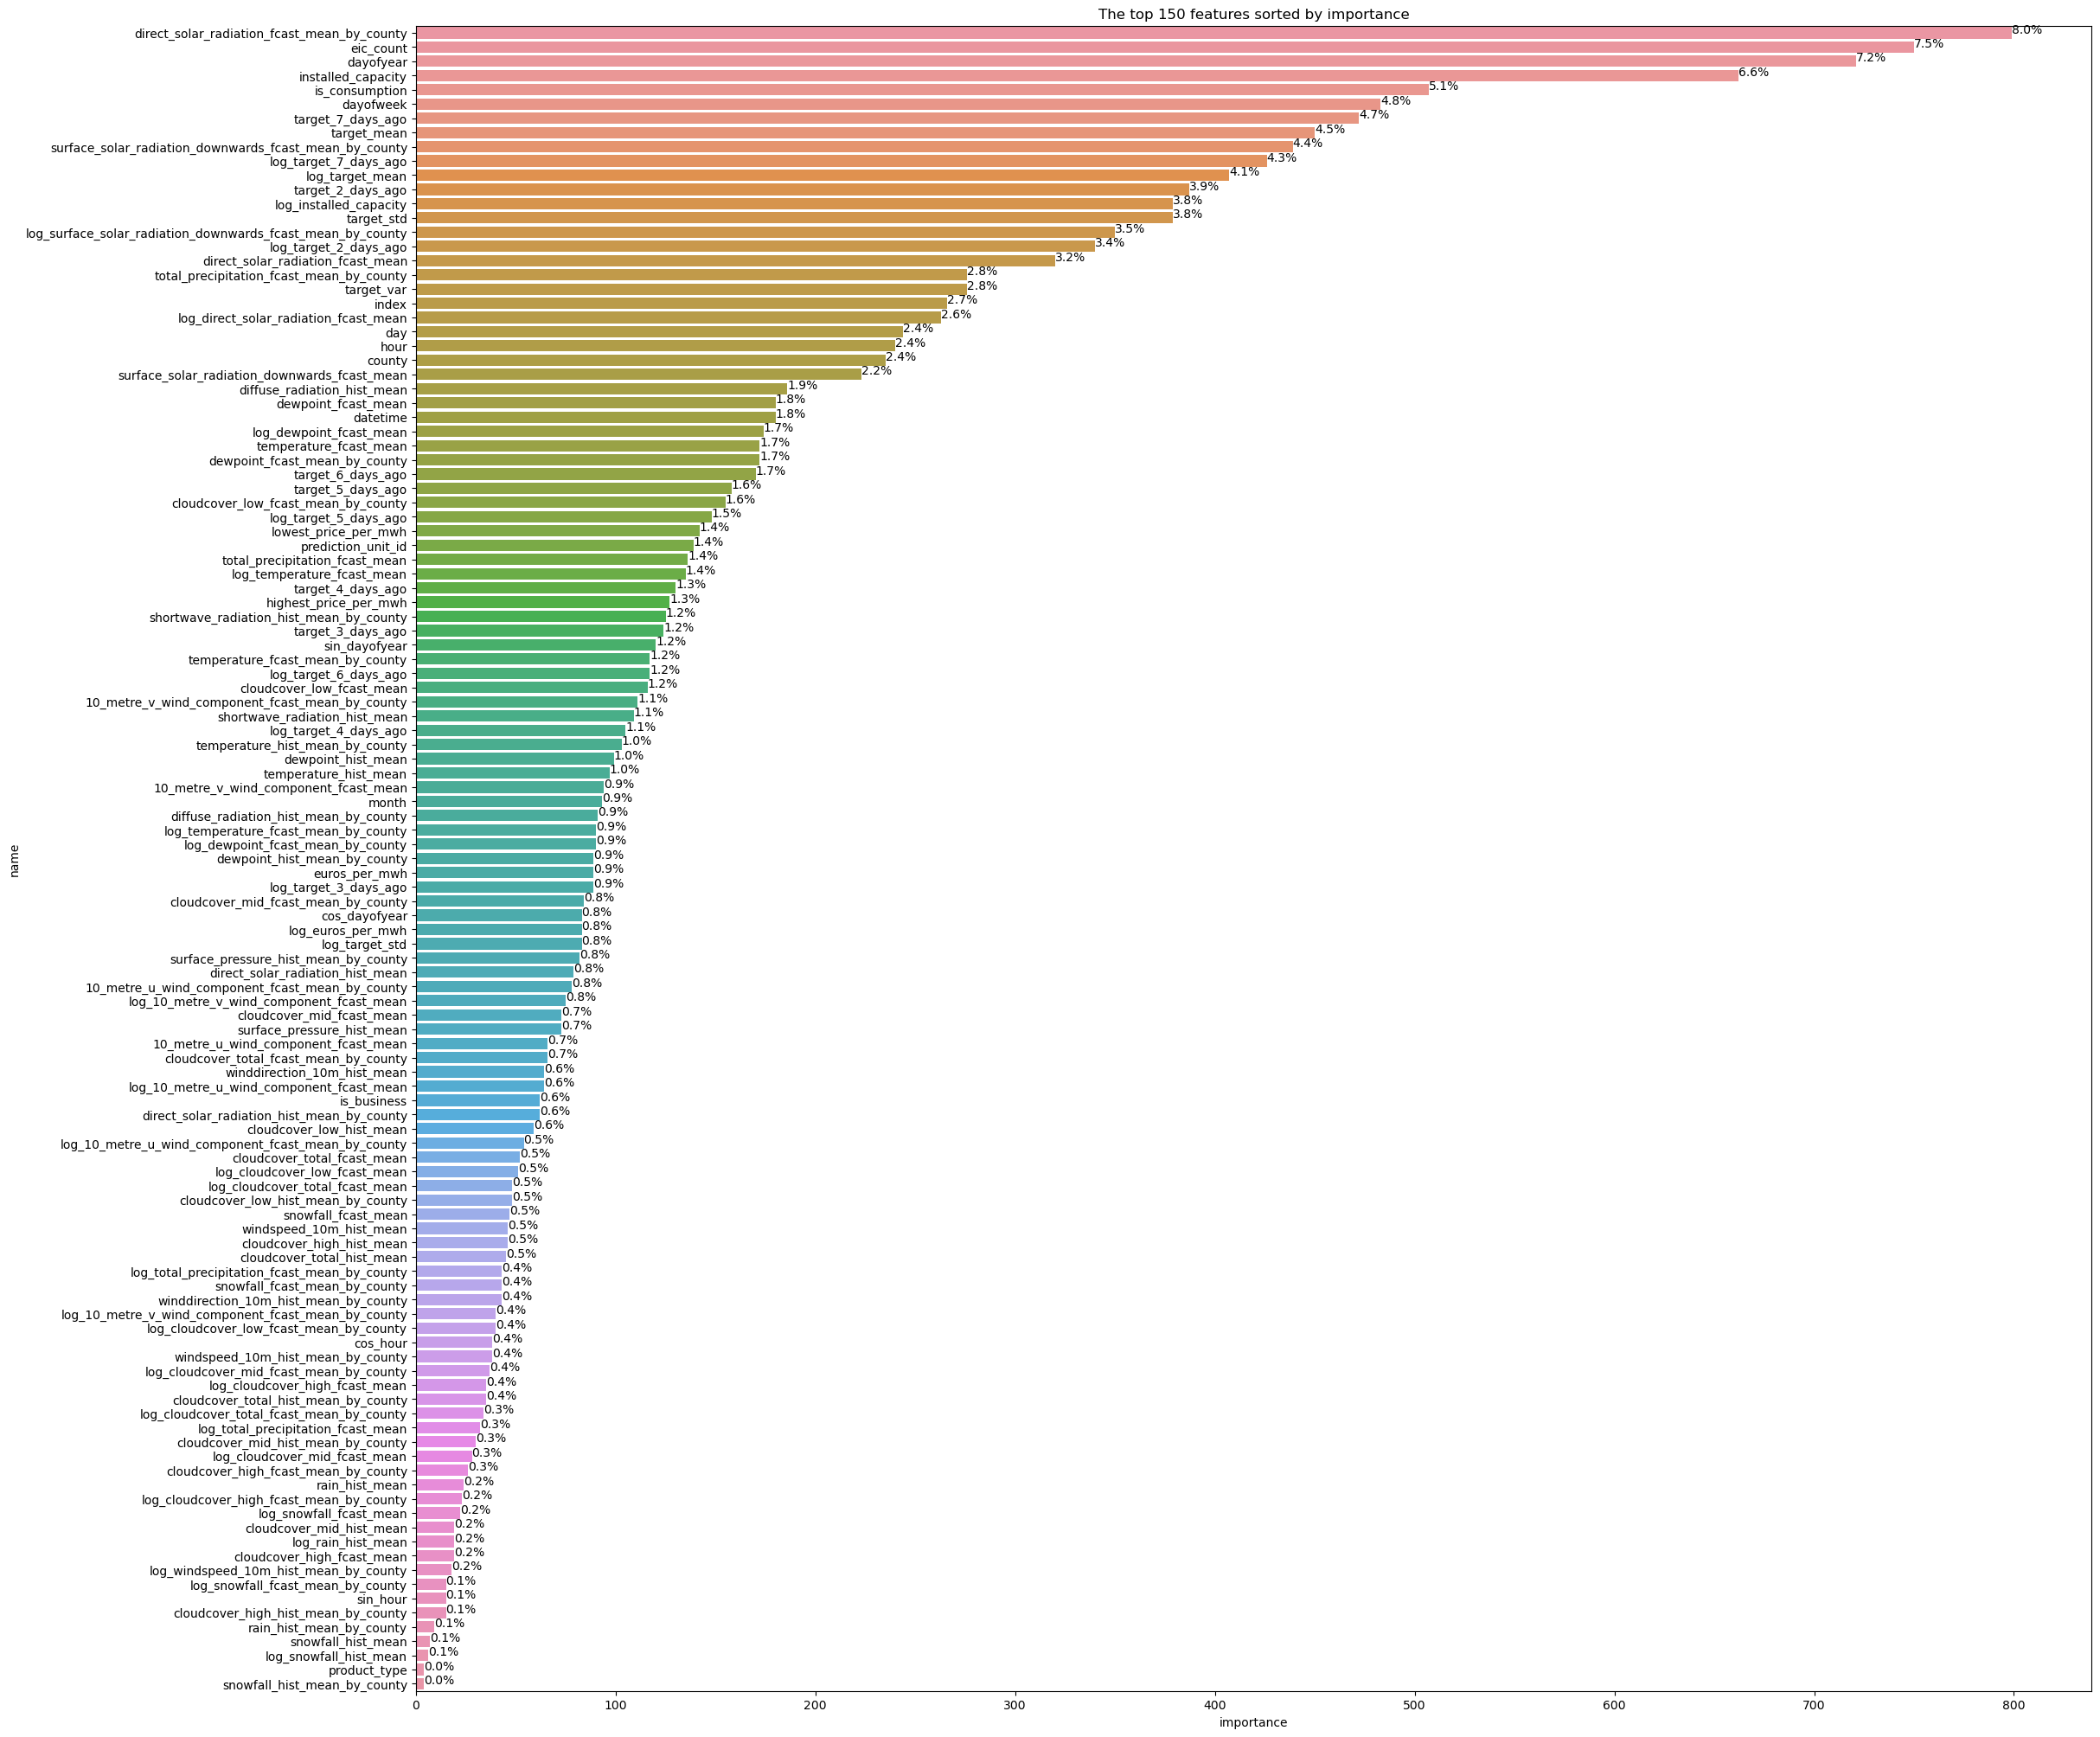

In [95]:
TOP = 150
importance_data = pd.DataFrame({'name': train.drop('target', axis= 1).columns
, 'importance': lgbm.feature_importances_})
importance_data = importance_data.sort_values(by='importance', ascending=False)

fig, ax = plt.subplots(figsize=(25,25))
sns.barplot(data=importance_data[:TOP],
            x = 'importance',
            y = 'name'
        )
patches = ax.patches
count = 0
for patch in patches:
    height = patch.get_height() 
    width = patch.get_width()
    perc = 0.01*importance_data['importance'].iloc[count]#100*width/len(importance_data)
    ax.text(width, patch.get_y() + height/2, f'{perc:.1f}%')
    count+=1
    
plt.title(f'The top {TOP} features sorted by importance')
plt.show()

In [98]:
from sklearn.metrics import mean_absolute_error

y_pred_test = lgbm.predict(X_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
print("Mean Absolute Error on Test Set:", mae_test)

[LightGBM] [Warning] feature_fraction is set=0.5156265423740586, colsample_bytree=0.3631305814194318 will be ignored. Current value: feature_fraction=0.5156265423740586
[LightGBM] [Warning] lambda_l1 is set=0.0033737944447648762, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0033737944447648762
[LightGBM] [Warning] lambda_l2 is set=2.6728903158700944e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6728903158700944e-07
[LightGBM] [Warning] bagging_fraction is set=0.4673328464871268, subsample=0.5812642246778825 will be ignored. Current value: bagging_fraction=0.4673328464871268
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
Mean Absolute Error on Test Set: 76.42073361543034


In [107]:
test = pd.read_csv('predict-energy-behavior-of-prosumers/example_test_files/test.csv')
gas_test= pd.read_csv('predict-energy-behavior-of-prosumers/example_test_files/gas_prices.csv')
electricity_test= pd.read_csv('predict-energy-behavior-of-prosumers/example_test_files/electricity_prices.csv')
client_test= pd.read_csv('predict-energy-behavior-of-prosumers/example_test_files/client.csv')
fw_test= pd.read_csv('predict-energy-behavior-of-prosumers/example_test_files/forecast_weather.csv')
hw_test= pd.read_csv('predict-energy-behavior-of-prosumers/example_test_files/historical_weather.csv')
revealed_targets = pd.read_csv('predict-energy-behavior-of-prosumers/example_test_files/revealed_targets.csv')

## **Test function**

In [100]:
def preTest(data, client, hist_weather, forecast_weather, electricity, gas, locations):
    
    '''Exact same function as the train function but with some tweaks'''
    
    data= data.rename(columns={'prediction_datetime' : 'datetime'})
    data['datetime'] = pd.to_datetime(data['datetime'], utc=True)
        
    electricity = electricity.rename(columns= {'forecast_date' : 'datetime'})
    
    electricity['datetime'] = pd.to_datetime(electricity['datetime'], utc= True)

    #locations = locations.drop('Unnamed: 0', axis= 1) 
        
    forecast_weather[['latitude', 'longitude']] = forecast_weather[['latitude', 'longitude']].astype(float).round(1)
        
    forecast_weather= forecast_weather.merge(locations, how='left', on=['longitude','latitude'])
        
    forecast_weather.dropna(axis= 0, inplace= True)    
    
    forecast_weather['county'] = forecast_weather['county'].astype('int64')
    
    forecast_weather.drop(['origin_datetime', 'latitude', 'longitude', 'hours_ahead', 'data_block_id'], axis=1, inplace= True)
    
    forecast_weather.rename(columns={'forecast_datetime': 'datetime'}, inplace= True)
    
    forecast_weather['datetime']= pd.to_datetime(forecast_weather['datetime'], utc= True)
    
    
    forecast_weather_datetime= forecast_weather.groupby([forecast_weather['datetime'].
                                            dt.to_period('h')])[list(forecast_weather.drop(['county',
                                                                                            'datetime'], axis= 1)
                                                                     .columns)].mean().reset_index()
    forecast_weather_datetime['datetime']= pd.to_datetime(
        forecast_weather_datetime['datetime'].dt.to_timestamp(), utc=True)
    
    forecast_weather_datetime_county= forecast_weather.groupby(['county',forecast_weather['datetime'].
                              dt.to_period('h')])[list(forecast_weather.drop(['county',
                                                                              'datetime'], axis= 1)
                                                       .columns)].mean().reset_index()
    forecast_weather_datetime_county['datetime']= pd.to_datetime(
        forecast_weather_datetime_county['datetime'].dt.to_timestamp(), utc=True)

                
    hist_weather[['latitude', 'longitude']] = hist_weather[['latitude', 'longitude']].astype(float).round(1)

    hist_weather= hist_weather.merge(locations, how='left', on=['longitude','latitude'])    
    
    hist_weather.dropna(axis= 0, inplace= True)
    
    hist_weather.drop(['latitude', 'longitude'], axis=1, inplace= True)

    hist_weather['county'] = hist_weather['county'].astype('int64')
            
    hist_weather['datetime']= pd.to_datetime(hist_weather['datetime'], utc= True)
    
    
    hist_weather_datetime= hist_weather.groupby([hist_weather['datetime'].
                                            dt.to_period('h')])[list(hist_weather.drop(['county',
                                                                                            'datetime', 'data_block_id'], axis= 1)
                                                                     .columns)].mean().reset_index()    
    
    hist_weather_datetime['datetime']= pd.to_datetime(hist_weather_datetime['datetime'].dt.to_timestamp(), utc=True)
    hist_weather_datetime= hist_weather_datetime.merge(hist_weather[['datetime', 'data_block_id']], how='left', on='datetime')
    
    
    hist_weather_datetime_county= hist_weather.groupby(['county',hist_weather['datetime'].
                              dt.to_period('h')])[list(hist_weather.drop(['county',
                                                                              'datetime', 'data_block_id'], axis= 1)
                                                       .columns)].mean().reset_index() 
    hist_weather_datetime_county['datetime']= pd.to_datetime(hist_weather_datetime_county['datetime'].dt.to_timestamp(), utc=True)
    hist_weather_datetime_county= hist_weather_datetime_county.merge(hist_weather[['datetime', 'data_block_id']], how='left', on='datetime')
    
    data['year'] = data['datetime'].dt.year
    
    data['month'] = data['datetime'].dt.month
    
    data['day'] = data['datetime'].dt.day
    
    data['hour'] = data['datetime'].dt.hour
    
    data['dayofweek']= data['datetime'].dt.dayofweek

    data['dayofyear']= data['datetime'].dt.dayofyear

        
    electricity['hour'] = electricity['datetime'].dt.hour

    
    data= data.merge(client.drop(columns = ['date']), how='left', on=['data_block_id', 'county', 'is_business', 'product_type'])

    data= data.merge(gas[['data_block_id', 'lowest_price_per_mwh', 'highest_price_per_mwh']], how='left', on='data_block_id')
    
    data= data.merge(electricity[['euros_per_mwh', 'hour', 'data_block_id']], how='left', on=['hour', 'data_block_id'])

    data= data.merge(forecast_weather_datetime, how='left', on=['datetime'])
    
    data= data.merge(forecast_weather_datetime_county, how='left', on=['datetime', 'county'],
                     suffixes= ('_fcast_mean','_fcast_mean_by_county'))
    
    
    hist_weather_datetime['hour']= hist_weather_datetime['datetime'].dt.hour
    hist_weather_datetime_county['hour']= hist_weather_datetime_county['datetime'].dt.hour

    hist_weather_datetime.drop_duplicates(inplace=True)
    hist_weather_datetime_county.drop_duplicates(inplace=True)
    hist_weather_datetime.drop('datetime', axis= 1, inplace= True)
    hist_weather_datetime_county.drop('datetime', axis= 1, inplace= True)

    
    data= data.merge(hist_weather_datetime, how='left', on=['data_block_id', 'hour'])



    data= data.merge(hist_weather_datetime_county, how='left', on=['data_block_id', 'county', 'hour'],
                     suffixes= ('_hist_mean','_hist_mean_by_county'))

    data= data.groupby(['year', 'day', 'hour'], as_index=False).apply(lambda x: x.ffill().bfill()).reset_index()

    data.drop(['row_id', 'data_block_id', 'year'], axis= 1, inplace= True)
    
    return data

In [101]:
def create_revealed_targets_test(data, previous_revealed_targets, N_day_lags):
    '''🎯 Create new test data based on previous_revealed_targets and N_day_lags 🎯 ''' 
    for count, revealed_targets in enumerate(previous_revealed_targets) :
        day_lag = count + 2
        
        # Get hour
        revealed_targets['hour'] = pd.to_datetime(revealed_targets['datetime'], utc= True).dt.hour
        
        # Select columns and rename target
        revealed_targets = revealed_targets[['hour', 'prediction_unit_id', 'is_consumption', 'target']]
        revealed_targets = revealed_targets.rename(columns = {"target" : f"target_{day_lag}_days_ago"})
        
        
        # Add past revealed targets
        data = pd.merge(data,
                        revealed_targets,
                        how = 'left',
                        on = ['hour', 'prediction_unit_id', 'is_consumption'],
                       )
        
    # If revealed_target_columns not available, replace by nan
    all_revealed_columns = [f"target_{day_lag}_days_ago" for day_lag in range(2, N_day_lags+1)]
    missing_columns = list(set(all_revealed_columns) - set(data.columns))
    data[missing_columns] = np.nan 
    
    return data

In [109]:
previous_revealed_targets = []
test = test.rename(columns = {'prediction_datetime': 'datetime'})
    
# Initiate column data_block_id with default value to merge the data on
id_column = 'data_block_id' 

test[id_column] = 0
gas_test[id_column] = 0
electricity_test[id_column] = 0
hw_test[id_column] = 0
fw_test[id_column] = 0
client_test[id_column] = 0
revealed_targets[id_column] = 0

data_test = preTest(test, client_test, hw_test,
                    fw_test, electricity_test, gas_test, locations)

data_test['datetime']= pd.to_datetime(data_test['datetime'], utc= True).astype('int64')
    

In [111]:
df_test = create_revealed_targets_test(data = data_test.copy(),
                                           previous_revealed_targets = previous_revealed_targets.copy(),
                                           N_day_lags = N_day_lags
                                          )
#Data Transformation
df_test['sin_hour']= (np.pi * np.sin(df_test['hour']) / 12)
df_test['cos_hour']= (np.pi * np.cos(df_test['hour']) / 12)
df_test['sin_hour']= (np.pi * np.sin(df_test['hour']) / 12)
df_test['cos_hour']= (np.pi * np.cos(df_test['hour']) / 12)
df_test['sin_dayofyear']= (np.pi * np.sin(df_test['dayofyear']) / 183)
df_test['cos_dayofyear']= (np.pi * np.cos(df_test['dayofyear']) / 183)
df_test['target_mean']= df_test[[f'target_{i}_days_ago' for i in range(2, N_day_lags+1)]].mean(1)
df_test['target_std']= df_test[[f'target_{i}_days_ago' for i in range(2, N_day_lags+1)]].std(1)
df_test['target_var']= df_test[[f'target_{i}_days_ago' for i in range(2, N_day_lags+1)]].var(1)
for i in to_log:
    df_test[f"log_{i}"]= np.where((df_test[i])!= 0, np.log(df_test[i]),0)
X_test = df_test.drop('currently_scored', axis= 1).values


KeyboardInterrupt: 

In [112]:
df_test['target_var']= df_test[[f'target_{i}_days_ago' for i in range(2, N_day_lags+1)]].var(1)
for i in to_log:
    df_test[f"log_{i}"]= np.where((df_test[i])!= 0, np.log(df_test[i]),0)
X_test = df_test.drop('currently_scored', axis= 1).values

MemoryError: Unable to allocate 9.79 GiB for an array with shape (104, 12632064) and data type float64

In [119]:
df_test.to_pickle('enefit_test.pkl')

In [118]:
train.columns

Index(['index', 'county', 'is_business', 'product_type', 'target',
       'is_consumption', 'datetime', 'prediction_unit_id', 'month', 'day',
       ...
       'log_snowfall_hist_mean', 'log_windspeed_10m_hist_mean_by_county',
       'log_target_2_days_ago', 'log_target_3_days_ago',
       'log_target_4_days_ago', 'log_target_5_days_ago',
       'log_target_6_days_ago', 'log_target_7_days_ago', 'log_target_mean',
       'log_target_std'],
      dtype='object', length=118)

## **Submission**

In [17]:
previous_revealed_targets = []
env = enefit.make_env()
iter_test = env.iter_test()
for (test, revealed_targets, client_test, historical_weather_test,
     forecast_weather_test, electricity_test, gas_test,sample_prediction) in iter_test:
    
    # Rename test set to make consistent with train
    test = test.rename(columns = {'prediction_datetime': 'datetime'})
    
    # Initiate column data_block_id with default value to merge the data on
    id_column = 'data_block_id' 
    
    test[id_column] = 0
    gas_test[id_column] = 0
    electricity_test[id_column] = 0
    historical_weather_test[id_column] = 0
    forecast_weather_test[id_column] = 0
    client_test[id_column] = 0
    revealed_targets[id_column] = 0
    
    data_test = preTest(test, client_test, historical_weather_test,
                        forecast_weather_test, electricity_test, gas_test, locations)
    
    data_test['datetime']= pd.to_datetime(data_test['datetime'], utc= True).astype('int64')
    
    # Store revealed_targets
    previous_revealed_targets.insert(0, revealed_targets)
    if len(previous_revealed_targets) == N_day_lags:
        previous_revealed_targets.pop()
    
    # Add previous revealed targets
    df_test = create_revealed_targets_test(data = data_test.copy(),
                                           previous_revealed_targets = previous_revealed_targets.copy(),
                                           N_day_lags = N_day_lags
                                          )
    #Data Transformation
    df_test['sin_hour']= (np.pi * np.sin(df_test['hour']) / 12)
    df_test['cos_hour']= (np.pi * np.cos(df_test['hour']) / 12)
    df_test['sin_hour']= (np.pi * np.sin(df_test['hour']) / 12)
    df_test['cos_hour']= (np.pi * np.cos(df_test['hour']) / 12)
    df_test['sin_dayofyear']= (np.pi * np.sin(df_test['dayofyear']) / 183)
    df_test['cos_dayofyear']= (np.pi * np.cos(df_test['dayofyear']) / 183)
    df_test['target_mean']= df_test[[f'target_{i}_days_ago' for i in range(2, N_day_lags+1)]].mean(1)
    df_test['target_std']= df_test[[f'target_{i}_days_ago' for i in range(2, N_day_lags+1)]].std(1)
    df_test['target_var']= df_test[[f'target_{i}_days_ago' for i in range(2, N_day_lags+1)]].var(1)
    for i in to_log:
        df_test[f"log_{i}"]= np.where((df_test[i])!= 0, np.log(df_test[i]),0)
    X_test = df_test.drop('currently_scored', axis= 1).values

    #Predictions
    test['target'] = lgbm.predict(X_test).clip(0)
    test['target_solar'] = lgbm2.predict(X_test).clip(0)
    test.loc[test['is_consumption']==0, "target"] = test.loc[test['is_consumption']==0, "target_solar"]  
    sample_prediction["target"] = test['target']
    
    #Sending predictions to the API
    env.predict(sample_prediction)

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
